In [1]:
import os

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['VECLIB_MAXIMUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'

import matplotlib.pyplot as plt
import re
import numpy as np
from numpy.random import default_rng, SeedSequence
import seaborn as sns
from sklearn.metrics import confusion_matrix
from scipy.optimize import root_scalar
from scipy.stats import norm
from scipy.integrate import quad, quad_vec
from scipy.special import log_ndtr
from functools import partial
from matplotlib.gridspec import GridSpec
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
import time
from numba import njit

def vectorized_convert_to_binary(x: np.ndarray, N: int) -> np.ndarray:
    """
    Versione completamente vettorializzata della conversione da coppie di interi
    a vettori binari di tipo Ising (-1, 1).
    """
    num_samples = x.shape[0]
    num_bits_per_int = N // 2

    powers_of_2 = 2 ** np.arange(num_bits_per_int - 1, -1, -1, dtype=np.uint32)
    
    col0_bits = (x[:, 0, None] & powers_of_2) // powers_of_2
    col1_bits = (x[:, 1, None] & powers_of_2) // powers_of_2

    bin_var = np.hstack((col0_bits, col1_bits)).astype(np.int8)
    ising_var = 2 * bin_var - 1

    return ising_var

def define_perfect_perceptron(N = 20):
    """
    Inizializzazione dell'array di pesi del Perceptron perfetto.
    """
    positive_part = 2 ** np.arange((N/2) -1, -1, -1)
    return np.concatenate((positive_part, -positive_part))

@njit(fastmath=True, cache=True)
def _core_fit_perceptron(X, y, J, epochs, seed):
    """Core loop per Perceptron classico."""
    np.random.seed(seed) # Impostiamo il seed locale per Numba
    P, N = X.shape
    idxs = np.arange(P)
    
    for epoch in range(epochs):
        updates_in_epoch = 0
        np.random.shuffle(idxs) # Shuffle supportato in Numba
        
        for i in idxs:
            xi = X[i]
            yi = y[i]
            
            # Calcolo predizione inline per evitare overhead
            dot_prod = 0.0
            for k in range(N):
                dot_prod += xi[k] * J[k]
            
            # Logica sign activation: > 0 -> 1, else -1
            yi_pred = 1.0 if dot_prod >= 0.0 else -1.0
            
            if yi_pred != yi:
                updates_in_epoch += 1
                # J += (yi * xi) / sqrt(N)
                factor = yi / np.sqrt(N)
                for k in range(N):
                    J[k] += factor * xi[k]
                    
        if updates_in_epoch == 0 and epoch > 0:
            break
            
    return J

@njit(fastmath=True, cache=True)
def _core_fit_noise(X, y, J, epochs, sigma, seed):
    """Core loop per Perceptron con noise (il collo di bottiglia principale)."""
    np.random.seed(seed)
    P, N = X.shape
    idxs = np.arange(P)
    sqrt_N = np.sqrt(N)
    sqrt_sigma = np.sqrt(sigma)
    
    for epoch in range(epochs):
        updates_in_epoch = 0
        np.random.shuffle(idxs)
        
        for i in idxs:
            xi = X[i]
            yi = y[i]
            
            # Dot product manuale o numpy (numpy.dot è ottimizzato anche in numba)
            # Qui uso dot perché su vettori piccoli/medi numba lo inlina bene
            if np.dot(xi, J) >= 0:
                yi_pred = 1.0
            else:
                yi_pred = -1.0

            if yi_pred != yi:
                updates_in_epoch += 1
                
                # Generazione rumore vettorizzata inside loop è supportata da Numba
                # ed è molto più veloce che in Python puro
                noise = np.random.normal(0.0, sqrt_sigma, N)
                
                # J += (1 + r_vector)*(yi * xi) / sqrt(N)
                factor = yi / sqrt_N
                for k in range(N):
                    J[k] += (1.0 + noise[k]) * factor * xi[k]

        if updates_in_epoch == 0 and epoch > 0:
            break
            
    return J

@njit(fastmath=True, cache=True)
def _core_fit_adaline(X, y, J, gamma, max_iter=200000, tol=1e-12):
    """
    Core loop per Adaline con Learning Rate adattivo.
    Usa una strategia di backtracking: se l'energia non scende, 
    rifiuta il passo e riduce il learning rate.
    """
    P, N = X.shape
    
    # Calcolo costo e gradiente iniziali
    pred = X.dot(J)
    diff = pred - y
    current_energy = 0.5 * np.sum(diff**2) / P
    
    # Calcoliamo il gradiente iniziale
    gradient = X.T.dot(diff) / P
    
    iter_idx = 0
    min_gamma = 1e-12 # Soglia di sicurezza per fermarsi se il passo è infinitesimale
    
    while iter_idx < max_iter:
        # 1. Proposta di aggiornamento pesi (Candidate Step)
        # Creiamo un nuovo vettore J candidato senza sovrascrivere quello attuale
        J_new = J - gamma * gradient
        
        # 2. Calcolo energia nel punto proposto
        new_pred = X.dot(J_new)
        new_diff = new_pred - y
        new_energy = 0.5 * np.sum(new_diff**2) / P
        
        # 3. Verifica condizione di discesa (Monotonicity Check)
        if new_energy < current_energy:
            # --- PASSO ACCETTATO ---
            
            # Verifica convergenza sulla variazione di energia
            if np.abs(current_energy - new_energy) < tol:
                J[:] = J_new[:]
                break
            
            # Aggiorniamo lo stato corrente
            current_energy = new_energy
            J[:] = J_new[:] # Copia i valori del candidato in J
            
            # Calcoliamo il NUOVO gradiente per la prossima iterazione
            # (Solo ora che ci siamo mossi ha senso ricalcolarlo)
            gradient = X.T.dot(new_diff) / P
            
            # Opzionale: Se volessi accelerare quando va bene, potresti fare:
            # gamma *= 1.01 
            
        else:
            # --- PASSO RIFIUTATO ---
            # L'energia è aumentata o rimasta uguale. Il passo era troppo lungo.
            # NON aggiorniamo J e NON ricalcoliamo il gradiente (è ancora valido per il vecchio J).
            # Riduciamo solo il learning rate e riproviamo.
            gamma *= 0.5
            
            # Se gamma diventa troppo piccolo, non possiamo più migliorare
            if gamma < min_gamma:
                break
        
        iter_idx += 1
        
    return J

@njit(fastmath=True, cache=True)
def _core_fit_noise_batch(X, y, J_batch, max_epochs, sigma, seed):
    """
    Versione 'Student-First' (Serializzazione degli studenti).
    
    Invece di avanzare epoca per epoca per tutti gli studenti (sincrono),
    addestriamo uno studente alla volta fino alla sua convergenza completa.
    
    Vantaggi:
    1. Cache Locality: J_batch[m] rimane nei registri CPU finché lo studente non ha finito.
    2. No Waiting Time: Non si aspetta lo studente più lento.
    """
    np.random.seed(seed)
    P, N = X.shape
    # J_batch è (M, N)
    M = J_batch.shape[0] 
    idxs = np.arange(P)
    sqrt_N = np.sqrt(N)
    sqrt_sigma = np.sqrt(sigma)
    
    # --- LOOP ESTERNO SUGLI STUDENTI (Serializzati) ---
    for m in range(M):
        
        epoch = 0
        # WHILE LOOP: continua finché QUESTO studente non ha 0 errori
        # max_epochs serve solo per evitare loop infiniti in casi degeneri
        while epoch < max_epochs:
            updates_in_epoch = 0
            np.random.shuffle(idxs)
            
            for i in idxs:
                xi = X[i]
                yi = y[i]
                
                # 1. Dot Product (Accesso sequenziale J[m, k])
                dot = 0.0
                for k in range(N):
                    dot += xi[k] * J_batch[m, k]
                
                pred = 1.0 if dot >= 0.0 else -1.0
                
                if pred != yi:
                    updates_in_epoch += 1
                    factor = yi / sqrt_N
                    
                    # 2. Update Component-Wise (Corretto fisicamente)
                    for k in range(N):
                        r_k = np.random.normal(0.0, sqrt_sigma)
                        J_batch[m, k] += factor * xi[k] * (1.0 + r_k)
            
            # Se lo studente 'm' ha fatto 0 errori, ha finito.
            # Break del while, passa al prossimo 'm'
            if updates_in_epoch == 0:
                break
            
            epoch += 1
            
    return J_batch    
# --- NUOVA CLASSE DI INCAPSULAMENTO ---
class BayesEnsemble:
    """
    Gestisce una popolazione di M perceptroni come un singolo oggetto.
    Mantiene l'incapsulamento OOP ma usa matrici per performance.
    """
    def __init__(self, N, M, seed=None):
        self.N = N
        self.M = M
        self.rng = np.random.default_rng(seed)
        # Stato interno: Matrice invece di lista di oggetti
        self.J_batch = self.rng.normal(0, 1, (M, N)).astype(np.float64)
        # Seed per numba
        self.numba_seed = self.rng.integers(0, 2**31 - 1)

    def fit(self, x_train, y_train, sigma2, epochs=200000):
        """Interfaccia standard fit, delega al kernel batch."""
        self.J_batch = _core_fit_noise_batch(
            x_train.astype(np.float64),
            y_train.astype(np.float64),
            self.J_batch,
            epochs,
            float(sigma2),
            self.numba_seed
        )

    def get_center_of_mass(self):
        """
        Restituisce il perceptrone medio (Center of Mass) 
        come un oggetto Perceptron standard, pronto per evaluation.
        """
        # Media lungo l'asse degli studenti
        J_cm = np.sum(self.J_batch, axis=0)
        
        # Normalizzazione sferica (come da logica originale)
        norm = np.linalg.norm(J_cm)
        if norm > 1e-9:
            J_cm /= norm
        J_cm *= np.sqrt(self.N)
        
        # Ritorniamo un oggetto Perceptron classico per compatibilità
        return Perceptron(N=self.N, J=J_cm)
    
class Perceptron:
  def __init__(self, N=20, J=None, seed=None):
    self.seed = seed
    self.rng = np.random.default_rng(seed)
    self.N = N

    self.numba_seed = self.rng.integers(0, 2**31 - 1) if seed is not None else np.random.randint(0, 2**31 -1)

    if J is None:
      self.J = self.rng.normal(0, 1, self.N).astype(np.float64)
    else:
      self.J = J.astype(np.float64) # Numba ama i float64

    self.evolution_J = []

  def _sign_activation(self, x):
    x = np.asarray(x)
    return np.where(x > 0, 1, -1)

  def predict(self, x_binary):
    """Esegue predizioni usando i coefficienti del modello fittato."""
    return self._sign_activation(np.dot(x_binary, self.J)) 

  def evaluate(self, x_binary, y):
    """Calcola l'errore medio di classificazione."""
    y_pred = self.predict(x_binary)
    y = np.atleast_1d(y)
    return np.mean(y_pred != y)

  def fit_perceptron(self, x_binary, y, epochs=5000):
    """Wrapper per il training Numba standard."""
    self.evolution_J.append(self.J.copy())
    
    # Chiamata a Numba
    # Passiamo self.J direttamente (passaggio per riferimento, array mutabile)
    self.J = _core_fit_perceptron(
        x_binary.astype(np.float64), 
        y.astype(np.float64), 
        self.J, 
        epochs, 
        self.numba_seed
    )
        
    self.evolution_J.append(self.J.copy())
    return self.J.copy()  

  def fit_noise(self, x_binary, y, sigma2=50, epochs=5000):
    """Wrapper per il training Numba con noise."""
    self.evolution_J.append(self.J.copy())

    # Chiamata a Numba
    self.J = _core_fit_noise(
          x_binary.astype(np.float64),
          y.astype(np.float64),
          self.J,
          epochs,
          float(sigma2),
          self.numba_seed
      )

    self.evolution_J.append(self.J.copy())
    return self.J.copy()

  def fit_hebb(self, x_binary, y):
    self.J = 0
    self.J = np.sum(x_binary * y.reshape(-1, 1), axis=0)
    return self.J.copy()

  def fit_pseudo_inverse(self, x_binary, y):
    self.J = 0
    C = np.dot(x_binary*y.reshape(-1, 1), (x_binary*y.reshape(-1, 1)).T)/self.N
    C[np.diag_indices_from(C)] += 1e-10
    try:
      x = np.linalg.solve(C, np.ones(y.shape[0]))
    except np.linalg.LinAlgError:
      x = np.sum(np.linalg.pinv(C), axis=1)

    self.J = np.sum(x.reshape(-1, 1)*x_binary*y.reshape(-1, 1), axis=0)/np.sqrt(self.N)
    return self.J.copy()
  
  def fit_adaline(self, x_binary, y, gamma=0.05):
      """Wrapper per il training Adaline Numba."""
      # Inizializzazione come da tuo codice originale
      self.J = np.sum(x_binary, axis=0).astype(float)
      norm_J = np.linalg.norm(self.J)
      self.J /= norm_J
              
      # Chiamata a Numba
      self.J = _core_fit_adaline(
          x_binary.astype(np.float64),
          y.astype(np.float64),
          self.J,
          float(gamma)
      )
        
      return self.J.copy()

  def _adaline_cost_function(self, x_binary, y):
    return 0.5*np.sum(((x_binary @ self.J).reshape(-1, 1) - y.reshape(-1, 1))**2)/x_binary.shape[0]

class SyntheticDataGenerator:
  def __init__(self, N=20, seed=None, teacher_perceptron=None):
    self.N = N
    if seed is None:
      self.rng = np.random.default_rng()
    else:
      self.rng = np.random.default_rng(seed)
    
    if teacher_perceptron is None:
      self.teacher = Perceptron(N=N, seed=seed)
    else:
      self.teacher = teacher_perceptron

  def generate_data_generic_teacher(self, P):
    """
    Genera un set completo di dati (x, y) di P campioni.
    
    Shape X: (P, N)
    
    Shape y: (P,)
    """
    x_binary = self.rng.choice([-1, 1], size=(P, self.teacher.N))

    y = self.teacher.predict(x_binary)

    return x_binary, y  
  
  def generate_data(self, P):
    """
    Genera un set completo di dati (x, y) di P campioni,
    assicurandosi che nessuna coppia (a, b) abbia a == b.
    """
    max_val = 2**(self.N//2)

    x = self.rng.integers(max_val, size=(P, 2))

    duplicate_mask = (x[:, 0] == x[:, 1])

    while np.any(duplicate_mask):
      num_duplicates = np.sum(duplicate_mask)  
      # Rigenero solamente il secondo valore
      x[duplicate_mask, 1] = self.rng.integers(max_val, size=num_duplicates) 
      # Aggiorno la maschera dei duplicati
      duplicate_mask = (x[:, 0] == x[:, 1])

    x_binary = vectorized_convert_to_binary(x, self.N)

    y = self.teacher.predict(x_binary)

    return x_binary, y  

In [6]:
S = SyntheticDataGenerator(N=20, seed=5)
X, y = S.generate_data(P=5)
print(X.shape, y.shape)
print(X)
# print(np.dot(X, X.T))
# print(y.reshape(2000, 1))
# print(X*y.reshape(2000, 1))
studente = Perceptron(N=20)
J_PI = studente.fit_pseudo_inverse(X, y)
print(J_PI)
print(np.sum(X * (np.dot(X, J_PI).reshape(-1, 1) - y.reshape(-1, 1)), axis=0).reshape(-1, 1))
print(X.T @ ((X @ J_PI).reshape(-1, 1) - y.reshape(-1, 1)))


(5, 20) (5,)
[[ 1 -1  1 -1  1 -1  1  1  1 -1  1  1 -1 -1  1  1  1 -1 -1 -1]
 [-1 -1 -1 -1 -1  1 -1  1  1  1  1  1 -1 -1  1  1  1 -1  1  1]
 [-1  1  1  1  1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1  1  1  1  1]
 [ 1 -1  1 -1 -1 -1 -1  1 -1  1 -1  1 -1 -1  1 -1 -1  1 -1 -1]
 [ 1  1  1  1  1 -1  1 -1  1  1 -1 -1 -1 -1  1  1 -1  1  1  1]]
[-0.02733693  0.18487176 -0.6787898   0.18487176 -0.17282498  0.6787898
  0.47862789 -0.18487176 -0.11444442 -0.2627125  -0.33035982 -0.18487176
  1.27186212  1.27186212 -0.62040925 -0.11444442 -0.33035982 -0.32109306
 -0.40820056 -0.40820056]
[[ -3.47213595]
 [  3.47213595]
 [-10.41640786]
 [  3.47213595]
 [ -3.47213595]
 [ 10.41640786]
 [  3.47213595]
 [ -3.47213595]
 [ -3.47213595]
 [ -3.47213595]
 [ -3.47213595]
 [ -3.47213595]
 [ 17.36067977]
 [ 17.36067977]
 [-10.41640786]
 [ -3.47213595]
 [ -3.47213595]
 [ -3.47213595]
 [ -3.47213595]
 [ -3.47213595]]
[[ -3.47213595]
 [  3.47213595]
 [-10.41640786]
 [  3.47213595]
 [ -3.47213595]
 [ 10.41640786]
 [  3.4721

In [2]:
# ==============================================================================
#     DEFINIZIONI MATEMATICHE E TEORICHE (ANNEALED)
# Funzioni pure che implementano la teoria. Non dipendono da classi o stato.
# ==============================================================================

def parametric_alphas_annealed(eps):
    """Calcola alpha(eps) per la teoria annealed in modo parametric_solver."""
    safe_eps = np.clip(np.asarray(eps), 1e-9, 0.5 - 1e-9)
    return np.pi * (1 - safe_eps) / (np.tan(np.pi * safe_eps) + 1e-9)

def f1_annealed(eps, alpha):
    """Prima mappa iterativa per la teoria annealed."""
    return 1 - alpha * np.tan(np.pi * eps) / np.pi

def f2_annealed(eps, alpha):
    """Seconda mappa iterativa per la teoria annealed."""
    return np.arctan((np.pi * (1 - eps)) / alpha) / np.pi


# ==============================================================================
#     DEFINIZIONI MATEMATICHE E TEORICHE (QUENCHED)
# Funzioni pure che implementano la teoria. Non dipendono da classi o stato.
# ==============================================================================

def I_R(R):
    """Calcola l'integrale I(R) per un singolo valore di R."""
    if R < 0 or R >= 1: return np.nan
    def integrand(v, R_val):
        log_H = log_ndtr(np.sqrt(R_val) * v)
        return np.exp(-0.5 * (1 + R_val) * v**2 - log_H) / np.sqrt(2 * np.pi)
    result, _ = quad(integrand, -np.inf, np.inf, args=(R,))
    return result

def I_R_vec(R_array):
    """Versione vettorizzata di I_R che preserva la forma dell'input."""
    original_shape = R_array.shape
    R_flat = R_array.flatten() # Lavoriamo su un array appiattito

    valid_mask = (R_flat >= 0) & (R_flat < 1)
    results_flat = np.full_like(R_flat, np.nan, dtype=float)

    if np.any(valid_mask):
        valid_R = R_flat[valid_mask]
        res_quad, _ = quad_vec(
            lambda v, r: np.exp(-0.5 * (1 + r) * v**2 - log_ndtr(np.sqrt(r) * v)),
            -np.inf, np.inf, args=(valid_R,)
        )
        results_flat[valid_mask] = res_quad / np.sqrt(2 * np.pi)

    # Rimodelliamo il risultato alla forma originale dell'input
    return results_flat.reshape(original_shape)

def f1_quenched(R, alpha):
  """Funzione f1 corretta per gestire alpha sia come scalare che come array."""
  R = np.asarray(R)
  # alpha può essere uno scalare o un array, il broadcasting gestirà entrambi i casi

  I_val = I_R_vec(R)

  # Calcoliamo il risultato direttamente. Se R, alpha o I_val sono NaN,
  # il risultato sarà NaN, il che è corretto.
  return (alpha / np.pi) * np.sqrt(1 - R) * I_val

def f2_quenched(R, alpha):
  """Funzione f2 corretta per gestire alpha sia come scalare che come array."""
  R = np.asarray(R)
  alpha = np.asarray(alpha) # Convertire in array per ndim

  I_val = I_R_vec(R)

  # Il denominatore è il punto critico
  denominator = alpha**2 * I_val**2

  # Condizione per un calcolo valido
  valid_condition = (denominator > 1e-18) & (R >= 0) & (R < 1)

  # Calcola il rapporto solo dove la condizione è valida, altrimenti metti NaN
  ratio = np.divide(
      np.pi**2 * R**2,
      denominator,
      out=np.full_like(R, np.nan),
      where=valid_condition
  )

  return 1 - ratio

def parametric_solver_quenched(R_values):
    """Calcola alpha data una serie di R (il punto fisso)."""
    R_values = np.asarray(R_values)
    mask = (R_values > 0) & (R_values < 1)
    alphas = np.full_like(R_values, np.nan)
    if np.any(mask):
        valid_R = R_values[mask]
        lhs = (np.pi * valid_R) / np.sqrt(1 - valid_R)
        rhs = I_R_vec(valid_R)
        alphas[mask] = lhs / rhs
    return alphas

def parametric_solver_bayes(R_values):
    """Calcola alpha data una serie di R (il punto fisso)."""
    R_values = np.asarray(R_values)
    mask = (R_values > 0) & (R_values < 1)
    alphas = np.full_like(R_values, np.nan)
    if np.any(mask):
        valid_R = R_values[mask]
        lhs = (np.pi * valid_R**2) / np.sqrt(1 - valid_R**2)
        rhs = I_R_vec(valid_R**2)
        alphas[mask] = lhs / rhs
    return alphas

# ==============================================================================
#     PROCEDURE NUMERICHE GENERALI
# Funzioni per l'analisi numerica che possono essere riutilizzate.
# ==============================================================================

def vectorized_iterative_procedure(alphas, x_0, a, f, max_epochs=2000, tol=1e-8):
    """
    Calcola l'evoluzione di una mappa iterativa per un array di `alphas`.
    Restituisce la matrice della storia dell'evoluzione.
    """
    alphas = np.asarray(alphas)
    num_alphas = len(alphas)
    old_x = np.full(num_alphas, float(x_0))
    history = np.zeros((max_epochs, num_alphas))

    for epoch in range(max_epochs):
        new_x = (1 - a) * old_x + a * f(old_x, alphas)
        history[epoch, :] = new_x

        if np.all(np.abs(new_x - old_x) < tol):
            print(f"Convergenza raggiunta all'epoca {epoch + 1}.")
            history[epoch+1:, :] = new_x
            return history[:epoch + 1]

        old_x = new_x

    print(f"Attenzione: Max epoche ({max_epochs}) raggiunto.")
    return history

def evolution_vs_a_procedure(alpha, x_0, a_values, f, max_epochs=200):
    """Calcola l'evoluzione per un alpha fisso e diversi valori di `a`."""
    a_values = np.asarray(a_values)
    num_a = len(a_values)
    old_x = np.full(num_a, float(x_0))
    history = np.zeros((max_epochs, num_a))

    for epoch in range(max_epochs):
        f_val = f(old_x, alpha)
        new_x = (1 - a_values) * old_x + a_values * f_val
        history[epoch, :] = new_x
        old_x = new_x

    return history

def numerical_derivative(f, x, alpha, h=1e-6):
    """Calcola la derivata numerica di f(x, alpha) rispetto a x."""
    return (f(x + h, alpha) - f(x - h, alpha)) / (2 * h)

def hybrid_iterative_procedure(
    alphas,
    eps_0,
    a,
    f1,
    f2,
    crossover_alpha,
    max_epochs=2000,
    tol=1e-8
):
    """
    Esegue una procedura iterativa ibrida.

    Usa la funzione f1 per alpha <= crossover_alpha e f2 per alpha > crossover_alpha.

    Args:
        alphas (np.array): Array di valori di alpha.
        eps_0 (float): Punto di partenza dell'iterazione.
        a (float): Parametro di rilassamento.
        f1 (callable): Funzione iterativa per alpha piccoli.
        f2 (callable): Funzione iterativa per alpha grandi.
        crossover_alpha (float): Valore di alpha in cui si passa da f1 a f2.
        max_epochs (int): Numero massimo di iterazioni.
        tol (float): Tolleranza per la convergenza.

    Returns:
        np.array: Array dei punti fissi trovati per ogni alpha.
    """
    alphas = np.asarray(alphas)

    # 1. Definiamo la funzione ibrida 'f_hybrid'
    def f_hybrid(eps_array, alpha_array):
        # Inizializziamo l'output con NaN
        results = np.full_like(eps_array, np.nan)

        # Maschera per decidere quale funzione usare
        mask_f1 = (alpha_array <= crossover_alpha)
        mask_f2 = (alpha_array > crossover_alpha)

        # Applica f1 dove la maschera è vera
        if np.any(mask_f1):
            results[mask_f1] = f1(eps_array[mask_f1], alpha_array[mask_f1])

        # Applica f2 dove la maschera è vera
        if np.any(mask_f2):
            results[mask_f2] = f2(eps_array[mask_f2], alpha_array[mask_f2])

        return results

    # 2. Esegui la procedura vettorizzata con la funzione ibrida
    print(f"Esecuzione procedura ibrida con crossover a alpha = {crossover_alpha}...")
    evolution_matrix = vectorized_iterative_procedure(
        alphas,
        eps_0,
        a,
        f_hybrid,
        max_epochs,
        tol
    )

    # 3. Estrai e restituisci l'ultimo valore (il punto fisso) per ogni alpha
    fixed_points = evolution_matrix[-1, :]
    return fixed_points

# ==============================================================================
#     FUNZIONI DI VISUALIZZAZIONE
# Funzioni dedicate al plotting, separate dalla logica di calcolo.
# ==============================================================================

def compare_dynamics(f1, f2, alpha, x_0, a_values, max_epochs, interval=[0.001, 0.999], is_epsilon=False, save_figure=True):
    """Esegue e plotta la dinamica di convergenza per f1 e f2."""
    print("--- Calcolo Dinamiche di Convergenza ---")
    evo1 = evolution_vs_a_procedure(alpha, x_0, a_values, f1, max_epochs)
    evo2 = evolution_vs_a_procedure(alpha, x_0, a_values, f2, max_epochs)

    print("--- Plotting Dinamiche ---")
    fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharey=True)
    colors = plt.cm.viridis(np.linspace(0, 1, len(a_values)))

    for ax, evo, f, name in zip(axes, [evo1, evo2], [f1, f2], ["f_1", "f_2"]):
        try:
            pf = root_scalar(lambda x: x - f(x, alpha), x0=x_0, bracket=interval).root
            ax.axhline(pf, color='black', ls='--', label=f'Punto fisso ≈ {pf:.3f}')
        except ValueError:
            print(f"Nessun punto fisso trovato per {name} nell'intervallo.")

        for i, a_val in enumerate(a_values):
            trajectory = np.concatenate(([x_0], evo[:, i]))
            ax.plot(trajectory, label=f'a = {a_val}', color=colors[i], lw=2.5)

        ax.set_title(f'Dinamica per Funzione ${name}$', fontsize=16)
        ax.set_xlabel('Epoca (i)', fontsize=14)
        ax.legend()
        ax.set_ylim(interval)
        ax.grid(True, ls=':', alpha=0.7)

    if is_epsilon:
        axes[0].set_ylabel(r'Valore di $\epsilon_i$', fontsize=14)
    else:
        axes[0].set_ylabel(r'Valore di $R_i$', fontsize=14)
    fig.suptitle(f'Confronto Dinamiche per $\\alpha={alpha}$ e $x_0={x_0}$', fontsize=20)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    if save_figure:
        filename = f"compare_dynamics_x0_{x_0}_alpha_{alpha}.png"
        print(f"\nSalvataggio figura in: {filename}")
        fig.savefig(filename, dpi=300, bbox_inches='tight')

    plt.show()


def plot_results_annealed(
    f_map=f2_annealed,
    a_fixed=0.9,
    x0_fixed=0.5,
    max_epochs=5000,
    save_figure=False
):
    """
    Genera il grafico che confronta la curva parametrica teorica (Annealed)
    con i punti fissi calcolati tramite la dinamica iterativa.

    Args:
        f_map (callable): La funzione della mappa da usare per l'iterazione (es. f2_annealed).
        a_fixed (float): Valore fisso del parametro di rilassamento 'a'.
        x0_fixed (float): Valore iniziale per l'iterazione.
        max_epochs (int): Numero massimo di epoche per la convergenza.
        save_figure (bool): Se True, salva il grafico su file.
    """
    print("\n--- Esecuzione Plot di Confronto (Annealed) ---")

    # --- 1. Calcolo Curva Teoria Parametrica ---
    print("Calcolo curva teorica parametrica...")
    eps_parametric = np.linspace(1e-9, 0.5 - 1e-9, 500)
    alpha_parametric = parametric_alphas_annealed(eps_parametric)

    # --- 2. Calcolo Punti Fissi da Mappa Iterativa ---
    print(f"Calcolo punti fissi da mappa iterativa (usando {f_map.__name__})...")
    alphas_for_map = np.linspace(0.01, 10, 100)
    evolution_matrix = vectorized_iterative_procedure(
        alphas=alphas_for_map,
        x_0=x0_fixed,
        a=a_fixed,
        f=f_map,
        max_epochs=max_epochs
    )
    eps_from_map = evolution_matrix[-1, :] if evolution_matrix.shape[0] > 0 else np.full_like(alphas_for_map, np.nan)

    # --- 3. Creazione del Grafico ---
    print("--- Calcolo Completato. Inizio Plotting. ---")
    fig, ax = plt.subplots(figsize=(14, 9))

    # Plotta Curva Teoria Parametrica
    ax.plot(
        alpha_parametric,
        eps_parametric,
        color='black',
        linestyle='--',
        linewidth=3,
        label='Teoria Annealed (Parametrica)'
    )

    # Plotta Punti Fissi Trovati
    ax.plot(
        alphas_for_map,
        eps_from_map,
        'o',
        markersize=8,
        color='limegreen',
        markeredgecolor='black',
        label=f'Punti Fissi da Dinamica ({f_map.__name__}, a={a_fixed})'
    )

    # --- 4. Personalizzazione Grafico ---
    ax.set_title(r"Curva di Apprendimento (Annealed) - $\epsilon^*$ vs $\alpha$", fontsize=20, pad=15)
    ax.set_xlabel(r"$\alpha = p/N$", fontsize=16)
    ax.set_ylabel(r"$\epsilon^*$", fontsize=16)
    ax.legend(fontsize=14)
    ax.grid(True, which='both', linestyle='--', alpha=0.6)
    ax.set_xlim(left=0, right=10)
    ax.set_ylim(bottom=-0.02, top=0.55)
    ax.tick_params(axis='both', which='major', labelsize=12)

    plt.tight_layout()

    if save_figure:
        filename = "annealed_theory_vs_dynamics.png"
        print(f"\nSalvataggio figura in: {filename}")
        fig.savefig(filename, dpi=300, bbox_inches='tight')

    plt.show()

def plot_results_quenched(
    a_fixed=0.5,
    r_zero_fixed=0.5,
    crossover_alpha=2.0,
    max_epochs_fixed=5000,
    plot_in_epsilon=True,
    save_figure=False
    ):
    """
    Genera il grafico che confronta la curva parametrica teorica (quenched)
    con i punti fissi calcolati tramite la procedura iterativa ibrida.

    Permette di visualizzare i risultati in termini di R(alpha) o epsilon(alpha).

    Args:
        plot_in_epsilon (bool): Se True, l'asse y mostra l'errore epsilon.
                                Se False (default), mostra l'overlap R.
    """
    # --- 1. Parametri per la Simulazione ---

    alphas_for_fixed_point = np.linspace(0.1, 8, 100)

    # --- 2. Calcolo dei Punti Fissi tramite Procedura Ibrida ---
    # La procedura calcola sempre l'overlap R
    fixed_point_R = hybrid_iterative_procedure(
        alphas=alphas_for_fixed_point,
        eps_0=r_zero_fixed,
        a=a_fixed,
        f1=f1_quenched,
        f2=f2_quenched,
        crossover_alpha=crossover_alpha,
        max_epochs=max_epochs_fixed
    )

    # --- 3. Generazione della Curva Parametrica Teorica ---
    print("\n--- Calcolo della Curva Parametrica Teorica ---")
    r_values_parametric = np.linspace(0.001, 0.999, 500)
    alpha_values_parametric = parametric_solver_quenched(r_values_parametric)

    # --- 4. Conversione a Epsilon (se richiesta) e Impostazione Etichette ---
    if plot_in_epsilon:
        # Conversione dei dati
        y_values_parametric = (1 / np.pi) * np.arccos(r_values_parametric)
        y_values_fixed_point = (1 / np.pi) * np.arccos(fixed_point_R)

        # Impostazione etichette e limiti per epsilon
        title = r"Curva di Apprendimento (Quenched) - $\epsilon^*$ vs $\alpha$"
        ylabel = r"$\epsilon^*$"
        ylim = (-0.02, 0.52)
    else:
        # I dati rimangono in termini di R
        y_values_parametric = r_values_parametric
        y_values_fixed_point = fixed_point_R

        # Impostazione etichette e limiti per R
        title = r"Curva di Apprendimento (Quenched) - $R^*$ vs $\alpha$"
        ylabel = r"$R^*$"
        ylim = (-0.05, 1.05)

    # --- 5. Creazione del Grafico ---
    print("--- Calcolo Completato. Inizio Plotting. ---")
    fig, ax = plt.subplots(figsize=(14, 9))

    # Plotta la curva parametrica teorica
    ax.plot(
        alpha_values_parametric,
        y_values_parametric, # <-- Usa i valori y corretti (R o epsilon)
        color='purple',
        linestyle='--',
        linewidth=2.5,
        label='Teoria Quenched (Parametrica)'
    )

    # Plotta i punti fissi trovati iterativamente
    ax.plot(
        alphas_for_fixed_point,
        y_values_fixed_point, # <-- Usa i valori y corretti (R o epsilon)
        'o',
        markersize=7,
        color='limegreen',
        markeredgecolor='black',
        label=f'Punti Fissi da Dinamica Ibrida (a={a_fixed})'
    )

    ax.axvline(x=crossover_alpha, color='red', linestyle=':', linewidth=2, label=f'Crossover $\\alpha_c = {crossover_alpha}$')

    # --- 6. Personalizzazione del Grafico ---
    ax.set_title(title, fontsize=20, pad=15)
    ax.set_xlabel(r"$\alpha = P/N$", fontsize=16)
    ax.set_ylabel(ylabel, fontsize=16)
    ax.legend(fontsize=14)
    ax.grid(True, which='both', linestyle='--', alpha=0.6)

    ax.set_xlim(left=0, right=8)
    ax.set_ylim(bottom=ylim[0], top=ylim[1])
    ax.tick_params(axis='both', which='major', labelsize=12)

    plt.tight_layout()
    
    if save_figure:
        filename = "quenched_comparison_plot_final.png"
        print(f"\nSalvataggio figura in: {filename}")
        fig.savefig(filename, dpi=300, bbox_inches='tight')
    
    plt.show()

def plot_advanced_comparison_(exp_results, save_figure=True):
    """
    Plotta il confronto completo tra dati sperimentali e teorie.
    Include:
    1. Dati sperimentali per N=20 e N=40.
    2. Teoria Annealed (sia parametrica che da mappa iterativa).
    3. Teoria Quenched (sia parametrica che da mappa ibrida).
    """
    print("\n--- Esecuzione Plot di Confronto Completo ---")
    res = exp_results

    # --- 1. Preparazione Dati Sperimentali ---
    alpha_20 = np.array(res['train_sizes_20']) / 20
    sem_20 = res['error_stds_20'] / np.sqrt(res.get('runs_num', 1000))

    alpha_40 = np.array(res['train_sizes_40']) / 40
    sem_40 = res['error_stds_40'] / np.sqrt(res.get('runs_num', 1000))

    # --- 2. Calcolo Teorie Annealed ---
    print("Calcolo teorie Annealed...")
    # Curva parametrica
    eps_param_annealed = np.linspace(1e-9, 0.5 - 1e-9, 500)
    alpha_param_annealed = parametric_alphas_annealed(eps_param_annealed)
    # Punti fissi da mappa iterativa (es. f2)
    alphas_for_annealed_map = np.linspace(0.01, 15, 100)
    evo_matrix_annealed = vectorized_iterative_procedure(
        alphas=alphas_for_annealed_map,
        x_0=0.5,
        a=0.9,
        f=f2_annealed, # Usiamo f2 per l'annealed
        max_epochs=5000
    )
    eps_from_annealed_map = evo_matrix_annealed[-1, :] if evo_matrix_annealed.shape[0] > 0 else np.full_like(alphas_for_annealed_map, np.nan)


    # --- 3. Calcolo Teorie Quenched ---
    print("Calcolo teorie Quenched...")
    # Curva parametrica (esatta)
    r_param_quenched = np.linspace(0.001, 0.999, 500)
    alpha_param_quenched = parametric_solver_quenched(r_param_quenched)
    eps_param_quenched = (1 / np.pi) * np.arccos(r_param_quenched)

    # Punti fissi da procedura ibrida (validazione numerica)
    A_FIXED_HYBRID = 0.5
    R_ZERO_HYBRID = 0.5
    CROSSOVER_ALPHA_HYBRID = 2.0
    alphas_for_hybrid_map = np.linspace(0.1, 15, 100)

    fixed_points_R_quenched = hybrid_iterative_procedure(
        alphas=alphas_for_hybrid_map,
        eps_0=R_ZERO_HYBRID,
        a=A_FIXED_HYBRID,
        f1=f1_quenched,
        f2=f2_quenched,
        crossover_alpha=CROSSOVER_ALPHA_HYBRID
    )
    eps_from_hybrid_map = (1 / np.pi) * np.arccos(fixed_points_R_quenched)

    print("--- Calcoli Teorici Completati. Inizio Plotting. ---")

    # --- 4. Creazione del Grafico ---
    fig, ax = plt.subplots(figsize=(16, 10))

    # --- GRUPPO ANNEALED ---
    ax.plot(alpha_param_annealed, eps_param_annealed, color='deepskyblue', linestyle=':', lw=3,
            label='Annealed (Teoria Parametrica)')
    ax.plot(alphas_for_annealed_map, eps_from_annealed_map, 'P', markersize=8, color='cyan',
            alpha=0.8, markeredgecolor='black', linestyle='None',
            label=r'Annealed (Punti Fissi da $f_2$)')

    # --- GRUPPO QUENCHED ---
    ax.plot(alpha_param_quenched, eps_param_quenched, color='black', linestyle='--', lw=3,
            label='Quenched (Teoria Parametrica)')
    ax.plot(alphas_for_hybrid_map, eps_from_hybrid_map, 'x', markersize=8, color='limegreen',
            label=f'Quenched (Punti Fissi da Ibrido)')

    # --- GRUPPO SPERIMENTALE ---
    ax.errorbar(alpha_20, res['error_means_20'], yerr=sem_20, fmt='o', markersize=8, capsize=5,
                label='Sperimentale N=20 (SEM)', color='royalblue', zorder=10)
    ax.errorbar(alpha_40, res['error_means_40'], yerr=sem_40, fmt='s', markersize=8, capsize=5,
                label='Sperimentale N=40 (SEM)', color='red', zorder=10)

    # --- 5. Personalizzazione Grafico ---
    ax.set_title(r"Confronto Completo: Dati Sperimentali vs Teorie", fontsize=20, pad=15)
    ax.set_xlabel(r"$\alpha = p/N$", fontsize=16)
    ax.set_ylabel(r"$\langle \epsilon \rangle$ (Errore Medio di Generalizzazione)", fontsize=16)

    # Migliora la legenda
    handles, labels = ax.get_legend_handles_labels()
    # Ordine personalizzato per la legenda per una migliore leggibilità
    order = [4, 5, 2, 3, 0, 1]
    ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order], fontsize=13, ncol=2)

    ax.grid(True, which='both', linestyle='--', alpha=0.6)
    ax.set_xlim(left=0, right=15)
    ax.set_ylim(bottom=-0.02, top=0.55)
    ax.tick_params(axis='both', which='major', labelsize=12)

    plt.tight_layout()

    if save_figure:
        filename = "master_comparison_plot_final.png"
        print(f"\nSalvataggio figura in: {filename}")
        fig.savefig(filename, dpi=300, bbox_inches='tight')

    plt.show()

def plot_convergence_analysis(
    f1,
    f2,
    parametric_solver,
    alpha_range=(0.1, 10),
    a_range=(0, 2),
    x_range=(0.001, 0.999),
    grid_resolution=(100, 100),
    a_highlight=None, # NUOVO PARAMETRO: valore di 'a' da evidenziare
    labels={
        'title': 'Analisi di Convergenza della Dinamica Iterativa',
        'x_label': r'$\alpha$',
        'y_label': r'$a$ (parametro di rilassamento)',
        'var_name': 'R'
    },
    save_figure=True
):
    """
    Analizza e visualizza la stabilità di due mappe iterative f1 e f2.
    Genera due heatmap e un grafico comparativo dell'efficienza.
    Permette di evidenziare l'efficienza per un valore specifico di 'a'.
    """
    print("--- Inizio Analisi di Convergenza ---")

    # 1. Creazione della griglia di parametri
    alpha_vals = np.linspace(alpha_range[0], alpha_range[1], grid_resolution[0])
    a_vals = np.linspace(a_range[0], a_range[1], grid_resolution[1])
    ALPHA_grid, A_grid = np.meshgrid(alpha_vals, a_vals, indexing='ij')

    # 2. Pre-calcolo dei punti fissi x*(alpha)
    print("Pre-calcolo dei punti fissi...")
    # Valori di R per calcolare alpha(R)
    x_solver_grid = np.linspace(x_range[0], x_range[1], 200)
    # Valori di alpha(R) calcolati in modo parametrico
    alpha_solver_grid = parametric_solver(x_solver_grid)
    # Seleziono solo i valori non nan di alpha
    valid_indices = ~np.isnan(alpha_solver_grid)
    # Ordino i valori di alpha per interpolare e
    # visualizzare R(alpha) con alpha crescente
    sorted_indices = np.argsort(alpha_solver_grid[valid_indices])
    # Interpolo i valori, calcolo R(alpha) (alpha(R) monotono posso invertire senza problemi)
    x_star_func = np.interp(
        alpha_vals,
        alpha_solver_grid[valid_indices][sorted_indices],
        x_solver_grid[valid_indices][sorted_indices]
    )

    # 3. Calcolo delle derivate e del fattore di convergenza
    print("Calcolo delle derivate numeriche sulla griglia...")
    f1_prime_1d = numerical_derivative(f1, x_star_func, alpha_vals)
    f2_prime_1d = numerical_derivative(f2, x_star_func, alpha_vals)

    f1_prime_grid = np.tile(f1_prime_1d, (grid_resolution[1], 1)).T
    g1_prime_grid = (1 - A_grid) + A_grid * f1_prime_grid
    C1 = np.abs(g1_prime_grid)

    f2_prime_grid = np.tile(f2_prime_1d, (grid_resolution[1], 1)).T
    g2_prime_grid = (1 - A_grid) + A_grid * f2_prime_grid
    C2 = np.abs(g2_prime_grid)

    # 4. Calcolo della curva a_ottimale
    a_opt1 = 1 / (1 - f1_prime_1d)
    a_opt2 = 1 / (1 - f2_prime_1d)

    print("--- Analisi Completata. Inizio Plotting. ---")

    # 5. Visualizzazione
    fig = plt.figure(figsize=(22, 16))
    gs = GridSpec(2, 2, height_ratios=[3, 2], hspace=0.3)

    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
    ax_comp = fig.add_subplot(gs[1, :])

    levels = [0, 0.2, 0.5, 0.8, 1.0]
    contour_colors = 'white'

    # --- Heatmap per f1 (con highlight di 'a' se specificato) ---
    im1 = ax1.imshow(C1.T, extent=[alpha_range[0], alpha_range[1], a_range[0], a_range[1]], origin='lower', aspect='auto', cmap='viridis_r', vmin=0, vmax=2)
    cs1 = ax1.contour(alpha_vals, a_vals, C1.T, levels=levels, colors=contour_colors, linewidths=1.5)
    ax1.clabel(cs1, inline=True, fontsize=10, fmt='%.1f')
    ax1.plot(alpha_vals, a_opt1, color='red', linestyle='--', label=r'$a_{opt}$')
    if a_highlight is not None:
        ax1.axhline(y=a_highlight, color='cyan', linestyle=':', linewidth=2, label=f'$a = {a_highlight}$')
    ax1.set_title(r"Fattore di Convergenza $|g'(R^*)|$ per $f_1$", fontsize=18)
    ax1.set_xlabel(labels['x_label'], fontsize=14)
    ax1.set_ylabel(labels['y_label'], fontsize=14)
    ax1.legend()
    ax1.grid(True, linestyle=':', alpha=0.5)

    # --- Heatmap per f2 (con highlight di 'a' se specificato) ---
    im2 = ax2.imshow(C2.T, extent=[alpha_range[0], alpha_range[1], a_range[0], a_range[1]], origin='lower', aspect='auto', cmap='viridis_r', vmin=0, vmax=2)
    cs2 = ax2.contour(alpha_vals, a_vals, C2.T, levels=levels, colors=contour_colors, linewidths=1.5)
    ax2.clabel(cs2, inline=True, fontsize=10, fmt='%.1f')
    ax2.plot(alpha_vals, a_opt2, color='red', linestyle='--', label=r'$a_{opt}$')
    if a_highlight is not None:
        ax2.axhline(y=a_highlight, color='cyan', linestyle=':', linewidth=2, label=f'$a = {a_highlight}$')
    ax2.set_title(r"Fattore di Convergenza $|g'(R^*)|$ per $f_2$", fontsize=18)
    ax2.set_xlabel(labels['x_label'], fontsize=14)
    plt.setp(ax2.get_yticklabels(), visible=False)
    ax2.legend()
    ax2.grid(True, linestyle=':', alpha=0.5)

    # --- Colorbar ---
    cbar = fig.colorbar(im1, ax=[ax1, ax2], orientation='vertical', pad=0.02)
    cbar.set_label(r"Fattore di Riduzione dell'Errore $|g'(R^*)|$", fontsize=14, rotation=270, labelpad=25)

    # --- Grafico Comparativo di Efficienza (MODIFICATO) ---
    ax_comp.axhline(y=1.0, color='red', linestyle='--', label='Limite di convergenza')
    ax_comp.fill_between(alpha_vals, 1.0, 10, color='red', alpha=0.1, label='Regione di Divergenza')
    ax_comp.fill_between(alpha_vals, 0, 1.0, color='green', alpha=0.1, label='Regione di Convergenza')

    # Efficienza per a=1 (riferimento)
    g1_prime_a1 = np.abs(f1_prime_1d)
    g2_prime_a1 = np.abs(f2_prime_1d)
    ax_comp.plot(alpha_vals, g1_prime_a1, label=r"$|g'|$ per $f_1$ con $a=1$", color='royalblue', linestyle=':', linewidth=2)
    ax_comp.plot(alpha_vals, g2_prime_a1, label=r"$|g'|$ per $f_2$ con $a=1$", color='darkorange', linestyle=':', linewidth=2)

    # Efficienza per a_highlight (se specificato)
    if a_highlight is not None:
        g1_prime_highlight = np.abs((1 - a_highlight) + a_highlight * f1_prime_1d)
        g2_prime_highlight = np.abs((1 - a_highlight) + a_highlight * f2_prime_1d)
        ax_comp.plot(alpha_vals, g1_prime_highlight, label=fr"$|g'|$ per $f_1$ con $a={a_highlight}$", color='royalblue', linewidth=2.5)
        ax_comp.plot(alpha_vals, g2_prime_highlight, label=fr"$|g'|$ per $f_2$ con $a={a_highlight}$", color='darkorange', linewidth=2.5)
        ax_comp.set_title(f"Efficienza Comparata dei Metodi (con focus su $a={a_highlight}$)", fontsize=18)
    else:
        ax_comp.set_title("Efficienza Comparata dei Metodi ($a=1$)", fontsize=18)

    ax_comp.set_xlabel(labels['x_label'], fontsize=14)
    ax_comp.set_ylabel(r"Fattore di Convergenza $|g'(R^*)|$", fontsize=14)
    ax_comp.set_xlim(alpha_range)
    ax_comp.set_ylim(0, 2.0)
    ax_comp.legend(fontsize=12)
    ax_comp.grid(True, linestyle=':', alpha=0.7)

    fig.suptitle(labels['title'], fontsize=24, y=0.98)
    
    if save_figure:
        filename = 'convergence_comparison.png'
        print(f"\nSalvataggio figura in: {filename}")
        fig.savefig(filename, dpi=300, bbox_inches='tight')
        
    plt.show()


In [3]:
def hebb_gen_error(alpha: np.ndarray) -> np.ndarray:
    return np.arccos(np.sqrt((2*alpha) / (2*alpha + np.pi))) / np.pi

def hebb_train_error(alpha: np.ndarray) -> np.ndarray:
    """
    Calculates the theoretical training error for the Hebbian learning rule.

    This function is designed to be vectorized over the input `alpha`.
    """
    
    integrand = lambda x, alpha: np.exp(-0.5 * x**2 + log_ndtr(-1/np.sqrt(alpha) - np.sqrt(2 * alpha / np.pi) * x))
    integral, _ = quad_vec(integrand, 0, np.inf, args=(alpha,))
        
    return np.sqrt(2/np.pi)*integral
    

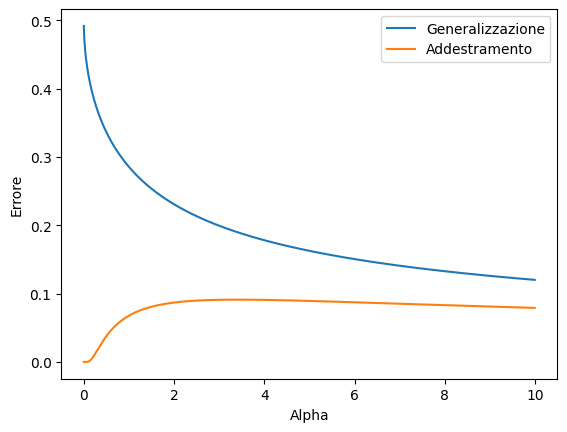

In [40]:
alphas = np.arange(0.001, 10, 0.01)

hebb_gen_error(alphas)
hebb_train_error(alphas)

plt.plot(alphas, hebb_gen_error(alphas), label='Generalizzazione')
plt.plot(alphas, hebb_train_error(alphas), label='Addestramento')
plt.xlabel('Alpha')
plt.ylabel('Errore')
plt.legend()
plt.show()

In [27]:
from mpl_toolkits.axes_grid1.inset_locator import mark_inset, inset_axes

def run_single_perceptron_noise(N: int, P: int, x_val: np.ndarray, y_val: np.ndarray, sigma2: float, seed: int, teacher_perceptron: Perceptron) -> float:
    """
    Esegue UNA singola run di addestramento e valutazione.
    Questa funzione è definita a livello di modulo (top-level) per essere
    efficientemente parallelizzabile con `joblib` e `multiprocessing`.
    """
    # Generatori e perceptron con lo stesso seed (per coerenza interna)
    data_generator = SyntheticDataGenerator(seed=seed, N=N, teacher_perceptron=teacher_perceptron)
    student_perceptron = Perceptron(N=N, seed=seed)

    # Genera dati di training unici per questa run
    x_train, y_train = data_generator.generate_data(P=P)

    # Addestra il modello
    student_perceptron.fit_noise(x_train, y_train, sigma2=sigma2)

    # Valuta l'errore sui dati di validazione comuni
    error = student_perceptron.evaluate(x_val, y_val)
    return error

def run_single_perceptron_zero_noise(N: int, P: int, seed: int, test_size: int) -> float:
    """
    Esegue UNA singola run di addestramento e valutazione.
    Questa funzione è definita a livello di modulo (top-level) per essere
    efficientemente parallelizzabile con `joblib` e `multiprocessing`.
    """
    ss = SeedSequence(seed)
    dataset_seed, student_seed = ss.spawn(2)
    
    data_generator = SyntheticDataGenerator(N=N,seed=dataset_seed)
    student_perceptron = Perceptron(N=N, seed=student_seed)
    
    # Genera dati di training unici per questa run
    x_train, y_train = data_generator.generate_data_generic_teacher(P=P)
    x_val, y_val = data_generator.generate_data_generic_teacher(P=test_size)
    
    # Addestra il modello
    student_perceptron.fit_perceptron(x_train, y_train)

    # Valuta l'errore sui dati di validazione comuni
    error = student_perceptron.evaluate(x_val, y_val)
    return error

def run_single_hebb(N: int, P: int, seed: int, test_size: int) -> tuple:
    """
    Esegue UNA singola run di addestramento e valutazione.
    Questa funzione è definita a livello di modulo (top-level) per essere
    efficientemente parallelizzabile con `joblib` e `multiprocessing`.
    
    return train_error, gen_error
    """
    # Non serve utilizzare due seed, tanto il J_0 viene sempre messo a zero per la Hebb Rule
    data_generator = SyntheticDataGenerator(N=N, seed=seed)
    student_perceptron = Perceptron(N=N)
    
    # Genera dati di training unici per questa run
    x_train, y_train = data_generator.generate_data_generic_teacher(P=P)
    x_val, y_val = data_generator.generate_data_generic_teacher(P=test_size)
    
    # Addestra il modello
    student_perceptron.fit_hebb(x_train, y_train)
    
    # Valuta l'errore sui dati di validazione comuni
    train_error = student_perceptron.evaluate(x_train, y_train)
    gen_error = student_perceptron.evaluate(x_val, y_val)
    return train_error, gen_error

def run_single_pseudo_inverse(N: int, P: int, seed: int, test_size: int) -> tuple:
    """
    Esegue UNA singola run di addestramento e valutazione per la regola di Pseudo Inversa.
    """
    # Non serve utilizzare due seed, tanto il J_0 viene sempre messo a zero per la pseudo inverse rule
    data_generator = SyntheticDataGenerator(N=N, seed=seed)
    student_perceptron = Perceptron(N=N)
    
    # Genera dati di training unici per questa run
    x_train, y_train = data_generator.generate_data_generic_teacher(P=P)
    x_val, y_val = data_generator.generate_data_generic_teacher(P=test_size)
    
    # Addestra il modello
    student_perceptron.fit_pseudo_inverse(x_train, y_train)
    
    # Valuta l'errore sui dati di validazione comuni
    train_error = student_perceptron.evaluate(x_train, y_train)
    gen_error = student_perceptron.evaluate(x_val, y_val)
    return train_error, gen_error

def run_single_adaline(N: int, P: int, seed: int, test_size: int) -> tuple:
    """
    Esegue UNA singola run di addestramento e valutazione per la regola di Pseudo Inversa.
    """
    # Non serve utilizzare due seed, tanto il J_0 viene sempre messo a zero per la pseudo inverse rule
    data_generator = SyntheticDataGenerator(N=N, seed=seed)
    student_perceptron = Perceptron(N=N)
    
    # Genera dati di training unici per questa run
    x_train, y_train = data_generator.generate_data_generic_teacher(P=P)
    x_val, y_val = data_generator.generate_data_generic_teacher(P=test_size)
    
    # Addestra il modello
    student_perceptron.fit_adaline(x_train, y_train)
    
    # Valuta l'errore sui dati di validazione comuni
    train_error = student_perceptron.evaluate(x_train, y_train)
    gen_error = student_perceptron.evaluate(x_val, y_val)
    return train_error, gen_error

def run_bayes_chunk_oop(n_runs, N, P, M, sigma2, test_size, chunk_seed):
    """
    Esegue un blocco (chunk) di simulazioni Bayes in sequenza su un singolo core.
    CORREZIONE SEED: Garantisce indipendenza statistica tra Teacher e Studenti.
    """
    # 1. Inizializziamo la sequenza principale per questo chunk (processo)
    ss_chunk = SeedSequence(chunk_seed)
    
    # 2. Generiamo n_runs semi, uno per ogni iterazione del loop
    run_seeds = ss_chunk.spawn(n_runs)
    
    train_errors = np.zeros(n_runs)
    gen_errors = np.zeros(n_runs)
    
    for i in range(n_runs):
        # 3. PER OGNI RUN: Biforchiamo l'entropia in due flussi distinti
        #    Creiamo una SeedSequence locale per questa run specifica
        ss_local = run_seeds[i]
        
        #    spawn(2) crea due semi figli statisticamente indipendenti
        seed_teacher, seed_students = ss_local.spawn(2)
        
        # 4. Generazione Dati (Usa seed_teacher)
        #    Il teacher interno verrà inizializzato usando questo seed.
        #    Quindi J_teacher dipende da seed_teacher.
        data_gen = SyntheticDataGenerator(N=N, seed=seed_teacher)
        x_train, y_train = data_gen.generate_data_generic_teacher(P)
        x_val, y_val = data_gen.generate_data_generic_teacher(test_size)
        
        # 5. Inizializzazione Ensemble (Usa seed_students)
        #    La matrice J_batch degli studenti verrà inizializzata con questo seed.
        #    Essendo seed_students != seed_teacher, J_batch è scorrelato da J_teacher.
        ensemble = BayesEnsemble(N=N, M=M, seed=seed_students)
        
        # 6. Training Batch
        ensemble.fit(x_train, y_train, sigma2=sigma2)
        
        # 7. Recupero Center of Mass e Valutazione
        cm_student = ensemble.get_center_of_mass()
        train_errors[i] = cm_student.evaluate(x_train, y_train)
        gen_errors[i] = cm_student.evaluate(x_val, y_val)
        
    return train_errors, gen_errors

class Experiment:
  def __init__(self, name="Esperimento Perceptrone"):
    """
    Inizializza l'esperimento.
    """
    self.name = name
    self.results = {}

  def simulation_perceptron_noise(self, train_sizes: list[int], test_size: int, runs_num: int, sigma2: float, N: int, master_seed: int = 123456):
    print(f"--- Inizio simulazione perceptron noise parallela per N = {N} ---")
    error_means = []
    error_stds = []

    master_rng = np.random.default_rng(master_seed)

    print(f"Generazione di {test_size} campioni di validazione per N={N}...")
    
    perfect_J = define_perfect_perceptron(N=N)
    perfect_teacher = Perceptron(N=N, J=perfect_J)
    
    data_generator_val = SyntheticDataGenerator(N=N, seed=master_rng.integers(0, 2**31 - 1), teacher_perceptron=perfect_teacher)
    x_val, y_val = data_generator_val.generate_data(P=test_size)

    for P in train_sizes:
        start_time = time.time()
        print(f"Avvio di {runs_num} run in parallelo per N={N}, P={P}...")

        # Genera semi indipendenti per ogni run
        run_seeds = master_rng.integers(0, 2**31 - 1, size=runs_num)
        
        # Esegui in parallelo con i semi specifici
        errors = Parallel(
            n_jobs=-1,
            verbose=10,
            batch_size='auto',
            pre_dispatch='2*n_jobs'
        )(
            delayed(run_single_perceptron_noise)(N, P, x_val, y_val, sigma2, seed=s, teacher_perceptron=perfect_teacher)
            for s in run_seeds
        )

        errors = np.array(errors)
        error_means.append(np.mean(errors))
        error_stds.append(np.std(errors))

        end_time = time.time()
        print(f"Completato per N={N}, P={P} in {end_time - start_time:.2f} secondi. Errore medio: {error_means[-1]:.4f} ± {error_stds[-1]:.4f}")

    return np.array(error_means), np.array(error_stds)

  def simulation_perceptron_zero_noise(self, train_sizes: list[int], test_size: int, runs_num: int, N: int, master_seed: int = 123456):
    print(f"--- Inizio simulazione perceptron noise parallela per N = {N} ---")
    error_means = []
    error_stds = []

    master_rng = np.random.default_rng(master_seed)

    print(f"Generazione di {test_size} campioni di validazione per N={N}...")
    
    for P in train_sizes:
        start_time = time.time()
        print(f"Avvio di {runs_num} run in parallelo per N={N}, P={P}...")

        # Genera semi indipendenti per ogni run
        run_seeds = master_rng.integers(0, 2**31 - 1, size=runs_num)
        
        # Esegui in parallelo con i semi specifici
        errors = Parallel(
            n_jobs=-1,
            verbose=10,
            batch_size='auto',
            pre_dispatch='2*n_jobs'
        )(
            delayed(run_single_perceptron_zero_noise)(N, P, seed=s, test_size=test_size)
            for s in run_seeds
        )

        errors = np.array(errors)
        error_means.append(np.mean(errors))
        error_stds.append(np.std(errors))

        end_time = time.time()
        print(f"Completato per N={N}, P={P} in {end_time - start_time:.2f} secondi. Errore medio: {error_means[-1]:.4f} ± {error_stds[-1]:.4f}")

    return np.array(error_means), np.array(error_stds)

  def simulation_hebb(self, train_sizes: list[int], test_size: int, runs_num: int, N: int, master_seed: int = 123456):
    print(f"--- Inizio simulazione perceptron noise parallela per N = {N} ---")
    train_error_means = []
    train_error_stds = []
    
    gen_error_means = []
    gen_error_stds = []

    master_rng = np.random.default_rng(master_seed)

    print(f"Generazione di {test_size} campioni di validazione per N={N}...")
    
    for P in train_sizes:
        start_time = time.time()
        print(f"Avvio di {runs_num} run in parallelo per N={N}, P={P}...")

        # Genera semi indipendenti per ogni run
        run_seeds = master_rng.integers(0, 2**31 - 1, size=runs_num)
        
        # Esegui in parallelo con i semi specifici
        errors = Parallel(
            n_jobs=-1,
            verbose=0,
            batch_size='auto',
            pre_dispatch='2*n_jobs'
        )(
            delayed(run_single_hebb)(N, P, seed=s, test_size=test_size)
            for s in run_seeds
        )
        train_errors , gen_errors = zip(*errors)
        
        train_errors = np.array(train_errors)
        train_error_means.append(np.mean(train_errors))
        train_error_stds.append(np.std(train_errors))
        
        gen_errors = np.array(gen_errors)
        gen_error_means.append(np.mean(gen_errors))
        gen_error_stds.append(np.std(gen_errors))

        end_time = time.time()
        print(f"Completato per N={N}, P={P} in {end_time - start_time:.2f} secondi.")
        print(f"Errore medio di train: {train_error_means[-1]:.4f} ± {train_error_stds[-1]:.4f}")
        print(f"Errore medio di generalizzazione: {gen_error_means[-1]:.4f} ± {gen_error_stds[-1]:.4f}")

    return np.array(train_error_means), np.array(train_error_stds), np.array(gen_error_means), np.array(gen_error_stds)
    
  def simulation_pseudo_inverse(self, train_sizes: list[int], test_size: int, runs_num: int, N: int, master_seed: int = 123456):
    print(f"--- Inizio simulazione perceptron noise parallela per N = {N} ---")
    train_error_means = []
    train_error_stds = []
    
    gen_error_means = []
    gen_error_stds = []

    master_rng = np.random.default_rng(master_seed)

    print(f"Generazione di {test_size} campioni di validazione per N={N}...")
    
    for P in train_sizes:
        start_time = time.time()
        print(f"Avvio di {runs_num} run in parallelo per N={N}, P={P}...")

        # Genera semi indipendenti per ogni run
        run_seeds = master_rng.integers(0, 2**31 - 1, size=runs_num)
        
        # Esegui in parallelo con i semi specifici
        errors = Parallel(
            n_jobs=-1,
            verbose=0,
            batch_size='auto',
            pre_dispatch='2*n_jobs'
        )(
            delayed(run_single_pseudo_inverse)(N, P, seed=s, test_size=test_size)
            for s in run_seeds
        )
        train_errors , gen_errors = zip(*errors)
        
        train_errors = np.array(train_errors)
        train_error_means.append(np.mean(train_errors))
        train_error_stds.append(np.std(train_errors))
        
        gen_errors = np.array(gen_errors)
        gen_error_means.append(np.mean(gen_errors))
        gen_error_stds.append(np.std(gen_errors))

        end_time = time.time()
        print(f"Completato per N={N}, P={P} in {end_time - start_time:.2f} secondi.")
        print(f"Errore medio di train: {train_error_means[-1]:.4f} ± {train_error_stds[-1]:.4f}")
        print(f"Errore medio di generalizzazione: {gen_error_means[-1]:.4f} ± {gen_error_stds[-1]:.4f}")

    return np.array(train_error_means), np.array(train_error_stds), np.array(gen_error_means), np.array(gen_error_stds)
    
  def simulation_adaline(self, train_sizes: list[int], test_size: int, runs_num: int, N: int, master_seed: int = 123456):
    print(f"--- Inizio simulazione adaline noise parallela per N = {N} ---")
    train_error_means = []
    train_error_stds = []
    
    gen_error_means = []
    gen_error_stds = []

    master_rng = np.random.default_rng(master_seed)

    print(f"Generazione di {test_size} campioni di validazione per N={N}...")
    
    for P in train_sizes:
        start_time = time.time()
        print(f"Avvio di {runs_num} run in parallelo per N={N}, P={P}...")

        # Genera semi indipendenti per ogni run
        run_seeds = master_rng.integers(0, 2**31 - 1, size=runs_num)
        
        # Esegui in parallelo con i semi specifici
        errors = Parallel(
            n_jobs=-1,
            verbose=0,
            batch_size='auto',
            pre_dispatch='2*n_jobs'
        )(
            delayed(run_single_adaline)(N, P, seed=s, test_size=test_size)
            for s in run_seeds
        )
        train_errors , gen_errors = zip(*errors)
        
        train_errors = np.array(train_errors)
        train_error_means.append(np.mean(train_errors))
        train_error_stds.append(np.std(train_errors))
        
        gen_errors = np.array(gen_errors)
        gen_error_means.append(np.mean(gen_errors))
        gen_error_stds.append(np.std(gen_errors))

        end_time = time.time()
        print(f"Completato per N={N}, P={P} in {end_time - start_time:.2f} secondi.")
        print(f"Errore medio di train: {train_error_means[-1]:.4f} ± {train_error_stds[-1]:.4f}")
        print(f"Errore medio di generalizzazione: {gen_error_means[-1]:.4f} ± {gen_error_stds[-1]:.4f}")

    return np.array(train_error_means), np.array(train_error_stds), np.array(gen_error_means), np.array(gen_error_stds)

  def simulation_bayes(self, train_sizes: list[int], test_size: int, runs_num: int, N: int, M: int, sigma2: float, master_seed: int = 123456):
    print(f"--- Inizio simulazione bayes noise OTTIMIZZATA per N = {N} ---")
    train_error_means = []
    train_error_stds = []
    gen_error_means = []
    gen_error_stds = []

    master_rng = np.random.default_rng(master_seed)
    
    # --- CONFIGURAZIONE PARALLELISMO INTELLIGENTE ---
    # Calcoliamo quanti job lanciare per sfruttare le CPU senza overhead eccessivo
    n_jobs = os.cpu_count() # Usa tutti i core fisici
    
    # Dividiamo il numero totale di run (es. 1000) in blocchi per ogni CPU
    # Esempio: 1000 run su 8 CPU -> ~125 run per job.
    chunk_size = runs_num // n_jobs
    remainder = runs_num % n_jobs
    chunks = [chunk_size] * n_jobs
    for i in range(remainder):
        chunks[i] += 1
    # Rimuoviamo eventuali chunk vuoti (se runs_num < cpu_count)
    chunks = [c for c in chunks if c > 0]
    
    print(f"Parallelismo: {len(chunks)} workers attivi (runs per worker: {chunks[0]} avg)")

    for P in train_sizes:
        start_time = time.time()
        print(f"Avvio simulazione per N={N}, P={P}...")

        # Generiamo un seed master per ogni chunk
        chunk_seeds = master_rng.integers(0, 2**31 - 1, size=len(chunks))
        
        # Eseguiamo i chunk in parallelo
        results = Parallel(n_jobs=-1, verbose=0)(
            delayed(run_bayes_chunk_oop)(
                n_runs=c, 
                N=N, 
                P=P, 
                M=M, 
                sigma2=sigma2, 
                test_size=test_size, 
                chunk_seed=s
            ) 
            for c, s in zip(chunks, chunk_seeds)
        )
        
        # Aggregazione dei risultati dai vari chunk
        # results è una lista di tuple: [(train_errs_1, gen_errs_1), (train_errs_2, ...)]
        all_train_errors = np.concatenate([r[0] for r in results])
        all_gen_errors = np.concatenate([r[1] for r in results])
        
        train_error_means.append(np.mean(all_train_errors))
        train_error_stds.append(np.std(all_train_errors))
        gen_error_means.append(np.mean(all_gen_errors))
        gen_error_stds.append(np.std(all_gen_errors))

        end_time = time.time()
        print(f"Completato per N={N}, P={P} in {end_time - start_time:.2f} secondi.")
        print(f"Errore medio train: {train_error_means[-1]:.4f}, gen: {gen_error_means[-1]:.4f}")

    return np.array(train_error_means), np.array(train_error_stds), np.array(gen_error_means), np.array(gen_error_stds)
    
  def run_experiment_perceptron_noise(self):
    print(f"--- Esecuzione Esperimento Perceptron Random ---")
    test_size, runs_num, sigma2 = 1000, 1000, 50
    train_sizes_20 = [1, 10, 20, 50, 100, 150, 200]
    means20, stds20 = self.simulation_perceptron_noise(train_sizes_20, test_size, runs_num, sigma2, N=20)
    train_sizes_40 = [1, 2, 20, 40, 100, 200, 300]
    means40, stds40 = self.simulation_perceptron_noise(train_sizes_40, test_size, runs_num, sigma2, N=40)
    results = {
        'runs_num': runs_num,
        'train_sizes_20': train_sizes_20, 'error_means_20': means20, 'error_stds_20': stds20,
        'train_sizes_40': train_sizes_40, 'error_means_40': means40, 'error_stds_40': stds40,
    }
    self.results.update(results)
    print("\n--- Simulazioni Completate ---")
    return results

  def run_experiment_hebb(self, N):
    print(f"--- Esecuzione Esperimento Hebb ---")
    test_size, runs_num = 1000, 1000
    alpha_max = 11
    alpha_resolution = 0.2
    P_max_train = int(alpha_max*N)
    P_resolution = int(alpha_resolution*N)
    train_sizes = np.arange(1, P_max_train, P_resolution)
    train_means_hebb, train_stds_hebb, gen_means_hebb, gen_stds_hebb = self.simulation_hebb(train_sizes=train_sizes, test_size=test_size, runs_num=runs_num, N=N)
    
    results = {
        'runs_num_hebb': runs_num,
        'train_sizes_hebb': train_sizes, 'N_dimension_hebb': N, 'train_error_means_hebb': train_means_hebb, 'train_error_stds_hebb': train_stds_hebb,
        'gen_error_means_hebb': gen_means_hebb, 'gen_error_stds_hebb': gen_stds_hebb
    }
    
    self.results.update(results)
    print("\n --- Simulazioni Completate ---")
    return results

  def run_experiment_perceptron_zero_noise(self, N):
    print(f"--- Esecuzione Esperimento Hebb ---")
    test_size, runs_num = 1000, 1000
    alpha_max = 11
    alpha_resolution = 0.2
    P_max_train = int(alpha_max*N)
    P_resolution = int(alpha_resolution*N)
    train_sizes = np.arange(1, P_max_train, P_resolution)
    gen_means_perceptron_zero_noise, gen_stds_perceptron_zero_noise = self.simulation_perceptron_zero_noise(train_sizes=train_sizes, test_size=test_size, runs_num=runs_num, N=N)
    
    results = {
        'runs_num_perceptron_zero_noise': runs_num,
        'train_sizes_perceptron_zero_noise': train_sizes, 
        'N_dimension_perceptron_zero_noise': N, 
        'gen_error_means_perceptron_zero_noise': gen_means_perceptron_zero_noise, 
        'gen_error_stds_perceptron_zero_noise': gen_stds_perceptron_zero_noise        
    }
    
    self.results.update(results)
    print("\n --- Simulazioni Completate ---")
    return results

  def run_experiment_pseudo_inverse(self, N, alpha_max=1, alpha_resolution=0.01):
    print(f"--- Esecuzione Esperimento Pseudo Inverse ---")
    test_size, runs_num = 1000, 1000
    P_max_train = int(alpha_max*N)
    P_resolution = max(int(alpha_resolution*N), 1)
    print(f'P_max_train pseudo_inverse: {P_max_train}')
    print(f'P_resolution pseudo_inverse: {P_resolution}')
    train_sizes = np.arange(1, P_max_train + P_resolution, P_resolution)
    train_means_pseudo_inverse, train_stds_pseudo_inverse, gen_means_pseudo_inverse, gen_stds_pseudo_inverse = self.simulation_pseudo_inverse(train_sizes=train_sizes, test_size=test_size, runs_num=runs_num, N=N)
    
    results = {
        'runs_num_pseudo_inverse': runs_num,
        'train_sizes_pseudo_inverse': train_sizes, 'N_dimension_pseudo_inverse': N,
        'train_error_means_pseudo_inverse': train_means_pseudo_inverse, 'train_error_stds_pseudo_inverse': train_stds_pseudo_inverse,
        'gen_error_means_pseudo_inverse': gen_means_pseudo_inverse, 'gen_error_stds_pseudo_inverse': gen_stds_pseudo_inverse
    }
    
    self.results.update(results)
    print("\n --- Simulazioni Completate ---")
    return results

  def run_experiment_adaline(self, N, alpha_max=10, alpha_resolution=0.2):
    """
    Esegue l'esperimento Adaline.
    Parametri:
      N: dimensione input
      alpha_max: valore massimo di alpha (P/N)
      alpha_resolution: passo di campionamento per alpha
    """
    print(f"--- Esecuzione Esperimento Adaline (N={N}, alpha_max={alpha_max}, res={alpha_resolution}) ---")
    
    test_size, runs_num = 1000, 1000
    
    # Calcolo P basato sui parametri passati
    P_max_train = int(alpha_max * N)
    P_resolution = max(int(alpha_resolution * N), 1)
    
    print(f'P_max_train adaline: {P_max_train}')
    print(f'P_resolution adaline: {P_resolution}')
    
    # Costruzione di train_sizes evitando P=N (alpha=1) per convergenza
    # 1. Da P=1 a P=N-1 (tutti i valori, step=1)
    pre_N = np.arange(1, N+1)
    # 2. Da P>N in poi con step=P_resolution
    post_N = np.arange(N + P_resolution, P_max_train + P_resolution, P_resolution)
    # 3. Concatenazione (salta P=N)
    train_sizes = np.concatenate([pre_N, post_N])
        
    # Esecuzione simulazione
    train_means, train_stds, gen_means, gen_stds = self.simulation_adaline(
        train_sizes=train_sizes, 
        test_size=test_size, 
        runs_num=runs_num, 
        N=N
    )
    
    # Creazione dizionario risultati
    results = {
        'runs_num_adaline': runs_num,
        'train_sizes_adaline': train_sizes, 
        'N_dimension_adaline': N,
        'train_error_means_adaline': train_means, 
        'train_error_stds_adaline': train_stds,
        'gen_error_means_adaline': gen_means, 
        'gen_error_stds_adaline': gen_stds
    }
    
    # Aggiornamento risultati globali (sovrascrive i vecchi dati Adaline se presenti)
    self.results.update(results)
    print("\n --- Simulazioni Completate ---")
    return results

  def run_experiment_bayes(self, N, alpha_max=10, alpha_resolution=0.2):
    """
    Esegue l'esperimento Bayes.
    Parametri:
      N: dimensione input
      alpha_max: valore massimo di alpha (P/N)
      alpha_resolution: passo di campionamento per alpha
    """
    print(f"--- Esecuzione Esperimento Adaline (N={N}, alpha_max={alpha_max}, res={alpha_resolution}) ---")
    
    test_size, runs_num = 1000, 1000
    M = 100
    sigma2 = 50.0
    
    # Calcolo P basato sui parametri passati
    P_max_train = int(alpha_max * N)
    P_resolution = max(int(alpha_resolution * N), 1)
    
    print(f'P_max_train adaline: {P_max_train}')
    print(f'P_resolution adaline: {P_resolution}')
    
    base_range = np.arange(P_resolution, P_max_train + P_resolution, P_resolution)
    train_sizes = np.unique(np.concatenate((np.array([1]), base_range))).astype(int)        

    train_means, train_stds, gen_means, gen_stds = self.simulation_bayes(
        train_sizes=train_sizes, 
        test_size=test_size, 
        runs_num=runs_num, 
        N=N,
        M=M,
        sigma2=sigma2
    )
    
    # Creazione dizionario risultati
    results = {
        'runs_num_bayes': runs_num,
        'train_sizes_bayes': train_sizes, 
        'N_dimension_bayes': N,
        'train_error_means_bayes': train_means, 
        'train_error_stds_bayes': train_stds,
        'gen_error_means_bayes': gen_means, 
        'gen_error_stds_bayes': gen_stds
    }
    
    # Aggiornamento risultati globali (sovrascrive i vecchi dati Bayes se presenti)
    self.results.update(results)
    print("\n --- Simulazioni Completate ---")
    return results
  
  def plot_pseudo_inverse_results(self, results=None, save_figure=True):
        """
        Plotta le curve di errore sperimentali per l'esperimento con regola della pseudo-inversa.
        Genera una figura con training e generalization error separati.
        L'asse x è limitato a alpha=1.2.
        """
        print("\n--- Esecuzione Plot dei Risultati della Pseudo-Inverse Rule (Solo Sperimentali) ---")

        # Logica per scegliere quale dizionario di risultati usare
        if results is None:
            if not self.results:
                raise RuntimeError("Nessun risultato da plottare. Esegui un esperimento o fornisci un dizionario 'results'.")
            res = self.results
        else:
            res = results

        # Verifica che i risultati provengano dall'esperimento corretto
        pseudo_inverse_specific_key = 'runs_num_pseudo_inverse'
        if pseudo_inverse_specific_key not in res:
            raise ValueError("Attenzione, i risultati caricati non sono quelli relativi all'esperimento con pseudo-inversa.")

        # --- Estrazione e calcolo dati ---
        train_sizes = np.array(res['train_sizes_pseudo_inverse'])
        runs_num = res['runs_num_pseudo_inverse']
        N_dim = res['N_dimension_pseudo_inverse']

        alpha_exp = train_sizes / N_dim
        train_error_mean = np.array(res['train_error_means_pseudo_inverse'])
        gen_error_mean = np.array(res['gen_error_means_pseudo_inverse'])
        train_sem = np.array(res['train_error_stds_pseudo_inverse']) / np.sqrt(runs_num)
        gen_sem = np.array(res['gen_error_stds_pseudo_inverse']) / np.sqrt(runs_num)

        # --- FIGURA 1: Errori Sperimentali Separati ---
        fig1, axes = plt.subplots(nrows=1, ncols=2, figsize=(22, 10))
        fig1.suptitle(f'Apprendimento Pseudo-Inversa: Errori Sperimentali (N={N_dim})', fontsize=20)

        # Pannello 1: Errore di Training
        ax1 = axes[0]
        ax1.errorbar(alpha_exp, train_error_mean, yerr=train_sem, fmt='o', markersize=5, capsize=4, label='Dati Sperimentali (con SEM)', color='royalblue')
        ax1.set_title('Errore di Training', fontsize=18)
        ax1.set_xlabel(r'$\alpha = P/N$', fontsize=18)
        ax1.set_ylabel(r'$\epsilon_{train}$', fontsize=18)
        ax1.legend(fontsize=16)
        ax1.grid(True, linestyle='--', alpha=0.6)
        ax1.set_ylim(bottom=-0.005)
        ax1.set_xlim(0, 1.2)
        ax1.tick_params(axis='both', which='major', labelsize=16)

        # Pannello 2: Errore di Generalizzazione
        ax2 = axes[1]
        ax2.errorbar(alpha_exp, gen_error_mean, yerr=gen_sem, fmt='o', markersize=5, capsize=4, label='Dati Sperimentali (con SEM)', color='forestgreen')
        ax2.set_title('Errore di Generalizzazione', fontsize=18)
        ax2.set_xlabel(r'$\alpha = P/N$', fontsize=18)
        ax2.set_ylabel(r'$\epsilon_{gen}$', fontsize=18)
        ax2.legend(fontsize=16)
        ax2.grid(True, linestyle='--', alpha=0.6)
        ax2.set_ylim(bottom=-0.005)
        ax2.set_xlim(0, 1.2)
        ax2.tick_params(axis='both', which='major', labelsize=16)

        fig1.tight_layout(rect=[0, 0.03, 1, 0.95])
        if save_figure:
            filename1 = f"pseudo_inverse_comparison_N{N_dim}.png"
            fig1.savefig(filename1, dpi=150)
            print(f"Grafico 1 salvato come '{filename1}'")
        plt.show()
        
  def plot_adaline_results(self, results=None, save_figure=True):
        """
        Plotta le curve di errore sperimentali per l'esperimento con regola di Adaline.
        Genera una figura con training e generalization error separati su tutto il range.
        Genera una seconda figura zoomata nella regione alpha [0, 2].
        """
        print("\n--- Esecuzione Plot dei Risultati della Adaline Rule (Solo Sperimentali) ---")

        # Logica per scegliere quale dizionario di risultati usare
        if results is None:
            if not self.results:
                raise RuntimeError("Nessun risultato da plottare. Esegui un esperimento o fornisci un dizionario 'results'.")
            res = self.results
        else:
            res = results

        # Verifica che i risultati provengano dall'esperimento corretto
        adaline_specific_key = 'runs_num_adaline'
        if adaline_specific_key not in res:
            raise ValueError("Attenzione, i risultati caricati non sono quelli relativi all'esperimento con Adaline Rule.")

        # --- Estrazione e calcolo dati ---
        train_sizes = np.array(res['train_sizes_adaline'])
        runs_num = res['runs_num_adaline']
        N_dim = res['N_dimension_adaline']

        alpha_exp = train_sizes / N_dim
        train_error_mean = np.array(res['train_error_means_adaline'])
        gen_error_mean = np.array(res['gen_error_means_adaline'])
        train_sem = np.array(res['train_error_stds_adaline']) / np.sqrt(runs_num)
        gen_sem = np.array(res['gen_error_stds_adaline']) / np.sqrt(runs_num)

        # --- FIGURA 1: Errori Sperimentali Separati (Full Range) ---
        fig1, axes = plt.subplots(nrows=1, ncols=2, figsize=(22, 10))
        fig1.suptitle(f'Apprendimento Adaline Rule: Errori Sperimentali (N={N_dim}) - Full Range', fontsize=20)

        # Pannello 1: Errore di Training
        ax1 = axes[0]
        ax1.errorbar(alpha_exp, train_error_mean, yerr=train_sem, fmt='o', markersize=5, capsize=4, label='Dati Sperimentali (con SEM)', color='royalblue')
        ax1.set_title('Errore di Training', fontsize=18)
        ax1.set_xlabel(r'$\alpha = P/N$', fontsize=18)
        ax1.set_ylabel(r'$\epsilon_{train}$', fontsize=18)
        ax1.legend(fontsize=16)
        ax1.grid(True, linestyle='--', alpha=0.6)
        ax1.set_ylim(bottom=-0.005)
        ax1.set_xlim(0, 11)
        ax1.tick_params(axis='both', which='major', labelsize=16)

        # Pannello 2: Errore di Generalizzazione
        ax2 = axes[1]
        ax2.errorbar(alpha_exp, gen_error_mean, yerr=gen_sem, fmt='o', markersize=5, capsize=4, label='Dati Sperimentali (con SEM)', color='forestgreen')
        ax2.set_title('Errore di Generalizzazione', fontsize=18)
        ax2.set_xlabel(r'$\alpha = P/N$', fontsize=18)
        ax2.set_ylabel(r'$\epsilon_{gen}$', fontsize=18)
        ax2.legend(fontsize=16)
        ax2.grid(True, linestyle='--', alpha=0.6)
        ax2.set_ylim(bottom=-0.005)
        ax2.set_xlim(0, 11)
        ax2.tick_params(axis='both', which='major', labelsize=16)

        fig1.tight_layout(rect=[0, 0.03, 1, 0.95])
        if save_figure:
            filename1 = f"adaline_comparison_N{N_dim}_full.png"
            fig1.savefig(filename1, dpi=150)
            print(f"Grafico 1 salvato come '{filename1}'")
        plt.show()

        # --- FIGURA 2: Errori Sperimentali Separati (Zoom 0-2) ---
        fig2, axes2 = plt.subplots(nrows=1, ncols=2, figsize=(22, 10))
        fig2.suptitle(f'Apprendimento Adaline Rule: Errori Sperimentali (N={N_dim}) - Zoom [0, 2]', fontsize=20)

        # Pannello 1: Errore di Training (Zoom)
        ax3 = axes2[0]
        ax3.errorbar(alpha_exp, train_error_mean, yerr=train_sem, fmt='o', markersize=5, capsize=4, label='Dati Sperimentali (con SEM)', color='royalblue')
        ax3.set_title('Errore di Training (Zoom)', fontsize=18)
        ax3.set_xlabel(r'$\alpha = P/N$', fontsize=18)
        ax3.set_ylabel(r'$\epsilon_{train}$', fontsize=18)
        ax3.legend(fontsize=16)
        ax3.grid(True, linestyle='--', alpha=0.6)
        ax3.set_ylim(bottom=-0.05)
        ax3.set_xlim(0, 2)
        ax3.tick_params(axis='both', which='major', labelsize=16)

        # Pannello 2: Errore di Generalizzazione (Zoom)
        ax4 = axes2[1]
        ax4.errorbar(alpha_exp, gen_error_mean, yerr=gen_sem, fmt='o', markersize=5, capsize=4, label='Dati Sperimentali (con SEM)', color='forestgreen')
        ax4.set_title('Errore di Generalizzazione (Zoom)', fontsize=18)
        ax4.set_xlabel(r'$\alpha = P/N$', fontsize=18)
        ax4.set_ylabel(r'$\epsilon_{gen}$', fontsize=18)
        ax4.legend(fontsize=16)
        ax4.grid(True, linestyle='--', alpha=0.6)
        ax4.set_ylim(bottom=-0.05)
        ax4.set_xlim(0, 2)
        ax4.tick_params(axis='both', which='major', labelsize=16)

        fig2.tight_layout(rect=[0, 0.03, 1, 0.95])
        if save_figure:
            filename2 = f"adaline_comparison_N{N_dim}_zoom.png"
            fig2.savefig(filename2, dpi=150)
            print(f"Grafico 2 salvato come '{filename2}'")
        plt.show()

  def plot_comparison_adaline_pseudoinverse(self, results=None, save_figure=True):
        """
        Confronta i risultati sperimentali di Adaline e Pseudo-Inverse.
        Genera una figura con due subplot affiancati:
        1. Confronto Errore di Training (Adaline vs Pseudo-Inverse)
        2. Confronto Errore di Generalizzazione (Adaline vs Pseudo-Inverse)
        L'asse x è limitato a alpha=1.1.
        """
        print("\n--- Esecuzione Plot di Confronto Adaline vs Pseudo-Inverse ---")

        # Logica per scegliere quale dizionario di risultati usare
        if results is None:
            if not self.results:
                raise RuntimeError("Nessun risultato da plottare. Esegui gli esperimenti o fornisci un dizionario 'results'.")
            res = self.results
        else:
            res = results

        # Controllo esistenza dati per entrambi gli esperimenti
        if 'runs_num_adaline' not in res:
             raise ValueError("Mancano i dati dell'esperimento Adaline per il confronto.")
        if 'runs_num_pseudo_inverse' not in res:
             raise ValueError("Mancano i dati dell'esperimento Pseudo-Inverse per il confronto.")

        # --- Estrazione Dati Adaline ---
        N_adaline = res['N_dimension_adaline']
        alpha_adaline = np.array(res['train_sizes_adaline']) / N_adaline
        train_err_adaline = np.array(res['train_error_means_adaline'])
        gen_err_adaline = np.array(res['gen_error_means_adaline'])
        
        # --- Estrazione Dati Pseudo-Inverse ---
        N_pinv = res['N_dimension_pseudo_inverse']
        alpha_pinv = np.array(res['train_sizes_pseudo_inverse']) / N_pinv
        train_err_pinv = np.array(res['train_error_means_pseudo_inverse'])
        gen_err_pinv = np.array(res['gen_error_means_pseudo_inverse'])

        # --- FIGURA CONFRONTO ---
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(22, 10))
        fig.suptitle(f'Confronto Adaline vs Pseudo-Inverse', fontsize=20)

        # Pannello 1: Confronto Errore di Training
        ax1 = axes[0]
        ax1.plot(alpha_adaline, train_err_adaline, 'o-', label='Adaline Train Error', color='blue', markersize=5)
        ax1.plot(alpha_pinv, train_err_pinv, 's-', label='Pseudo-Inverse Train Error', color='cyan', markersize=5)
        ax1.set_title('Confronto Errore di Training', fontsize=18)
        ax1.set_xlabel(r'$\alpha = P/N$', fontsize=18)
        ax1.set_ylabel(r'$\epsilon_{train}$', fontsize=18)
        ax1.set_xlim(0, 1.1)
        ax1.set_ylim(bottom=-0.05)
        ax1.legend(fontsize=16)
        ax1.grid(True, linestyle='--', alpha=0.6)
        ax1.tick_params(axis='both', which='major', labelsize=16)

        # Pannello 2: Confronto Errore di Generalizzazione
        ax2 = axes[1]
        ax2.plot(alpha_adaline, gen_err_adaline, 'o-', label='Adaline Gen Error', color='green', markersize=5)
        ax2.plot(alpha_pinv, gen_err_pinv, 's-', label='Pseudo-Inverse Gen Error', color='lime', markersize=5)
        ax2.set_title('Confronto Errore di Generalizzazione', fontsize=18)
        ax2.set_xlabel(r'$\alpha = P/N$', fontsize=18)
        ax2.set_ylabel(r'$\epsilon_{gen}$', fontsize=18)
        ax2.set_xlim(0, 1.1)
        ax2.set_ylim(bottom=-0.05)
        ax2.legend(fontsize=16)
        ax2.grid(True, linestyle='--', alpha=0.6)
        ax2.tick_params(axis='both', which='major', labelsize=16)

        fig.tight_layout(rect=[0, 0.03, 1, 0.95])
        if save_figure:
            filename = "adaline_vs_pseudoinverse_comparison.png"
            fig.savefig(filename, dpi=150)
            print(f"Grafico di confronto salvato come '{filename}'")
        plt.show()
        
  def plot_hebb_results(self, results=None, save_figure=True):
    """
    Plotta le curve di errore sperimentali e teoriche per l'esperimento di Hebb.
    Genera una prima figura con training e generalization error separati.
    Genera una seconda figura con un'analisi comparativa degli errori.
    """
    print("\n--- Esecuzione Plot dei Risultati della Hebb Rule ---")
    
    # Logica per scegliere quale dizionario di risultati usare
    if results is None:
        if not self.results:
            raise RuntimeError("Nessun risultato da plottare. Esegui .run_experiment_hebb() o fornisci un dizionario 'results'.")
        res = self.results
    else:
        res = results
        
    # Verifica che i risultati provengano dall'esperimento corretto
    hebb_specific_key = 'runs_num_hebb'
    if hebb_specific_key not in res:
        raise ValueError("Attenzione, i risultati caricati non sono quelli relativi all'esperimento .run_experiment_hebb.")

    # --- Estrazione e calcolo dati ---
    train_sizes = np.array(res['train_sizes_hebb'])
    runs_num = res['runs_num_hebb']
    N_dim = res['N_dimension_hebb']
    
    alpha_exp = train_sizes / N_dim
    train_error_mean = np.array(res['train_error_means_hebb'])
    gen_error_mean = np.array(res['gen_error_means_hebb'])
    train_sem = np.array(res['train_error_stds_hebb']) / np.sqrt(runs_num)
    gen_sem = np.array(res['gen_error_stds_hebb']) / np.sqrt(runs_num)

    alpha_analytical = np.linspace(max(0.01, alpha_exp.min()), alpha_exp.max(), 400)
    train_error_analytical = hebb_train_error(alpha_analytical)
    gen_error_analytical = hebb_gen_error(alpha_analytical)

    # --- FIGURA 1: Errori Separati ---
    fig1, axes = plt.subplots(nrows=1, ncols=2, figsize=(22, 10))
    fig1.suptitle(f'Apprendimento Hebbiano: Confronto Teorico-Sperimentale (N={N_dim})', fontsize=20)

    # Pannello 1: Errore di Training
    ax1 = axes[0]
    ax1.errorbar(alpha_exp, train_error_mean, yerr=train_sem, fmt='o', markersize=5, capsize=4, label='Dati Sperimentali (con SEM)', color='royalblue')
    ax1.plot(alpha_analytical, train_error_analytical, '-', label='Curva Teorica', color='darkorange', linewidth=2.5)
    ax1.set_title('Errore di Training', fontsize=18)
    ax1.set_xlabel(r'$\alpha = P/N$', fontsize=18)
    ax1.set_ylabel(r'$\epsilon_{train}$', fontsize=18)
    ax1.legend(fontsize=16)
    ax1.grid(True, linestyle='--', alpha=0.6)
    ax1.set_ylim(bottom=0)
    ax1.set_xlim(left=0)
    ax1.tick_params(axis='both', which='major', labelsize=16)

    # Pannello 2: Errore di Generalizzazione
    ax2 = axes[1]
    ax2.errorbar(alpha_exp, gen_error_mean, yerr=gen_sem, fmt='o', markersize=5, capsize=4, label='Dati Sperimentali (con SEM)', color='forestgreen')
    ax2.plot(alpha_analytical, gen_error_analytical, '-', label='Curva Teorica', color='crimson', linewidth=2.5)
    ax2.set_title('Errore di Generalizzazione', fontsize=18)
    ax2.set_xlabel(r'$\alpha = P/N$', fontsize=18)
    ax2.set_ylabel(r'$\epsilon_{gen}$', fontsize=18)
    ax2.legend(fontsize=16)
    ax2.grid(True, linestyle='--', alpha=0.6)
    ax2.set_ylim(bottom=0)
    ax2.set_xlim(left=0)
    ax2.tick_params(axis='both', which='major', labelsize=16)

    fig1.tight_layout(rect=[0, 0.03, 1, 0.95])
    if save_figure:
        filename1 = f"hebb_learning_comparison_N{N_dim}.png"
        fig1.savefig(filename1, dpi=150)
        print(f"Grafico 1 salvato come '{filename1}'")
    plt.show()

    # --- FIGURA 2: Analisi Comparativa degli Errori ---
    
    diff_exp = gen_error_mean - train_error_mean
    diff_sem = np.sqrt(gen_sem**2 + train_sem**2)
    diff_analytical = gen_error_analytical - train_error_analytical

    fig2, ax_main = plt.subplots(figsize=(18, 11))
    
    # Plot della differenza (in primo piano)
    ax_main.errorbar(alpha_exp, diff_exp, yerr=diff_sem, fmt='o', markersize=5, capsize=4, label=r'Sperimentale ($\epsilon_{gen} - \epsilon_{train}$)', color='purple')
    ax_main.plot(alpha_analytical, diff_analytical, '-', label=r'Teorica ($\epsilon_{gen} - \epsilon_{train}$)', color='magenta', linewidth=2.5)
    
    # Aggiunta delle curve di errore individuali (in secondo piano)
    # Errore di generalizzazione
    ax_main.errorbar(alpha_exp, gen_error_mean, yerr=gen_sem, fmt='o', markersize=4, capsize=3, label=r'Sperimentale ($\epsilon_{gen}$)', color='forestgreen', alpha=0.7)
    ax_main.plot(alpha_analytical, gen_error_analytical, '--', label=r'Teorica ($\epsilon_{gen}$)', color='crimson', linewidth=2)
    
    # Errore di training
    ax_main.errorbar(alpha_exp, train_error_mean, yerr=train_sem, fmt='o', markersize=4, capsize=3, label=r'Sperimentale ($\epsilon_{train}$)', color='royalblue', alpha=0.7)
    ax_main.plot(alpha_analytical, train_error_analytical, '--', label=r'Teorica ($\epsilon_{train}$)', color='darkorange', linewidth=2)

    ax_main.set_title(f'Analisi Comparativa degli Errori (N={N_dim})', fontsize=20)
    ax_main.set_xlabel(r'$\alpha = P/N$', fontsize=18)
    ax_main.set_ylabel('Errore', fontsize=18)
    ax_main.legend(fontsize=14) # Leggermente più piccolo per contenere tutte le etichette
    ax_main.grid(True, linestyle='--', alpha=0.6)
    ax_main.tick_params(axis='both', which='major', labelsize=16)
    ax_main.set_xlim(left=0)
    ax_main.set_ylim(bottom=0)

    fig2.tight_layout()
    if save_figure:
        filename2 = f"hebb_error_analysis_N{N_dim}.png"
        fig2.savefig(filename2, dpi=150)
        print(f"Grafico 2 salvato come '{filename2}'")
    plt.show()
  
  def plot_bayes_results(self, results=None, save_figure=True):
    """
    Plotta le curve di errore sperimentali per l'esperimento con regola di Bayes,
    confrontandole con la curva teorica analitica.
    """
    print("\n--- Esecuzione Plot dei Risultati della Bayes Rule (Sperimentali vs Teorici) ---")

    # Logica per scegliere quale dizionario di risultati usare
    if results is None:
        if not self.results:
            raise RuntimeError("Nessun risultato da plottare. Esegui un esperimento o fornisci un dizionario 'results'.")
        res = self.results
    else:
        res = results

    # Verifica che i risultati provengano dall'esperimento corretto
    bayes_specific_key = 'runs_num_bayes'
    if bayes_specific_key not in res:
        raise ValueError("Attenzione, i risultati caricati non sono quelli relativi all'esperimento con Bayes Rule.")

    # --- Estrazione e calcolo dati sperimentali ---
    train_sizes = np.array(res['train_sizes_bayes'])
    runs_num = res['runs_num_bayes']
    N_dim = res['N_dimension_bayes']

    alpha_exp = train_sizes / N_dim
    train_error_mean = np.array(res['train_error_means_bayes'])
    gen_error_mean = np.array(res['gen_error_means_bayes'])
    train_sem = np.array(res['train_error_stds_bayes']) / np.sqrt(runs_num)
    gen_sem = np.array(res['gen_error_stds_bayes']) / np.sqrt(runs_num)

    # --- Calcolo Curva Teorica ---
    print("Calcolo della curva teorica Bayes...")
    # Generiamo R da 0 a 1 (esclusi estremi per evitare divisioni per zero o nan)
    R_theory = np.linspace(0.001, 0.999, 500)
    
    # 1. Calcoliamo alpha corrispondente a ogni R usando la funzione teorica
    alpha_theory = parametric_solver_bayes(R_theory)
    
    # 2. Calcoliamo l'errore di generalizzazione epsilon corrispondente a ogni R
    # Relazione: epsilon = (1/pi) * arccos(R)
    epsilon_theory = (1 / np.pi) * np.arccos(R_theory)

    # --- FIGURA: Errori Sperimentali vs Teorici ---
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(22, 10))
    fig.suptitle(f'Apprendimento Bayes Rule: Confronto Teorico-Sperimentale (N={N_dim})', fontsize=20)

    # Pannello 1: Errore di Training
    ax1 = axes[0]
    ax1.errorbar(alpha_exp, train_error_mean, yerr=train_sem, fmt='o', markersize=5, capsize=4, label='Dati Sperimentali (con SEM)', color='royalblue')
    ax1.set_title('Errore di Training', fontsize=18)
    ax1.set_xlabel(r'$\alpha = P/N$', fontsize=18)
    ax1.set_ylabel(r'$\epsilon_{train}$', fontsize=18)
    ax1.legend(fontsize=16)
    ax1.grid(True, linestyle='--', alpha=0.6)
    ax1.set_ylim(bottom=-0.005)
    # Imposta limite x coerente con i dati
    ax1.set_xlim(0, max(alpha_exp) * 1.1) 
    ax1.tick_params(axis='both', which='major', labelsize=16)

    # Pannello 2: Errore di Generalizzazione (Confronto)
    ax2 = axes[1]
    # Plot dati sperimentali
    ax2.errorbar(alpha_exp, gen_error_mean, yerr=gen_sem, fmt='o', markersize=5, capsize=4, label='Dati Sperimentali (con SEM)', color='forestgreen')
    # Plot curva teorica
    # Nota: Plottiamo alpha sull'asse x e epsilon sull'asse y
    ax2.plot(alpha_theory, epsilon_theory, '--', label='Curva Teorica Bayes', color='crimson', linewidth=2.5)
    
    ax2.set_title('Errore di Generalizzazione', fontsize=18)
    ax2.set_xlabel(r'$\alpha = P/N$', fontsize=18)
    ax2.set_ylabel(r'$\epsilon_{gen}$', fontsize=18)
    ax2.legend(fontsize=16)
    ax2.grid(True, linestyle='--', alpha=0.6)
    ax2.set_ylim(bottom=-0.005)
    
    # Limitiamo l'asse x per una visualizzazione pulita (es. fino al max alpha sperimentale o teorico utile)
    max_x_plot = max(np.max(alpha_exp), 10) # Assicura di vedere almeno fino ad alpha=10
    ax2.set_xlim(0, max_x_plot * 1.05)
    ax2.tick_params(axis='both', which='major', labelsize=16)

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    if save_figure:
        filename = f"bayes_comparison_N{N_dim}_theoretical.png"
        fig.savefig(filename, dpi=150)
        print(f"Grafico salvato come '{filename}'")
    plt.show()

  def plot_advanced_comparison(self, results=None, save_figure=True):
    """
    Plotta il confronto completo tra TUTTI i dati sperimentali disponibili 
    (Perceptron, Hebb, Pseudo-Inverse, Adaline, Bayes) e le teorie
    (Annealed, Quenched, Hebb, Bayes).
    
    CARATTERISTICHE:
    - DUE subplot separati: Errore di Training | Errore di Generalizzazione
    - Linee che connettono i punti sperimentali
    - Curve teoriche semi-trasparenti per migliore leggibilità
    - Font di dimensioni ottimizzate per pubblicazioni scientifiche
    - Stile grafico sobrio e professionale
    - Teoria Bayes SEPARATA dalla teoria Quenched
    
    REQUISITI: Devono essere presenti TUTTI i seguenti esperimenti:
    - Hebb
    - Perceptron con rumore (N=20, N=40)
    - Perceptron senza rumore
    - Pseudo-Inverse
    - Adaline
    - Bayes
    
    - Se `results` è None, usa `self.results`.
    - Altrimenti, usa il dizionario `results` fornito.
    """
    print("\n--- Esecuzione Plot di Confronto Completo ---")

    # --- 1. Selezione e Validazione dei Dati ---
    res = results if results is not None else self.results

    # TUTTI gli esperimenti richiesti (nessuno opzionale)
    required_experiments = {
        'Hebb': 'runs_num_hebb',
        'Perceptron con rumore (N=20)': 'train_sizes_20',
        'Perceptron con rumore (N=40)': 'train_sizes_40',
        'Perceptron senza rumore': 'runs_num_perceptron_zero_noise',
        'Pseudo-Inverse': 'runs_num_pseudo_inverse',
        'Adaline': 'runs_num_adaline',
        'Bayes': 'runs_num_bayes'
    }
    
    missing_experiments = [name for name, key in required_experiments.items() if key not in res]
    
    if missing_experiments:
        print("\n" + "="*80)
        print("❌ ERRORE: PLOT NON REALIZZABILE")
        print("="*80)
        print(f"\nMancano i seguenti esperimenti richiesti:")
        for exp_name in missing_experiments:
            print(f"  - {exp_name}")
        print("\nIl plot richiede che TUTTI gli esperimenti siano presenti.")
        print("Esegui gli esperimenti mancanti prima di generare questo plot.")
        print("="*80 + "\n")
        return  # Termina la funzione senza generare il plot
    
    print("✓ Tutti gli esperimenti richiesti sono presenti nel dataset.")

    # --- 2. Preparazione Dati Sperimentali ---
    # Perceptron con rumore (sigma > 0) - SOLO GENERALIZZAZIONE
    alpha_20 = np.array(res['train_sizes_20']) / 20
    sem_gen_20 = res['error_stds_20'] / np.sqrt(res.get('runs_num', 1000))
    alpha_40 = np.array(res['train_sizes_40']) / 40
    sem_gen_40 = res['error_stds_40'] / np.sqrt(res.get('runs_num', 1000))

    # Perceptron senza rumore (sigma = 0) - SOLO GENERALIZZAZIONE
    N_pzn = res['N_dimension_perceptron_zero_noise']
    alpha_pzn = np.array(res['train_sizes_perceptron_zero_noise']) / N_pzn
    gen_error_mean_pzn = res['gen_error_means_perceptron_zero_noise']
    sem_gen_pzn = res['gen_error_stds_perceptron_zero_noise'] / np.sqrt(res['runs_num_perceptron_zero_noise'])
    
    # Hebb (training, generalizzazione)
    N_hebb = res["N_dimension_hebb"]
    alpha_hebb_exp = np.array(res['train_sizes_hebb']) / N_hebb
    gen_error_mean_hebb = np.array(res['gen_error_means_hebb'])
    sem_gen_hebb = np.array(res['gen_error_stds_hebb']) / np.sqrt(res['runs_num_hebb'])
    train_error_mean_hebb = np.array(res['train_error_means_hebb'])
    sem_train_hebb = np.array(res['train_error_stds_hebb']) / np.sqrt(res['runs_num_hebb'])
    
    # Pseudo-Inverse
    N_pinv = res['N_dimension_pseudo_inverse']
    alpha_pinv = np.array(res['train_sizes_pseudo_inverse']) / N_pinv
    gen_error_mean_pinv = np.array(res['gen_error_means_pseudo_inverse'])
    sem_gen_pinv = np.array(res['gen_error_stds_pseudo_inverse']) / np.sqrt(res['runs_num_pseudo_inverse'])
    train_error_mean_pinv = np.array(res['train_error_means_pseudo_inverse'])
    sem_train_pinv = np.array(res['train_error_stds_pseudo_inverse']) / np.sqrt(res['runs_num_pseudo_inverse'])
    
    # Adaline
    N_adaline = res['N_dimension_adaline']
    alpha_adaline = np.array(res['train_sizes_adaline']) / N_adaline
    gen_error_mean_adaline = np.array(res['gen_error_means_adaline'])
    sem_gen_adaline = np.array(res['gen_error_stds_adaline']) / np.sqrt(res['runs_num_adaline'])
    train_error_mean_adaline = np.array(res['train_error_means_adaline'])
    sem_train_adaline = np.array(res['train_error_stds_adaline']) / np.sqrt(res['runs_num_adaline'])
    
    # Bayes
    N_bayes = res['N_dimension_bayes']
    alpha_bayes = np.array(res['train_sizes_bayes']) / N_bayes
    gen_error_mean_bayes = np.array(res['gen_error_means_bayes'])
    sem_gen_bayes = np.array(res['gen_error_stds_bayes']) / np.sqrt(res['runs_num_bayes'])
    train_error_mean_bayes = np.array(res['train_error_means_bayes'])
    sem_train_bayes = np.array(res['train_error_stds_bayes']) / np.sqrt(res['runs_num_bayes'])

    # --- 3. Calcolo Curve Teoriche ---
    print("Calcolo teorie Annealed, Quenched, Hebb e Bayes...")
    alphas_theory = np.linspace(0.01, 15, 400)
    
    # Teorie per l'errore di generalizzazione
    eps_param_annealed = np.linspace(1e-9, 0.5 - 1e-9, 500)
    alpha_param_annealed = parametric_alphas_annealed(eps_param_annealed)
    
    # Teoria Quenched
    r_param_quenched = np.linspace(0.001, 0.999, 500)
    alpha_param_quenched = parametric_solver_quenched(r_param_quenched)
    eps_param_quenched = (1 / np.pi) * np.arccos(r_param_quenched)
    
    # Teoria Bayes (SEPARATA da Quenched)
    r_param_bayes = np.linspace(0.001, 0.999, 500)
    alpha_param_bayes = parametric_solver_bayes(r_param_bayes)
    eps_param_bayes = (1 / np.pi) * np.arccos(r_param_bayes)
    
    # Teorie per la regola di Hebb
    eps_hebb_gen_analytical = hebb_gen_error(alphas_theory)
    eps_hebb_train_analytical = hebb_train_error(alphas_theory)

    print("--- Calcoli Teorici Completati. Inizio Plotting. ---")

    # --- 4. Creazione del Grafico (DUE SUBPLOT) ---
    fig, (ax_train, ax_gen) = plt.subplots(1, 2, figsize=(28, 12))
    
    # ==================== SUBPLOT 1: ERRORE DI TRAINING ====================
    
    # TEORIE (con trasparenza)
    ax_train.plot(alphas_theory, eps_hebb_train_analytical, color='purple', linestyle='-.', lw=4, 
                  alpha=0.5, label=r'Teoria Hebb ($\epsilon_{train}$)', zorder=3)
    
    # DATI SPERIMENTALI (con linee di connessione)
    ax_train.errorbar(alpha_hebb_exp, train_error_mean_hebb, yerr=sem_train_hebb, 
                      fmt='D-', markersize=9, capsize=5, linewidth=2.5,
                      label=f'Hebb N={N_hebb}', color='darkviolet', zorder=10)
    
    ax_train.errorbar(alpha_pinv, train_error_mean_pinv, yerr=sem_train_pinv, 
                      fmt='p-', markersize=9, capsize=5, linewidth=2.5,
                      label=f'Pseudo-Inverse N={N_pinv}', color='teal', zorder=10)
    
    ax_train.errorbar(alpha_adaline, train_error_mean_adaline, yerr=sem_train_adaline, 
                      fmt='h-', markersize=9, capsize=5, linewidth=2.5,
                      label=f'Adaline N={N_adaline}', color='brown', zorder=10)
    
    ax_train.errorbar(alpha_bayes, train_error_mean_bayes, yerr=sem_train_bayes, 
                      fmt='X-', markersize=10, capsize=5, linewidth=2.5,
                      label=f'Bayes N={N_bayes}', color='crimson', markeredgecolor='black', 
                      markeredgewidth=1.5, zorder=12)
    
    # Personalizzazione subplot Training (STILE SOBRIO)
    ax_train.set_title(r"Errore di Training ($\epsilon_{train}$)", fontsize=28, pad=20)
    ax_train.set_xlabel(r"$\alpha = P/N$", fontsize=24)
    ax_train.set_ylabel(r"$\langle \epsilon_{train} \rangle$", fontsize=24)
    ax_train.legend(fontsize=18, loc='best', framealpha=0.95)
    ax_train.grid(True, which='both', linestyle='--', alpha=0.4)
    ax_train.set_xlim(left=0, right=10.5)
    ax_train.set_ylim(bottom=-0.01, top=0.15)
    ax_train.tick_params(axis='both', which='major', labelsize=18, width=2, length=6)
    
    # ==================== SUBPLOT 2: ERRORE DI GENERALIZZAZIONE ====================
    
    # TEORIE (con trasparenza) - BAYES SEPARATA
    ax_gen.plot(alpha_param_quenched, eps_param_quenched, color='black', linestyle='--', lw=4, 
                alpha=0.5, label=r'Teoria Quenched', zorder=3)
    ax_gen.plot(alpha_param_bayes, eps_param_bayes, color='crimson', linestyle='-', lw=4, 
                alpha=0.6, label=r'Teoria Bayes', zorder=4)
    ax_gen.plot(alpha_param_annealed, eps_param_annealed, color='deepskyblue', linestyle=':', lw=4, 
                alpha=0.5, label=r'Teoria Annealed', zorder=3)
    ax_gen.plot(alphas_theory, eps_hebb_gen_analytical, color='purple', linestyle='-.', lw=4, 
                alpha=0.5, label=r'Teoria Hebb', zorder=3)
    
    # DATI SPERIMENTALI (con linee di connessione)
    # Perceptron
    ax_gen.errorbar(alpha_20, res['error_means_20'], yerr=sem_gen_20, 
                    fmt='o-', markersize=9, capsize=5, linewidth=2.5,
                    label=f'Perceptron N=20 ($\\sigma>0$)', color='royalblue', zorder=10)
    ax_gen.errorbar(alpha_40, res['error_means_40'], yerr=sem_gen_40, 
                    fmt='s-', markersize=9, capsize=5, linewidth=2.5,
                    label=f'Perceptron N=40 ($\\sigma>0$)', color='red', zorder=10)
    ax_gen.errorbar(alpha_pzn, gen_error_mean_pzn, yerr=sem_gen_pzn, 
                    fmt='*-', markersize=12, capsize=5, linewidth=2.5,
                    label=f'Perceptron N={N_pzn} ($\\sigma=0$)', color='limegreen', 
                    markeredgecolor='black', markeredgewidth=1.5, zorder=11)
    
    # Hebb
    ax_gen.errorbar(alpha_hebb_exp, gen_error_mean_hebb, yerr=sem_gen_hebb, 
                    fmt='D-', markersize=9, capsize=5, linewidth=2.5,
                    label=f'Hebb N={N_hebb}', color='darkviolet', zorder=10)
    
    # Pseudo-Inverse
    ax_gen.errorbar(alpha_pinv, gen_error_mean_pinv, yerr=sem_gen_pinv, 
                    fmt='p-', markersize=9, capsize=5, linewidth=2.5,
                    label=f'Pseudo-Inverse N={N_pinv}', color='teal', zorder=10)
    
    # Adaline
    ax_gen.errorbar(alpha_adaline, gen_error_mean_adaline, yerr=sem_gen_adaline, 
                    fmt='h-', markersize=9, capsize=5, linewidth=2.5,
                    label=f'Adaline N={N_adaline}', color='brown', zorder=10)
    
    # Bayes
    ax_gen.errorbar(alpha_bayes, gen_error_mean_bayes, yerr=sem_gen_bayes, 
                    fmt='X-', markersize=10, capsize=5, linewidth=2.5,
                    label=f'Bayes N={N_bayes}', color='crimson', markeredgecolor='black', 
                    markeredgewidth=1.5, zorder=12)
    
    # Personalizzazione subplot Generalizzazione (STILE SOBRIO)
    ax_gen.set_title(r"Errore di Generalizzazione ($\epsilon_{gen}$)", fontsize=28, pad=20)
    ax_gen.set_xlabel(r"$\alpha = P/N$", fontsize=24)
    ax_gen.set_ylabel(r"$\langle \epsilon_{gen} \rangle$", fontsize=24)
    ax_gen.legend(fontsize=18, loc='best', framealpha=0.95)
    ax_gen.grid(True, which='both', linestyle='--', alpha=0.4)
    ax_gen.set_xlim(left=0, right=10.5)
    ax_gen.set_ylim(bottom=-0.02, top=0.55)
    ax_gen.tick_params(axis='both', which='major', labelsize=18, width=2, length=6)
    
    # Titolo generale (STILE SOBRIO)
    fig.suptitle(r"Confronto Completo: Esperimenti vs Teorie", 
                 fontsize=32, y=0.98)
    
    fig.tight_layout(rect=[0, 0, 1, 0.96])

    if save_figure:
        filename = "master_comparison_train_vs_gen.png"
        print(f"\nSalvataggio figura in: {filename}")
        fig.savefig(filename, dpi=300, bbox_inches='tight')
    
    plt.show()

In [30]:
def save_results_to_json(new_results, filename='experiment_results.json', overwrite=False):
    """
    Salva o aggiorna i risultati degli esperimenti in un file JSON.
    Converte automaticamente gli array NumPy in liste Python.
    Gestisce file JSON corrotti creando automaticamente un backup.
    
    Parameters:
    -----------
    new_results : dict
        Dizionario con i nuovi risultati da aggiungere/aggiornare
    filename : str
        Nome del file JSON (default: 'experiment_results.json')
    overwrite : bool
        Se True, sovrascrive completamente il file.
        Se False (default), aggiorna solo le chiavi presenti in new_results
        mantenendo quelle esistenti.
    
    Returns:
    --------
    bool
        True se il salvataggio è avvenuto con successo, False altrimenti
    """
    import json
    import os
    import numpy as np
    from datetime import datetime
    
    def convert_numpy_types(obj):
        """
        Converte ricorsivamente numpy array e tipi numpy in tipi Python nativi.
        """
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, dict):
            return {key: convert_numpy_types(value) for key, value in obj.items()}
        elif isinstance(obj, (list, tuple)):
            return [convert_numpy_types(item) for item in obj]
        else:
            return obj
    
    try:
        # Converti eventuali numpy array/tipi nei nuovi risultati
        print("🔄 Conversione di array NumPy in liste Python...")
        new_results_converted = convert_numpy_types(new_results)
        
        # Se il file esiste e non vogliamo sovrascrivere, leggiamo i dati esistenti
        if os.path.exists(filename) and not overwrite:
            print(f"📂 File '{filename}' trovato. Caricamento dati esistenti...")
            
            try:
                with open(filename, 'r') as f:
                    existing_data = json.load(f)
                
                # Contiamo quante chiavi verranno aggiornate vs aggiunte
                keys_to_update = set(new_results_converted.keys()) & set(existing_data.keys())
                keys_to_add = set(new_results_converted.keys()) - set(existing_data.keys())
                
                if keys_to_update:
                    print(f"🔄 Aggiornamento di {len(keys_to_update)} chiave/i esistente/i:")
                    for key in sorted(list(keys_to_update)[:5]):  # Mostra solo le prime 5
                        print(f"   - {key}")
                    if len(keys_to_update) > 5:
                        print(f"   ... e altre {len(keys_to_update) - 5}")
                
                if keys_to_add:
                    print(f"➕ Aggiunta di {len(keys_to_add)} nuova/e chiave/i:")
                    for key in sorted(list(keys_to_add)[:5]):  # Mostra solo le prime 5
                        print(f"   - {key}")
                    if len(keys_to_add) > 5:
                        print(f"   ... e altre {len(keys_to_add) - 5}")
                
                # Aggiorniamo i dati esistenti con i nuovi
                existing_data.update(new_results_converted)
                data_to_save = existing_data
                
            except json.JSONDecodeError as e:
                # File JSON corrotto - crea backup e riparti da zero
                timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
                backup_filename = f"{filename}.corrupted_{timestamp}.bak"
                
                print(f"\n⚠️  ATTENZIONE: Il file '{filename}' è corrotto!")
                print(f"   Errore JSON: {e}")
                print(f"   📦 Creazione backup in: '{backup_filename}'")
                
                # Crea backup del file corrotto
                import shutil
                shutil.copy2(filename, backup_filename)
                
                print(f"   ✓ Backup creato con successo")
                print(f"   🔄 Creazione nuovo file con i dati forniti...")
                
                # Usa solo i nuovi dati
                data_to_save = new_results_converted
                
        else:
            # File non esiste o vogliamo sovrascrivere
            if overwrite and os.path.exists(filename):
                print(f"⚠️  Sovrascrittura completa del file '{filename}'...")
            else:
                print(f"📝 Creazione nuovo file '{filename}'...")
            
            data_to_save = new_results_converted
            print(f"➕ Scrittura di {len(new_results_converted)} chiave/i")
        
        # Salviamo il file con formattazione leggibile
        with open(filename, 'w') as f:
            json.dump(data_to_save, f, indent=4)
        
        print(f"\n✓ Dati salvati con successo in '{filename}'")
        print(f"  Totale chiavi nel file: {len(data_to_save)}")
        
        # Stima dimensione file
        file_size = os.path.getsize(filename)
        if file_size < 1024:
            size_str = f"{file_size} B"
        elif file_size < 1024**2:
            size_str = f"{file_size/1024:.1f} KB"
        else:
            size_str = f"{file_size/(1024**2):.1f} MB"
        print(f"  Dimensione file: {size_str}")
        
        return True
        
    except Exception as e:
        print(f"\n❌ ERRORE durante il salvataggio:")
        print(f"   {type(e).__name__}: {e}")
        import traceback
        print("\n   Dettagli dell'errore:")
        traceback.print_exc()
        return False


def load_results_from_json(filename='experiment_results.json', convert_to_numpy=False):
    """
    Carica i risultati degli esperimenti da un file JSON.
    
    Parameters:
    -----------
    filename : str
        Nome del file JSON (default: 'experiment_results.json')
    convert_to_numpy : bool
        Se True, converte le liste in array NumPy (default: False)
    
    Returns:
    --------
    dict or None
        Dizionario con i risultati se il caricamento è riuscito, None altrimenti
    """
    import json
    import os
    import numpy as np
    
    def convert_to_numpy_types(obj):
        """
        Converte ricorsivamente liste in numpy array.
        """
        if isinstance(obj, dict):
            return {key: convert_to_numpy_types(value) for key, value in obj.items()}
        elif isinstance(obj, list):
            # Prova a convertire in numpy array solo se contiene numeri
            try:
                if all(isinstance(x, (int, float)) for x in obj):
                    return np.array(obj)
            except:
                pass
            return [convert_to_numpy_types(item) for item in obj]
        else:
            return obj
    
    try:
        if not os.path.exists(filename):
            print(f"❌ File '{filename}' non trovato.")
            return None
        
        with open(filename, 'r') as f:
            data = json.load(f)
        
        # Converti in numpy se richiesto
        if convert_to_numpy:
            print("🔄 Conversione di liste in array NumPy...")
            data = convert_to_numpy_types(data)
        
        print(f"✓ Dati caricati con successo da '{filename}'")
        print(f"  Totale chiavi nel file: {len(data)}")
        print(f"  Esperimenti disponibili:")
        
        # Identifichiamo gli esperimenti presenti
        experiments = set()
        for key in data.keys():
            if 'runs_num_' in key:
                exp_name = key.replace('runs_num_', '')
                experiments.add(exp_name)
            elif key in ['runs_num', 'train_sizes_20', 'train_sizes_40']:
                experiments.add('perceptron_noise')
        
        for exp in sorted(experiments):
            print(f"   - {exp}")
        
        return data
        
    except json.JSONDecodeError as e:
        print(f"❌ ERRORE: File JSON malformato")
        print(f"   {e}")
        return None
    except Exception as e:
        print(f"❌ ERRORE durante il caricamento:")
        print(f"   {type(e).__name__}: {e}")
        return None

In [6]:
if __name__ == "__main__":
    # Dimensione dello spazio per la dinamica di Hebb
    N_hebb = 50
    
    try:
        num_cores = len(os.sched_getaffinity(0))
    except AttributeError:
        num_cores = os.cpu_count()
    print(f"*** Rilevati {num_cores} core CPU disponibili per la parallelizzazione. ***\n")

    experiment_runner = Experiment(name="Confronto tra Dinamiche Annealed e Quenched e Hebb Learning Rule")
    final_results = experiment_runner.run_experiment_hebb(N=N_hebb)
    
for key, values in final_results.items():
    print(f"{key} : {values}")


*** Rilevati 8 core CPU disponibili per la parallelizzazione. ***

--- Esecuzione Esperimento Hebb ---
--- Inizio simulazione perceptron noise parallela per N = 50 ---
Generazione di 1000 campioni di validazione per N=50...
Avvio di 1000 run in parallelo per N=50, P=1...
Completato per N=50, P=1 in 2.06 secondi.
Errore medio di train: 0.0000 ± 0.0000
Errore medio di generalizzazione: 0.4631 ± 0.0318
Avvio di 1000 run in parallelo per N=50, P=11...
Completato per N=50, P=11 in 0.91 secondi.
Errore medio di train: 0.0055 ± 0.0220
Errore medio di generalizzazione: 0.3844 ± 0.0292
Avvio di 1000 run in parallelo per N=50, P=21...
Completato per N=50, P=21 in 0.92 secondi.
Errore medio di train: 0.0274 ± 0.0343
Errore medio di generalizzazione: 0.3452 ± 0.0291
Avvio di 1000 run in parallelo per N=50, P=31...
Completato per N=50, P=31 in 0.88 secondi.
Errore medio di train: 0.0457 ± 0.0334
Errore medio di generalizzazione: 0.3192 ± 0.0277
Avvio di 1000 run in parallelo per N=50, P=41...
Compl

In [29]:
if __name__ == "__main__":
    # Dimensione dello spazio per la dinamica di Hebb
    N_perc_zero_noise = 20
    
    try:
        num_cores = len(os.sched_getaffinity(0))
    except AttributeError:
        num_cores = os.cpu_count()
    print(f"*** Rilevati {num_cores} core CPU disponibili per la parallelizzazione. ***\n")

    experiment_runner = Experiment(name="Confronto tra Dinamiche Annealed e Quenched e Hebb Learning Rule")
    final_results = experiment_runner.run_experiment_perceptron_zero_noise(N=N_perc_zero_noise)
    
for key, values in final_results.items():
    print(f"{key} : {values}")

*** Rilevati 8 core CPU disponibili per la parallelizzazione. ***

--- Esecuzione Esperimento Hebb ---
--- Inizio simulazione perceptron noise parallela per N = 20 ---
Generazione di 1000 campioni di validazione per N=20...
Avvio di 1000 run in parallelo per N=20, P=1...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.19487893501350353s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.10799431800842285s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.10489463806152344s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.10309028625488281s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 160 tasks      

Completato per N=20, P=1 in 5.66 secondi. Errore medio: 0.4920 ± 0.0748
Avvio di 1000 run in parallelo per N=20, P=5...


[Parallel(n_jobs=-1)]: Batch computation too fast (0.10892343521118164s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.11855864524841309s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.09906530380249023s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.12381458282470703s.) Setting batch_size=64.
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 779 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 824 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 875 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 926 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:

Completato per N=20, P=5 in 1.17 secondi. Errore medio: 0.4558 ± 0.0744
Avvio di 1000 run in parallelo per N=20, P=9...


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.10944914817810059s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.09612536430358887s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.11961722373962402s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.10297942161560059s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.10605454444885254s.) Setting batch_size=64.
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]

Completato per N=20, P=9 in 1.10 secondi. Errore medio: 0.4117 ± 0.0700
Avvio di 1000 run in parallelo per N=20, P=13...


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.12198948860168457s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.10025954246520996s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1202249526977539s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.16225409507751465s.) Setting batch_size=64.
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 779 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 824 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 875 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 926 tasks      | elapsed:   

Completato per N=20, P=13 in 1.09 secondi. Errore medio: 0.3767 ± 0.0677
Avvio di 1000 run in parallelo per N=20, P=17...


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.10757613182067871s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.08774542808532715s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.12928438186645508s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.16424798965454102s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.05642509460449219s.) Setting batch_size=64.
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 779 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]

Completato per N=20, P=17 in 1.10 secondi. Errore medio: 0.3438 ± 0.0664
Avvio di 1000 run in parallelo per N=20, P=21...


[Parallel(n_jobs=-1)]: Batch computation too fast (0.04565072059631348s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.07070732116699219s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.15378594398498535s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.12412333488464355s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.09912276268005371s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]:

Completato per N=20, P=21 in 1.10 secondi. Errore medio: 0.3095 ± 0.0574
Avvio di 1000 run in parallelo per N=20, P=25...


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.13581204414367676s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.11421918869018555s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.10258793830871582s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.08318662643432617s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.047457218170166016s.) Setting batch_size=64.
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 779 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)

Completato per N=20, P=25 in 1.09 secondi. Errore medio: 0.2876 ± 0.0589
Avvio di 1000 run in parallelo per N=20, P=29...


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1346137523651123s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.14360332489013672s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.08497834205627441s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.12790679931640625s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.10903739929199219s.) Setting batch_size=64.
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]:

Completato per N=20, P=29 in 1.21 secondi. Errore medio: 0.2579 ± 0.0550
Avvio di 1000 run in parallelo per N=20, P=33...


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.09287190437316895s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.09180641174316406s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.04578351974487305s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.10700130462646484s.) Setting batch_size=64.
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 779 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 824 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 875 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 926 tasks      | elapsed:  

Completato per N=20, P=33 in 1.14 secondi. Errore medio: 0.2388 ± 0.0524
Avvio di 1000 run in parallelo per N=20, P=37...


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.11026501655578613s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0984659194946289s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.12749624252319336s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.08818650245666504s.) Setting batch_size=64.
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 779 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 824 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 875 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 926 tasks      | elapsed:   

Completato per N=20, P=37 in 1.08 secondi. Errore medio: 0.2146 ± 0.0476
Avvio di 1000 run in parallelo per N=20, P=41...


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0949544906616211s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.12826776504516602s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.08209800720214844s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.12711381912231445s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.09917569160461426s.) Setting batch_size=64.
[Parallel(n_jobs=-1)]:

Completato per N=20, P=41 in 1.07 secondi. Errore medio: 0.2010 ± 0.0450
Avvio di 1000 run in parallelo per N=20, P=45...


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.16269946098327637s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.07006454467773438s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.09489989280700684s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.06737828254699707s.) Setting batch_size=64.
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 779 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 824 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 875 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 926 tasks      | elapsed:  

Completato per N=20, P=45 in 1.08 secondi. Errore medio: 0.1874 ± 0.0439
Avvio di 1000 run in parallelo per N=20, P=49...


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.11286592483520508s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.11265707015991211s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.05733776092529297s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.10583019256591797s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1255347728729248s.) Setting batch_size=64.
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 779 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]:

Completato per N=20, P=49 in 1.05 secondi. Errore medio: 0.1761 ± 0.0421
Avvio di 1000 run in parallelo per N=20, P=53...


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.13535475730895996s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.08155608177185059s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1049039363861084s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.12626433372497559s.) Setting batch_size=64.
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 779 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 824 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 875 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 926 tasks      | elapsed:   

Completato per N=20, P=53 in 1.09 secondi. Errore medio: 0.1628 ± 0.0392
Avvio di 1000 run in parallelo per N=20, P=57...


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1303861141204834s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.10267400741577148s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.08429551124572754s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.11478424072265625s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.10058474540710449s.) Setting batch_size=64.
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 779 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]:

Completato per N=20, P=57 in 1.07 secondi. Errore medio: 0.1547 ± 0.0378
Avvio di 1000 run in parallelo per N=20, P=61...


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.14354228973388672s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.06552577018737793s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.11102509498596191s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.09741497039794922s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.16246509552001953s.) Setting batch_size=64.
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]

Completato per N=20, P=61 in 1.16 secondi. Errore medio: 0.1458 ± 0.0352
Avvio di 1000 run in parallelo per N=20, P=65...


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.07985949516296387s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.06424307823181152s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.09185433387756348s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.13660955429077148s.) Setting batch_size=64.
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 779 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 824 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 875 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 926 tasks      | elapsed:  

Completato per N=20, P=65 in 1.13 secondi. Errore medio: 0.1371 ± 0.0343
Avvio di 1000 run in parallelo per N=20, P=69...


[Parallel(n_jobs=-1)]: Batch computation too fast (0.02303624153137207s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.08848881721496582s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.16348481178283691s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.11243128776550293s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.09346914291381836s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]:

Completato per N=20, P=69 in 1.04 secondi. Errore medio: 0.1290 ± 0.0309
Avvio di 1000 run in parallelo per N=20, P=73...


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.15674996376037598s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.10300803184509277s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.05599522590637207s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.09230613708496094s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.10954451560974121s.) Setting batch_size=64.
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]

Completato per N=20, P=73 in 1.08 secondi. Errore medio: 0.1222 ± 0.0293
Avvio di 1000 run in parallelo per N=20, P=77...


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.13305163383483887s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.06170392036437988s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1251208782196045s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.09573960304260254s.) Setting batch_size=64.
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 779 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 824 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 875 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 926 tasks      | elapsed:   

Completato per N=20, P=77 in 1.09 secondi. Errore medio: 0.1161 ± 0.0278
Avvio di 1000 run in parallelo per N=20, P=81...


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.09702348709106445s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1322472095489502s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.07245969772338867s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.13289999961853027s.) Setting batch_size=64.
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 779 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 824 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 875 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 926 tasks      | elapsed:   

Completato per N=20, P=81 in 1.11 secondi. Errore medio: 0.1122 ± 0.0269
Avvio di 1000 run in parallelo per N=20, P=85...


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.11409950256347656s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.13923263549804688s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.11095380783081055s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.029022693634033203s.) Setting batch_size=64.
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 779 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 824 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 875 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 926 tasks      | elapsed: 

Completato per N=20, P=85 in 1.10 secondi. Errore medio: 0.1069 ± 0.0255
Avvio di 1000 run in parallelo per N=20, P=89...


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1242058277130127s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.12344050407409668s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.041712045669555664s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.08872509002685547s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.11658668518066406s.) Setting batch_size=64.
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]

Completato per N=20, P=89 in 1.12 secondi. Errore medio: 0.1032 ± 0.0257
Avvio di 1000 run in parallelo per N=20, P=93...


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.145477294921875s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.06992626190185547s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.08915066719055176s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1389627456665039s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.122772216796875s.) Setting batch_size=64.
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Don

Completato per N=20, P=93 in 1.15 secondi. Errore medio: 0.0992 ± 0.0242
Avvio di 1000 run in parallelo per N=20, P=97...


[Parallel(n_jobs=-1)]: Batch computation too fast (0.07955718040466309s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.05181598663330078s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.10795331001281738s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.15041279792785645s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.09865498542785645s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]:

Completato per N=20, P=97 in 1.14 secondi. Errore medio: 0.0960 ± 0.0244
Avvio di 1000 run in parallelo per N=20, P=101...


[Parallel(n_jobs=-1)]: Batch computation too fast (0.0244748592376709s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.10705900192260742s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1627058982849121s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0558314323425293s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.09471273422241211s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Ba

Completato per N=20, P=101 in 1.06 secondi. Errore medio: 0.0921 ± 0.0238
Avvio di 1000 run in parallelo per N=20, P=105...


[Parallel(n_jobs=-1)]: Batch computation too fast (0.07516169548034668s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.07592988014221191s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.10732054710388184s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.10642600059509277s.) Setting batch_size=64.
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 779 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 824 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 875 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 926 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:

Completato per N=20, P=105 in 1.09 secondi. Errore medio: 0.0879 ± 0.0217
Avvio di 1000 run in parallelo per N=20, P=109...


[Parallel(n_jobs=-1)]: Batch computation too fast (0.1427440643310547s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.038040876388549805s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.11821866035461426s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.09008455276489258s.) Setting batch_size=64.
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 779 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 824 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 875 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 926 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:

Completato per N=20, P=109 in 1.06 secondi. Errore medio: 0.0859 ± 0.0224
Avvio di 1000 run in parallelo per N=20, P=113...


[Parallel(n_jobs=-1)]: Batch computation too fast (0.09356904029846191s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.08712911605834961s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.10521721839904785s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.11049938201904297s.) Setting batch_size=64.
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 779 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 824 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 875 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 926 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:

Completato per N=20, P=113 in 1.05 secondi. Errore medio: 0.0850 ± 0.0220
Avvio di 1000 run in parallelo per N=20, P=117...


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.10939908027648926s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.11761999130249023s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.07719564437866211s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.14274311065673828s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0941762924194336s.) Setting batch_size=64.
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]:

Completato per N=20, P=117 in 1.06 secondi. Errore medio: 0.0805 ± 0.0209
Avvio di 1000 run in parallelo per N=20, P=121...


[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.11072182655334473s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.10624527931213379s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.10811877250671387s.) Setting batch_size=64.
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 779 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 824 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 875 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 926 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.01629757881

Completato per N=20, P=121 in 1.07 secondi. Errore medio: 0.0779 ± 0.0204
Avvio di 1000 run in parallelo per N=20, P=125...


[Parallel(n_jobs=-1)]: Batch computation too fast (0.13536691665649414s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.09519577026367188s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.12013864517211914s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.11506080627441406s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.05564570426940918s.) Setting batch_size=64.
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 779 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 824 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]

Completato per N=20, P=125 in 1.06 secondi. Errore medio: 0.0764 ± 0.0204
Avvio di 1000 run in parallelo per N=20, P=129...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.04283857345581055s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1285567283630371s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.08503890037536621s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0613405704498291s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.10153865814208984s.) Setting batch_size=32.
[Parallel(

Completato per N=20, P=129 in 1.09 secondi. Errore medio: 0.0730 ± 0.0194
Avvio di 1000 run in parallelo per N=20, P=133...


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.17321228981018066s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.10283136367797852s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0495142936706543s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.10640954971313477s.) Setting batch_size=64.
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 779 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 824 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 875 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 926 tasks      | elapsed:   

Completato per N=20, P=133 in 1.11 secondi. Errore medio: 0.0723 ± 0.0189
Avvio di 1000 run in parallelo per N=20, P=137...


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.10910964012145996s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.09123969078063965s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.07724475860595703s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.11007571220397949s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.10142326354980469s.) Setting batch_size=64.
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]

Completato per N=20, P=137 in 1.08 secondi. Errore medio: 0.0705 ± 0.0182
Avvio di 1000 run in parallelo per N=20, P=141...


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.05842232704162598s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.08889245986938477s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.08120560646057129s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0988306999206543s.) Setting batch_size=64.
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 779 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 824 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 875 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 926 tasks      | elapsed:   

Completato per N=20, P=141 in 1.04 secondi. Errore medio: 0.0686 ± 0.0183
Avvio di 1000 run in parallelo per N=20, P=145...


[Parallel(n_jobs=-1)]: Batch computation too fast (0.09798502922058105s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.11981654167175293s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.14878439903259277s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.07700896263122559s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.06339120864868164s.) Setting batch_size=64.
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 779 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 824 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]

Completato per N=20, P=145 in 1.06 secondi. Errore medio: 0.0669 ± 0.0185
Avvio di 1000 run in parallelo per N=20, P=149...


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.15873026847839355s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.07912540435791016s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.07272624969482422s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.15568137168884277s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.12230658531188965s.) Setting batch_size=64.
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]

Completato per N=20, P=149 in 1.07 secondi. Errore medio: 0.0643 ± 0.0171
Avvio di 1000 run in parallelo per N=20, P=153...


[Parallel(n_jobs=-1)]: Batch computation too fast (0.11370658874511719s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.05351567268371582s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.13000059127807617s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.09273719787597656s.) Setting batch_size=64.
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 779 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 824 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 875 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 926 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:

Completato per N=20, P=153 in 1.05 secondi. Errore medio: 0.0647 ± 0.0171
Avvio di 1000 run in parallelo per N=20, P=157...


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1165916919708252s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.06360244750976562s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.10888123512268066s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.12644147872924805s.) Setting batch_size=64.
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 779 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 824 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 875 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 926 tasks      | elapsed:   

Completato per N=20, P=157 in 1.10 secondi. Errore medio: 0.0615 ± 0.0164
Avvio di 1000 run in parallelo per N=20, P=161...


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.11390018463134766s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.049488067626953125s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.14473223686218262s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.13238787651062012s.) Setting batch_size=64.
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 779 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 824 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 875 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 926 tasks      | elapsed: 

Completato per N=20, P=161 in 1.14 secondi. Errore medio: 0.0603 ± 0.0165
Avvio di 1000 run in parallelo per N=20, P=165...


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.15195012092590332s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.10560202598571777s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.09557294845581055s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0465245246887207s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.10746645927429199s.) Setting batch_size=64.
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 779 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]:

Completato per N=20, P=165 in 1.07 secondi. Errore medio: 0.0586 ± 0.0161
Avvio di 1000 run in parallelo per N=20, P=169...


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.11404752731323242s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0715489387512207s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.10250163078308105s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.14087772369384766s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.06396913528442383s.) Setting batch_size=64.
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 779 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]:

Completato per N=20, P=169 in 1.06 secondi. Errore medio: 0.0575 ± 0.0151
Avvio di 1000 run in parallelo per N=20, P=173...


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1003868579864502s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.14234089851379395s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.09081196784973145s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0838766098022461s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.12482595443725586s.) Setting batch_size=64.
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: 

Completato per N=20, P=173 in 1.08 secondi. Errore medio: 0.0560 ± 0.0152
Avvio di 1000 run in parallelo per N=20, P=177...


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.14821314811706543s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.052477359771728516s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.12076425552368164s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.05843019485473633s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.10233139991760254s.) Setting batch_size=64.
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)

Completato per N=20, P=177 in 1.03 secondi. Errore medio: 0.0557 ± 0.0159
Avvio di 1000 run in parallelo per N=20, P=181...


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.15244674682617188s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.06398677825927734s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1191108226776123s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.10836076736450195s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.12164759635925293s.) Setting batch_size=64.
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 779 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]:

Completato per N=20, P=181 in 1.15 secondi. Errore medio: 0.0549 ± 0.0149
Avvio di 1000 run in parallelo per N=20, P=185...


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1141657829284668s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.13518071174621582s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.06266140937805176s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1109306812286377s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.09386134147644043s.) Setting batch_size=64.
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 779 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: 

Completato per N=20, P=185 in 1.08 secondi. Errore medio: 0.0526 ± 0.0141
Avvio di 1000 run in parallelo per N=20, P=189...


[Parallel(n_jobs=-1)]: Batch computation too fast (0.12752556800842285s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0991671085357666s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.13405847549438477s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.06349968910217285s.) Setting batch_size=64.
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 779 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 824 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 875 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 926 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 

Completato per N=20, P=189 in 1.10 secondi. Errore medio: 0.0520 ± 0.0144
Avvio di 1000 run in parallelo per N=20, P=193...


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.13180875778198242s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.06377196311950684s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1206972599029541s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.09154057502746582s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.13857388496398926s.) Setting batch_size=64.
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]:

Completato per N=20, P=193 in 1.07 secondi. Errore medio: 0.0507 ± 0.0142
Avvio di 1000 run in parallelo per N=20, P=197...


[Parallel(n_jobs=-1)]: Batch computation too fast (0.03443408012390137s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1165933609008789s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1251068115234375s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.08519506454467773s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0717306137084961s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Ba

Completato per N=20, P=197 in 1.12 secondi. Errore medio: 0.0497 ± 0.0136
Avvio di 1000 run in parallelo per N=20, P=201...


[Parallel(n_jobs=-1)]: Batch computation too fast (0.09580016136169434s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.10242533683776855s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.09944534301757812s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.12331628799438477s.) Setting batch_size=64.
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 779 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 824 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 875 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 926 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:

Completato per N=20, P=201 in 1.09 secondi. Errore medio: 0.0487 ± 0.0138
Avvio di 1000 run in parallelo per N=20, P=205...


[Parallel(n_jobs=-1)]: Batch computation too fast (0.09335184097290039s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.11152529716491699s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.11357951164245605s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.10108327865600586s.) Setting batch_size=64.
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 779 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 824 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 875 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 926 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:

Completato per N=20, P=205 in 1.08 secondi. Errore medio: 0.0479 ± 0.0137
Avvio di 1000 run in parallelo per N=20, P=209...


[Parallel(n_jobs=-1)]: Batch computation too fast (0.08466267585754395s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.05223226547241211s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.07003355026245117s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1515178680419922s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0706624984741211s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: B

Completato per N=20, P=209 in 1.10 secondi. Errore medio: 0.0467 ± 0.0132
Avvio di 1000 run in parallelo per N=20, P=213...


[Parallel(n_jobs=-1)]: Batch computation too fast (0.15580129623413086s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.133591890335083s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.07174015045166016s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.10693764686584473s.) Setting batch_size=64.
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 779 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 824 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 875 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 926 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  

Completato per N=20, P=213 in 1.09 secondi. Errore medio: 0.0461 ± 0.0132
Avvio di 1000 run in parallelo per N=20, P=217...


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.17253565788269043s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.09652113914489746s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.08295011520385742s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.08705544471740723s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.07936954498291016s.) Setting batch_size=64.
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]

Completato per N=20, P=217 in 1.09 secondi. Errore medio: 0.0453 ± 0.0126

 --- Simulazioni Completate ---
runs_num_perceptron_zero_noise : 1000
train_sizes_perceptron_zero_noise : [  1   5   9  13  17  21  25  29  33  37  41  45  49  53  57  61  65  69
  73  77  81  85  89  93  97 101 105 109 113 117 121 125 129 133 137 141
 145 149 153 157 161 165 169 173 177 181 185 189 193 197 201 205 209 213
 217]
N_dimension_perceptron_zero_noise : 20
gen_error_means_perceptron_zero_noise : [0.491978 0.45577  0.411704 0.376676 0.343839 0.309477 0.287623 0.25791
 0.238751 0.214599 0.200967 0.187353 0.176072 0.162807 0.154738 0.145783
 0.137102 0.129042 0.122155 0.116117 0.112223 0.106878 0.103186 0.099186
 0.096036 0.092093 0.087872 0.085888 0.085002 0.08052  0.077911 0.076386
 0.073004 0.072293 0.070462 0.068633 0.066945 0.0643   0.06468  0.061465
 0.060277 0.058633 0.057512 0.055992 0.055656 0.054869 0.052591 0.052004
 0.050691 0.049742 0.048748 0.047903 0.046669 0.046112 0.045304]
gen_error_std

[Parallel(n_jobs=-1)]: Done 926 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    1.1s finished


In [31]:
save_results_to_json(final_results)

🔄 Conversione di array NumPy in liste Python...
📂 File 'experiment_results.json' trovato. Caricamento dati esistenti...
🔄 Aggiornamento di 5 chiave/i esistente/i:
   - N_dimension_perceptron_zero_noise
   - gen_error_means_perceptron_zero_noise
   - gen_error_stds_perceptron_zero_noise
   - runs_num_perceptron_zero_noise
   - train_sizes_perceptron_zero_noise

✓ Dati salvati con successo in 'experiment_results.json'
  Totale chiavi nel file: 40
  Dimensione file: 40.4 KB


True

In [47]:
if __name__ == "__main__":
    import json
    import os
    # Funzione helper per convertire tipi NumPy in tipi nativi Python per JSON
    class NumpyEncoder(json.JSONEncoder):
        def default(self, obj):
            if isinstance(obj, np.integer):
                return int(obj)
            if isinstance(obj, np.floating):
                return float(obj)
            if isinstance(obj, np.ndarray):
                return obj.tolist()
            return super(NumpyEncoder, self).default(obj)

    # --- CONFIGURAZIONE ESPERIMENTO ---
    N_pseudo_inverse = 20          # Puoi cambiare la dimensione qui
    
    # --- GESTIONE FILE E CARICAMENTO ---
    RESULTS_FILENAME = "experiment_results.json" # Cambiato estensione in .json
    LOAD_EXISTING_RESULTS = True  # Metti False se vuoi ignorare il file e partire da zero
    RUN_NEW_EXPERIMENT = True # Se False, salta l'esecuzione dell'esperimento e usa solo i dati caricati
    
    try:
        num_cores = len(os.sched_getaffinity(0))
    except AttributeError:
        num_cores = os.cpu_count()
    print(f"*** Rilevati {num_cores} core CPU disponibili per la parallelizzazione. ***\n")

    experiment_runner = Experiment(name="Confronto tra Dinamiche")
    
    # 1. Caricamento (Opzionale)
    if LOAD_EXISTING_RESULTS and os.path.exists(RESULTS_FILENAME):
        print(f"--- Caricamento risultati esistenti da {RESULTS_FILENAME} ---")
        try:
            with open(RESULTS_FILENAME, "r") as f:
                loaded_results = json.load(f)
            
            # Riconversione liste in array numpy se necessario per compatibilità con il resto del codice
            # (Opzionale ma consigliato se le funzioni di plot si aspettano array numpy)
            for key, value in loaded_results.items():
                if isinstance(value, list):
                    loaded_results[key] = np.array(value)
                    
            experiment_runner.results.update(loaded_results)
            print(f"Dati caricati. Esperimenti presenti: {[k for k in loaded_results.keys() if 'runs_num' in k]}")
        except Exception as e:
            print(f"Errore nel caricamento: {e}. Si parte da vuoto.")
    else:
        print("--- Si inizia con un set di risultati vuoto (File ignorato o non esistente) ---")

    # 2. Esecuzione Nuovo Esperimento
    # Nota: Questo sovrascriverà i dati 'adaline' precedenti in memoria, 
    # ma manterrà i dati 'pseudo_inverse' o 'hebb' se erano stati caricati.
    if RUN_NEW_EXPERIMENT:
        experiment_runner.run_experiment_pseudo_inverse(
            N=N_pseudo_inverse
            )
    else:
        print("--- Esecuzione esperimento saltata (RUN_NEW_EXPERIMENT = False) ---")
    
    # 3. Salvataggio (Unione di vecchi e nuovi)
    final_results = experiment_runner.results
    print(f"--- Salvataggio risultati aggiornati in {RESULTS_FILENAME} ---")
    try:
        with open(RESULTS_FILENAME, "w") as f:
            json.dump(final_results, f, cls=NumpyEncoder, indent=4)
        print("Salvataggio completato.")
    except Exception as e:
        print(f"Errore nel salvataggio: {e}")


*** Rilevati 8 core CPU disponibili per la parallelizzazione. ***

--- Caricamento risultati esistenti da experiment_results.json ---
Dati caricati. Esperimenti presenti: ['runs_num_adaline', 'runs_num_pseudo_inverse', 'runs_num_bayes']
--- Esecuzione Esperimento Pseudo Inverse ---
P_max_train pseudo_inverse: 20
P_resolution pseudo_inverse: 1
--- Inizio simulazione perceptron noise parallela per N = 20 ---
Generazione di 1000 campioni di validazione per N=20...
Avvio di 1000 run in parallelo per N=20, P=1...
Completato per N=20, P=1 in 1.05 secondi.
Errore medio di train: 0.0000 ± 0.0000
Errore medio di generalizzazione: 0.4426 ± 0.0463
Avvio di 1000 run in parallelo per N=20, P=2...
Completato per N=20, P=2 in 1.08 secondi.
Errore medio di train: 0.0000 ± 0.0000
Errore medio di generalizzazione: 0.4191 ± 0.0454
Avvio di 1000 run in parallelo per N=20, P=3...
Completato per N=20, P=3 in 1.08 secondi.
Errore medio di train: 0.0000 ± 0.0000
Errore medio di generalizzazione: 0.3979 ± 0.04


--- Esecuzione Plot dei Risultati della Pseudo-Inverse Rule (Solo Sperimentali) ---
Grafico 1 salvato come 'pseudo_inverse_comparison_N20.png'


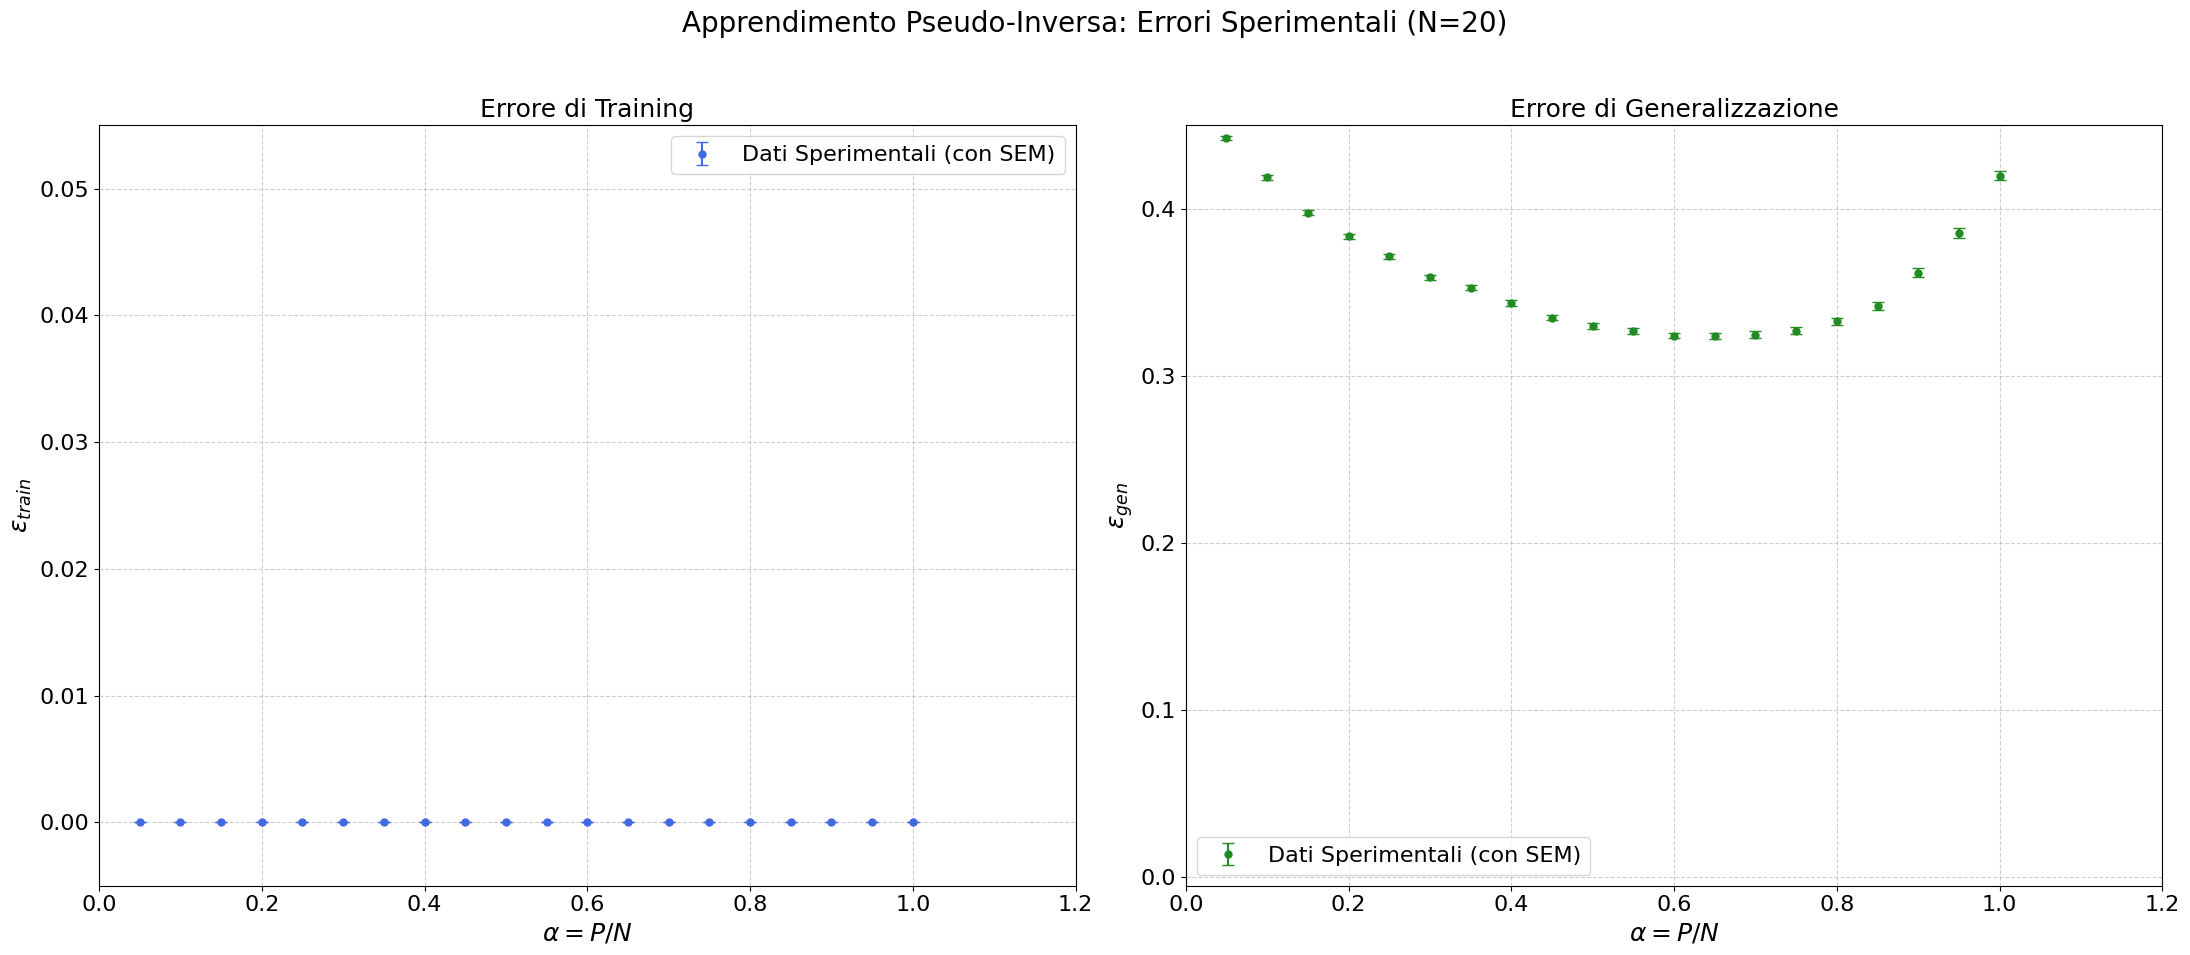

In [48]:
Experiment.plot_pseudo_inverse_results(experiment_runner, results=final_results, save_figure=True)

In [7]:
if __name__ == "__main__":
    import json
    import os
    # Funzione helper per convertire tipi NumPy in tipi nativi Python per JSON
    class NumpyEncoder(json.JSONEncoder):
        def default(self, obj):
            if isinstance(obj, np.integer):
                return int(obj)
            if isinstance(obj, np.floating):
                return float(obj)
            if isinstance(obj, np.ndarray):
                return obj.tolist()
            return super(NumpyEncoder, self).default(obj)

    # --- CONFIGURAZIONE ESPERIMENTO ---
    N_adaline = 20          # Puoi cambiare la dimensione qui
    ALPHA_MAX = 10.1        # Puoi estendere il range qui
    ALPHA_RES = 0.05        # Puoi cambiare la risoluzione qui
    
    # --- GESTIONE FILE E CARICAMENTO ---
    RESULTS_FILENAME = "experiment_results.json" # Cambiato estensione in .json
    LOAD_EXISTING_RESULTS = True  # Metti False se vuoi ignorare il file e partire da zero
    RUN_NEW_EXPERIMENT = False # Se False, salta l'esecuzione dell'esperimento e usa solo i dati caricati
    
    try:
        num_cores = len(os.sched_getaffinity(0))
    except AttributeError:
        num_cores = os.cpu_count()
    print(f"*** Rilevati {num_cores} core CPU disponibili per la parallelizzazione. ***\n")

    experiment_runner = Experiment(name="Confronto tra Dinamiche")
    
    # 1. Caricamento (Opzionale)
    if LOAD_EXISTING_RESULTS and os.path.exists(RESULTS_FILENAME):
        print(f"--- Caricamento risultati esistenti da {RESULTS_FILENAME} ---")
        try:
            with open(RESULTS_FILENAME, "r") as f:
                loaded_results = json.load(f)
            
            # Riconversione liste in array numpy se necessario per compatibilità con il resto del codice
            # (Opzionale ma consigliato se le funzioni di plot si aspettano array numpy)
            for key, value in loaded_results.items():
                if isinstance(value, list):
                    loaded_results[key] = np.array(value)
                    
            experiment_runner.results.update(loaded_results)
            print(f"Dati caricati. Esperimenti presenti: {[k for k in loaded_results.keys() if 'runs_num' in k]}")
        except Exception as e:
            print(f"Errore nel caricamento: {e}. Si parte da vuoto.")
    else:
        print("--- Si inizia con un set di risultati vuoto (File ignorato o non esistente) ---")

    # 2. Esecuzione Nuovo Esperimento
    # Nota: Questo sovrascriverà i dati 'adaline' precedenti in memoria, 
    # ma manterrà i dati 'pseudo_inverse' o 'hebb' se erano stati caricati.
    if RUN_NEW_EXPERIMENT:
        experiment_runner.run_experiment_adaline(
            N=N_adaline, 
            alpha_max=ALPHA_MAX, 
            alpha_resolution=ALPHA_RES
        )
    else:
        print("--- Esecuzione esperimento saltata (RUN_NEW_EXPERIMENT = False) ---")
    
    # 3. Salvataggio (Unione di vecchi e nuovi)
    final_results = experiment_runner.results
    print(f"--- Salvataggio risultati aggiornati in {RESULTS_FILENAME} ---")
    try:
        with open(RESULTS_FILENAME, "w") as f:
            json.dump(final_results, f, cls=NumpyEncoder, indent=4)
        print("Salvataggio completato.")
    except Exception as e:
        print(f"Errore nel salvataggio: {e}")


*** Rilevati 8 core CPU disponibili per la parallelizzazione. ***

--- Caricamento risultati esistenti da experiment_results.json ---
Dati caricati. Esperimenti presenti: ['runs_num_adaline', 'runs_num_pseudo_inverse', 'runs_num_bayes']
--- Esecuzione esperimento saltata (RUN_NEW_EXPERIMENT = False) ---
--- Salvataggio risultati aggiornati in experiment_results.json ---
Salvataggio completato.



--- Esecuzione Plot dei Risultati della Adaline Rule (Solo Sperimentali) ---
Grafico 1 salvato come 'adaline_comparison_N20_full.png'


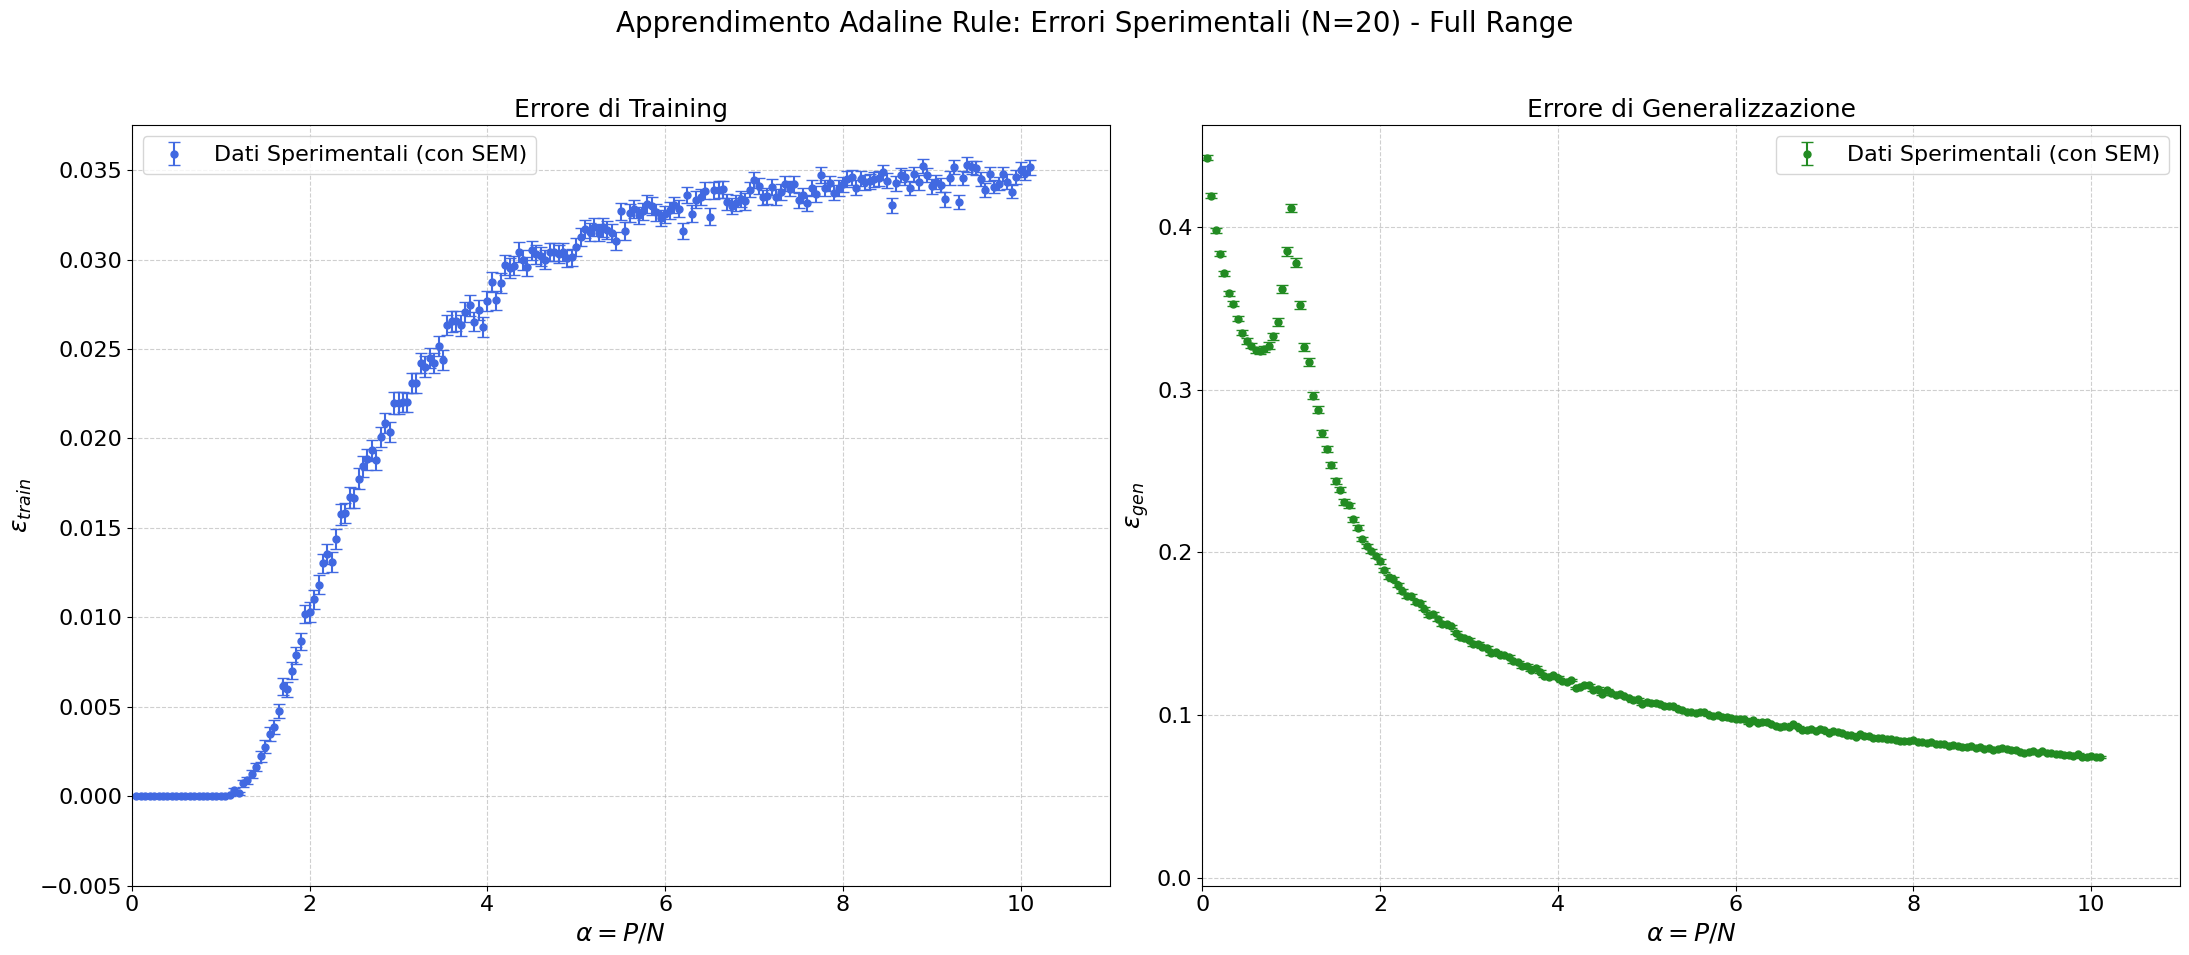

Grafico 2 salvato come 'adaline_comparison_N20_zoom.png'


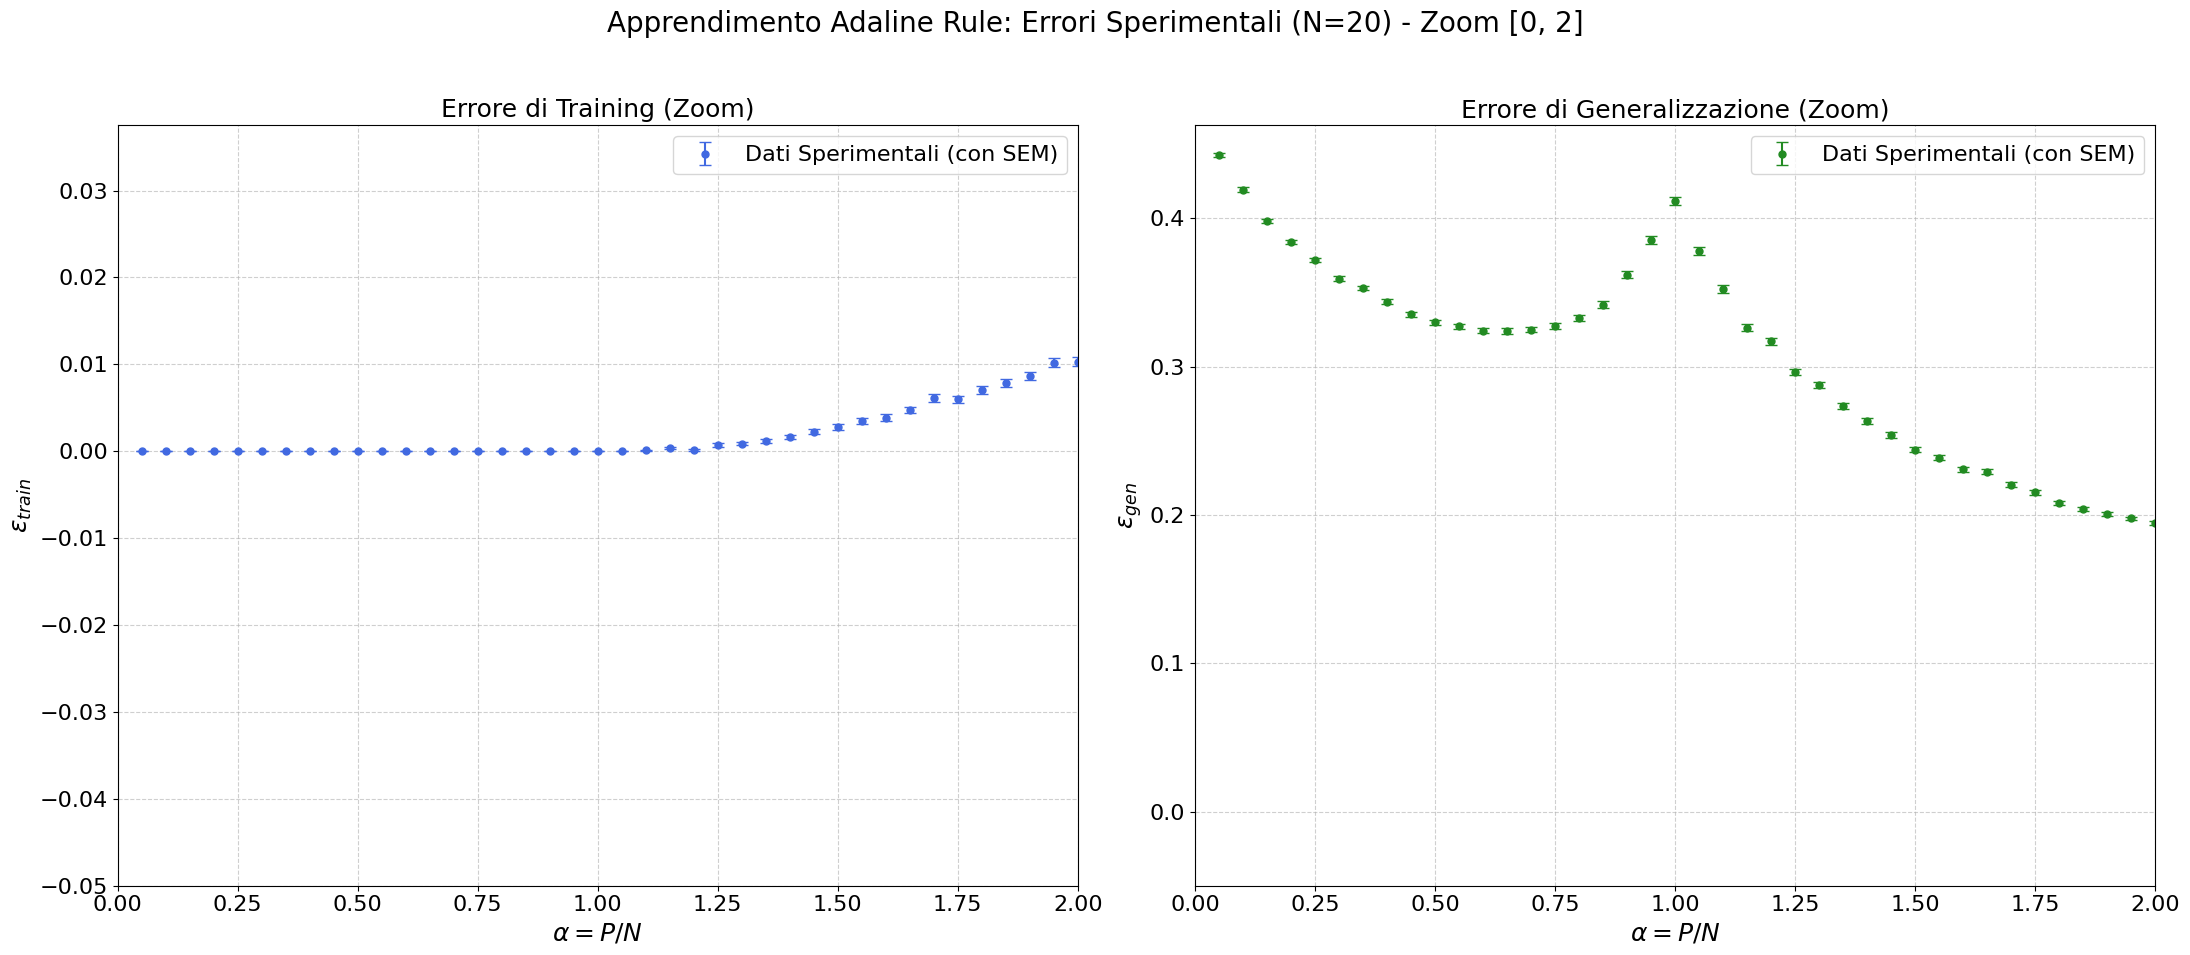

In [6]:
Experiment.plot_adaline_results(experiment_runner, results=final_results, save_figure=True)


--- Esecuzione Plot di Confronto Adaline vs Pseudo-Inverse ---
Grafico di confronto salvato come 'adaline_vs_pseudoinverse_comparison.png'


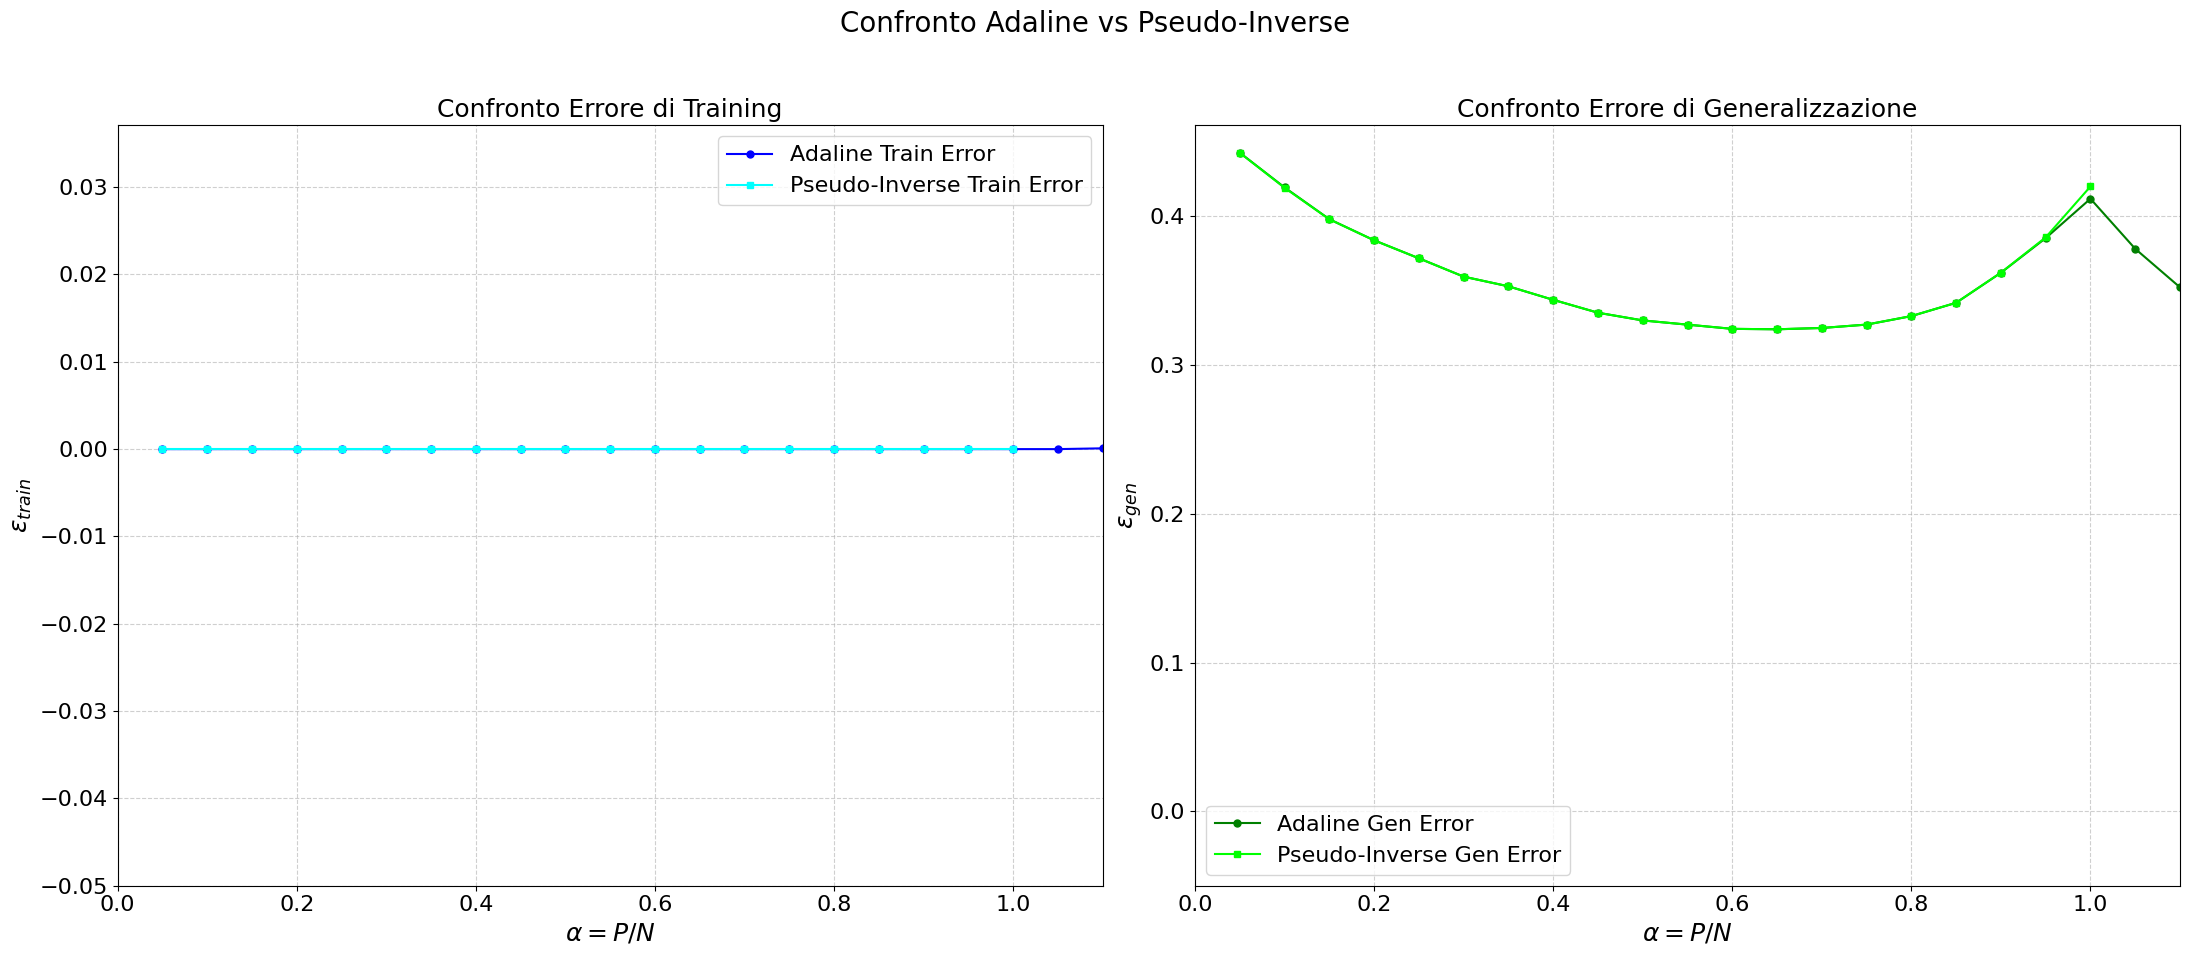

In [63]:
Experiment.plot_comparison_adaline_pseudoinverse(experiment_runner, final_results, save_figure=True)

In [21]:
if __name__ == "__main__":
    import json
    import os
    # Funzione helper per convertire tipi NumPy in tipi nativi Python per JSON
    class NumpyEncoder(json.JSONEncoder):
        def default(self, obj):
            if isinstance(obj, np.integer):
                return int(obj)
            if isinstance(obj, np.floating):
                return float(obj)
            if isinstance(obj, np.ndarray):
                return obj.tolist()
            return super(NumpyEncoder, self).default(obj)

    # --- CONFIGURAZIONE ESPERIMENTO ---
    N_bayes = 20          # Puoi cambiare la dimensione qui
    ALPHA_MAX = 10.1        # Puoi estendere il range qui
    ALPHA_RES = 0.2        # Puoi cambiare la risoluzione qui
    
    # --- GESTIONE FILE E CARICAMENTO ---
    RESULTS_FILENAME = "experiment_results.json" # Cambiato estensione in .json
    LOAD_EXISTING_RESULTS = True  # Metti False se vuoi ignorare il file e partire da zero
    RUN_NEW_EXPERIMENT = True # Se False, salta l'esecuzione dell'esperimento e usa solo i dati caricati
    
    try:
        num_cores = len(os.sched_getaffinity(0))
    except AttributeError:
        num_cores = os.cpu_count()
    print(f"*** Rilevati {num_cores} core CPU disponibili per la parallelizzazione. ***\n")

    experiment_runner = Experiment(name="Confronto tra Dinamiche")
    
    # 1. Caricamento (Opzionale)
    if LOAD_EXISTING_RESULTS and os.path.exists(RESULTS_FILENAME):
        print(f"--- Caricamento risultati esistenti da {RESULTS_FILENAME} ---")
        try:
            with open(RESULTS_FILENAME, "r") as f:
                loaded_results = json.load(f)
            
            # Riconversione liste in array numpy se necessario per compatibilità con il resto del codice
            # (Opzionale ma consigliato se le funzioni di plot si aspettano array numpy)
            for key, value in loaded_results.items():
                if isinstance(value, list):
                    loaded_results[key] = np.array(value)
                    
            experiment_runner.results.update(loaded_results)
            print(f"Dati caricati. Esperimenti presenti: {[k for k in loaded_results.keys() if 'runs_num' in k]}")
        except Exception as e:
            print(f"Errore nel caricamento: {e}. Si parte da vuoto.")
    else:
        print("--- Si inizia con un set di risultati vuoto (File ignorato o non esistente) ---")

    # 2. Esecuzione Nuovo Esperimento
    # Nota: Questo sovrascriverà i dati 'adaline' precedenti in memoria, 
    # ma manterrà i dati 'pseudo_inverse' o 'hebb' se erano stati caricati.
    if RUN_NEW_EXPERIMENT:
        experiment_runner.run_experiment_bayes(
            N=N_bayes, 
            alpha_max=ALPHA_MAX, 
            alpha_resolution=ALPHA_RES
        )
    else:
        print("--- Esecuzione esperimento saltata (RUN_NEW_EXPERIMENT = False) ---")
    
    # 3. Salvataggio (Unione di vecchi e nuovi)
    final_results = experiment_runner.results
    print(f"--- Salvataggio risultati aggiornati in {RESULTS_FILENAME} ---")
    try:
        with open(RESULTS_FILENAME, "w") as f:
            json.dump(final_results, f, cls=NumpyEncoder, indent=4)
        print("Salvataggio completato.")
    except Exception as e:
        print(f"Errore nel salvataggio: {e}")


*** Rilevati 8 core CPU disponibili per la parallelizzazione. ***

--- Caricamento risultati esistenti da experiment_results.json ---
Dati caricati. Esperimenti presenti: ['runs_num_adaline', 'runs_num_pseudo_inverse']
--- Esecuzione Esperimento Adaline (N=20, alpha_max=10.1, res=0.2) ---
P_max_train adaline: 202
P_resolution adaline: 4
--- Inizio simulazione bayes noise OTTIMIZZATA per N = 20 ---
Parallelismo: 8 workers attivi (runs per worker: 125 avg)
Avvio simulazione per N=20, P=1...


Completato per N=20, P=1 in 3.47 secondi.
Errore medio train: 0.0000, gen: 0.4557
Avvio simulazione per N=20, P=4...
Completato per N=20, P=4 in 0.39 secondi.
Errore medio train: 0.0000, gen: 0.3910
Avvio simulazione per N=20, P=8...
Completato per N=20, P=8 in 1.00 secondi.
Errore medio train: 0.0000, gen: 0.3422
Avvio simulazione per N=20, P=12...
Completato per N=20, P=12 in 2.18 secondi.
Errore medio train: 0.0000, gen: 0.3060
Avvio simulazione per N=20, P=16...
Completato per N=20, P=16 in 3.87 secondi.
Errore medio train: 0.0000, gen: 0.2755
Avvio simulazione per N=20, P=20...
Completato per N=20, P=20 in 6.25 secondi.
Errore medio train: 0.0000, gen: 0.2507
Avvio simulazione per N=20, P=24...
Completato per N=20, P=24 in 8.24 secondi.
Errore medio train: 0.0000, gen: 0.2308
Avvio simulazione per N=20, P=28...
Completato per N=20, P=28 in 11.10 secondi.
Errore medio train: 0.0000, gen: 0.2142
Avvio simulazione per N=20, P=32...
Completato per N=20, P=32 in 13.79 secondi.
Errore m


--- Esecuzione Plot dei Risultati della Bayes Rule (Sperimentali vs Teorici) ---
Calcolo della curva teorica Bayes...
Grafico salvato come 'bayes_comparison_N20_theoretical.png'


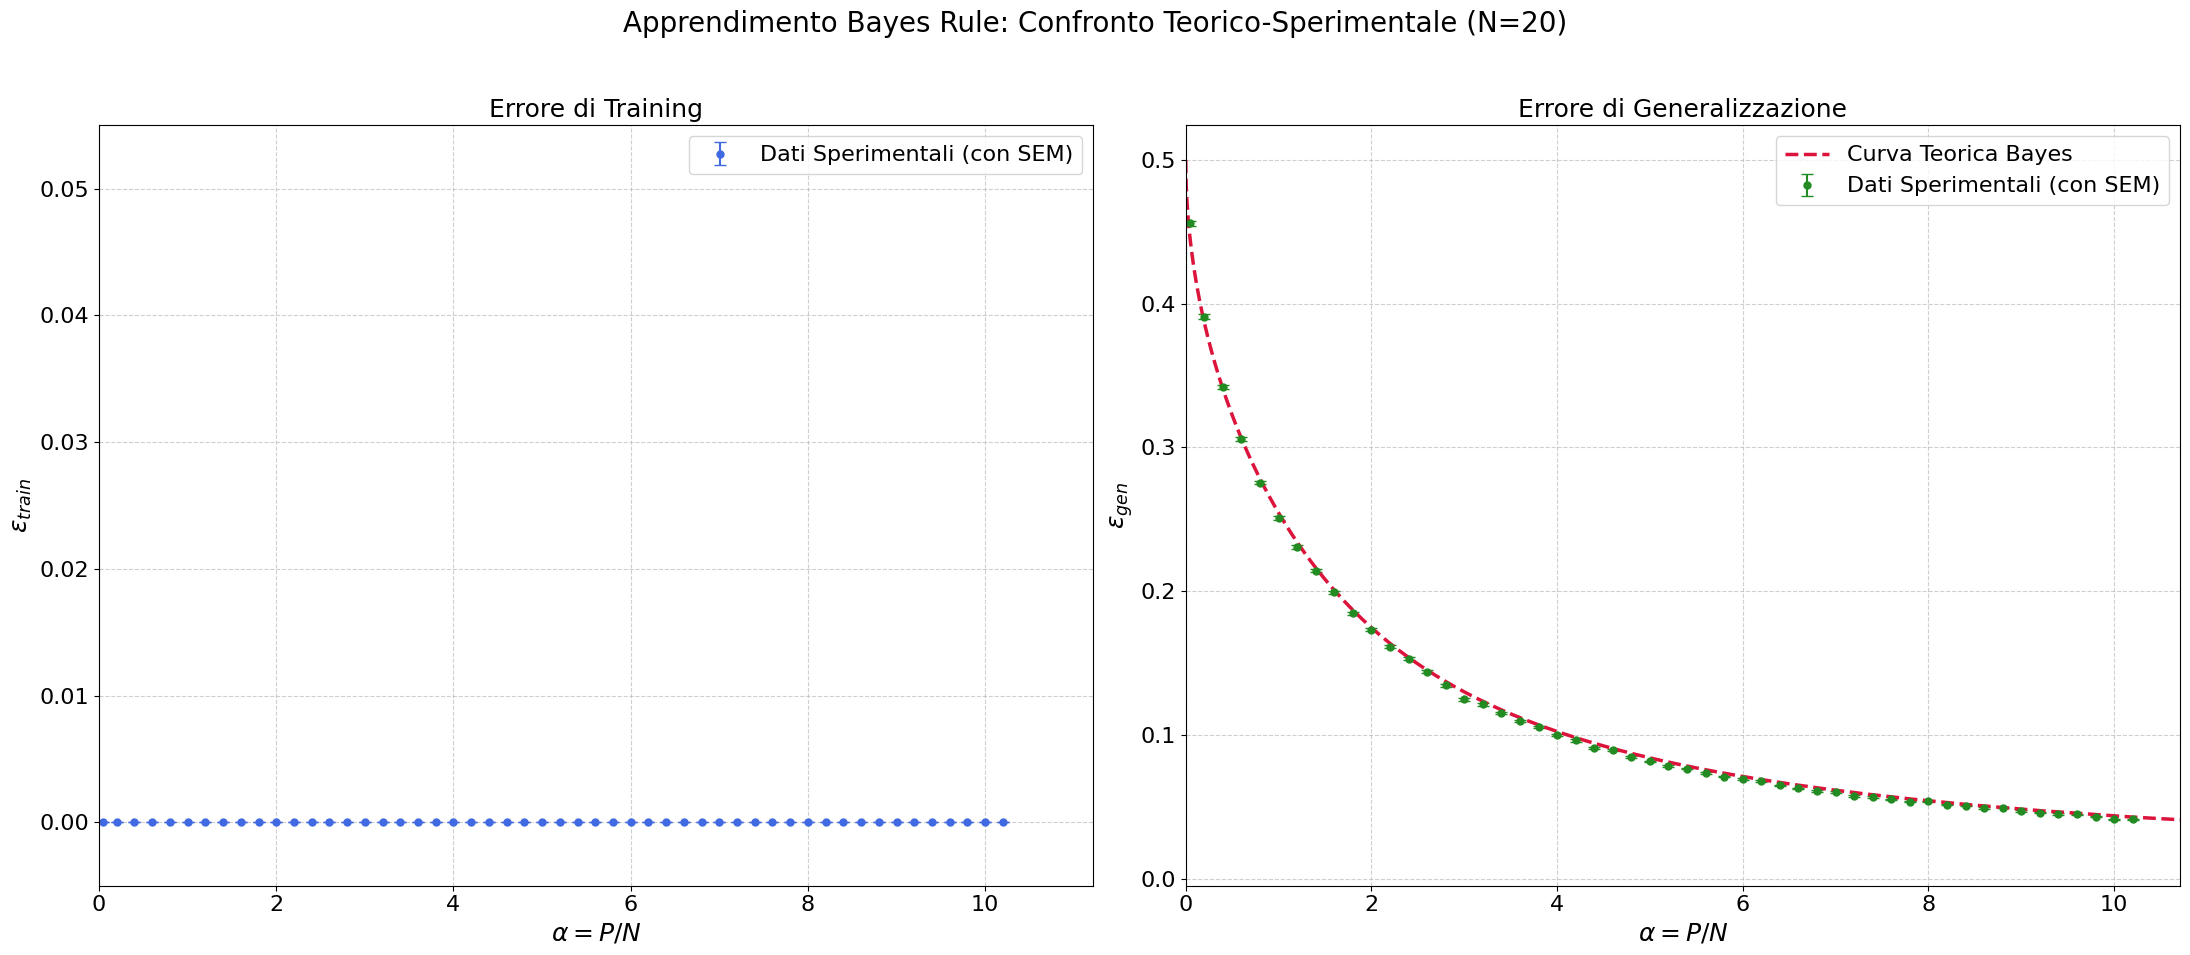

In [70]:
Experiment.plot_bayes_results(experiment_runner, final_results, save_figure=True)

In [9]:
test_size, runs_num, sigma2 = 1000, 1000, 50
train_sizes_20 = [1, 10, 20, 50, 100, 150, 200]
means20 = [0.4897, 0.4148, 0.3409, 0.2043, 0.1116, 0.0743, 0.0537]
stds20 = [0.0768, 0.0724, 0.0638, 0.0456, 0.0292, 0.0221, 0.0170]
train_sizes_40 = [1, 2, 20, 40, 100, 200, 300]
means40 = [0.4963, 0.4903, 0.4167, 0.3396, 0.2058, 0.1140, 0.0748]
stds40 = [0.0562, 0.0540, 0.0500, 0.0458, 0.0332, 0.0220, 0.0159]
perceptron_noise_results = {
    'runs_num': runs_num,
    'train_sizes_20': train_sizes_20, 'error_means_20': means20, 'error_stds_20': stds20,
    'train_sizes_40': train_sizes_40, 'error_means_40': means40, 'error_stds_40': stds40,
}

# runs_num_hebb: 1000
# train_sizes_hebb= [1, 201, 401, 601, 801, 1001, 1201, 1401, 1601, 1801, 2001, 2201, 2401, 2601, 2801, 3001, 3201, 3401, 3601, 3801, 4001, 4201, 4401, 4601, 4801, 5001, 5201, 5401, 5601, 5801]
# N_dimension_hebb= 100
# train_error_means_hebb= [0.0, 0.08662687, 0.08987032, 0.08662396, 0.08187266, 0.07821479, 0.07508993, 0.07159458, 0.06922174, 0.06668462, 0.0647936, 0.06263835, 0.06061766, 0.05913456, 0.05768761, 0.05618361, 0.05457045, 0.05337254, 0.05247515, 0.05111208, 0.05031367, 0.04934825, 0.04846535, 0.04759509, 0.04703291, 0.04617357, 0.04551605, 0.04473042, 0.0443669, 0.04348992]
# train_error_stds_hebb= [0.0, 0.0183043, 0.01381072, 0.01132026, 0.00997499, 0.00902276, 0.00806146, 0.0071193, 0.00685755, 0.00654808, 0.00641211, 0.00589664, 0.0058354, 0.00550112, 0.00538423, 0.00508522, 0.00492952, 0.00491419, 0.00456923, 0.00463459, 0.00429584, 0.0044991, 0.0041429, 0.00403733, 0.00401199, 0.00407064, 0.00393631, 0.00393605, 0.0038009, 0.00364438]
# gen_error_means_hebb= [0.476032, 0.229145, 0.177069, 0.149451, 0.130961, 0.118411, 0.108808, 0.101119, 0.095076, 0.090083, 0.08616, 0.082487, 0.079061, 0.076388, 0.073535, 0.070468, 0.068432, 0.066546, 0.065357, 0.063068, 0.06157, 0.059886, 0.059017, 0.057586, 0.056872, 0.055743, 0.05397, 0.053249, 0.052605, 0.051344]
# gen_error_stds_hebb= [0.02358239, 0.01881834, 0.01698106, 0.0151807, 0.01441303, 0.01336054, 0.01259885, 0.01169704, 0.01106166, 0.0113153, 0.01060417, 0.01037342, 0.01035091, 0.00983328, 0.00973985, 0.00917567, 0.00980201, 0.00948155, 0.00911469, 0.00895653, 0.00904329, 0.00885895, 0.00847766, 0.00838156, 0.00847382, 0.00795191, 0.00808215, 0.00828269, 0.00774396, 0.0076979]

# hebbs_results = {
#     'runs_num_hebb': runs_num,
#     'train_sizes_hebb': train_sizes_hebb, 'N_dimension_hebb': N_dimension_hebb, 'train_error_means_hebb': train_means_hebb, 'train_error_stds_hebb': train_stds_hebb,
#     'gen_error_means_hebb': gen_means_hebb, 'gen_error_stds_hebb': gen_stds_hebb
# }

runs_num_hebb = 1000
train_sizes_hebb = [1, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101, 111, 121, 131, 141, 151, 161, 171, 181, 191, 201, 211, 221, 231, 241, 251, 261, 271, 281, 291, 301, 311, 321, 331, 341, 351, 361, 371, 381, 391, 401, 411, 421, 431, 441, 451, 461, 471, 481, 491, 501, 511, 521, 531, 541]
N_dimension_hebb = 50
train_error_means_hebb = [0.0, 0.00545455, 0.02738095, 0.04567742, 0.05953659, 0.06496078, 0.07204918, 0.07642254, 0.07991358, 0.08369231, 0.08641584, 0.08681982, 0.08809091, 0.08864122, 0.08863121, 0.08821192, 0.0891118, 0.08933918, 0.08957459, 0.0896911, 0.08956716, 0.0888673, 0.08942534, 0.08821645, 0.08788797, 0.08784462, 0.08668582, 0.08645018, 0.08672954, 0.08696564, 0.08568106, 0.08533119, 0.08469159, 0.08529003, 0.08334018, 0.08369516, 0.08337119, 0.08211321, 0.08183465, 0.082, 0.08155611, 0.08076156, 0.08192637, 0.07978886, 0.08007029, 0.0793969, 0.07908894, 0.07861359, 0.07860083, 0.07807943, 0.07792415, 0.07715264, 0.07756238, 0.0762467, 0.07674677]
train_error_stds_hebb = [0.0, 0.02196917, 0.03428489, 0.03341387, 0.0346008, 0.03156212, 0.03028564, 0.02949863, 0.02793855, 0.02692318, 0.02609059, 0.02532354, 0.02382219, 0.0230876, 0.02273267, 0.02075459, 0.02147182, 0.02111125, 0.01998109, 0.01993097, 0.01906517, 0.02010004, 0.01829691, 0.01771357, 0.017931, 0.01725638, 0.01740171, 0.01707208, 0.01710384, 0.01662632, 0.0159288, 0.01564518, 0.01545102, 0.01515329, 0.01517448, 0.01462148, 0.0144946, 0.01451094, 0.01427806, 0.01372431, 0.01395181, 0.01385148, 0.01315021, 0.01341374, 0.01308378, 0.01311266, 0.01343999, 0.01303794, 0.01330817, 0.01237569, 0.01260845, 0.01199441, 0.01254637, 0.01195254, 0.01200506]
gen_error_means_hebb = [0.463107, 0.384378, 0.345157, 0.319158, 0.297918, 0.280349, 0.26506, 0.2551, 0.245278, 0.234036, 0.226369, 0.220823, 0.213079, 0.205906, 0.202055, 0.195827, 0.191577, 0.186621, 0.182859, 0.178675, 0.175075, 0.172415, 0.167741, 0.165242, 0.162367, 0.159832, 0.156693, 0.15496, 0.152229, 0.150148, 0.1476, 0.145715, 0.143804, 0.14211, 0.138993, 0.138662, 0.136882, 0.134969, 0.133175, 0.13151, 0.13062, 0.128266, 0.127159, 0.124921, 0.125424, 0.12288, 0.122419, 0.120432, 0.120363, 0.118035, 0.11839, 0.116841, 0.116093, 0.114648, 0.114024]
gen_error_stds_hebb = [0.03175754, 0.02915512, 0.02906793, 0.02772661, 0.02708733, 0.02580634, 0.02718489, 0.02543863, 0.02454919, 0.02399026, 0.02361472, 0.02335623, 0.02314318, 0.02246662, 0.0221489, 0.02177919, 0.02135196, 0.0206077, 0.02027435, 0.01969024, 0.01967362, 0.0198359, 0.01965502, 0.01999378, 0.01887963, 0.01861402, 0.01912848, 0.01888185, 0.01770199, 0.01819445, 0.01756001, 0.01762401, 0.01797169, 0.01711309, 0.01654421, 0.01671687, 0.01700459, 0.01684773, 0.01683539, 0.01616824, 0.01579935, 0.01707399, 0.01583066, 0.01616907, 0.01602917, 0.01511898, 0.01602752, 0.01537437, 0.01539277, 0.01541985, 0.0152807, 0.01574204, 0.01505458, 0.01531731, 0.01551391]
hebbs_results = {
    'runs_num_hebb': runs_num,
    'train_sizes_hebb': train_sizes_hebb, 'N_dimension_hebb': N_dimension_hebb, 'train_error_means_hebb': train_error_means_hebb, 'train_error_stds_hebb': train_error_stds_hebb,
    'gen_error_means_hebb': gen_error_means_hebb, 'gen_error_stds_hebb': gen_error_stds_hebb
}

runs_num_perceptron_zero_noise = 1000
train_sizes_perceptron_zero_noise = [1, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101, 111, 121, 131, 141, 151, 161, 171, 181, 191, 201, 211, 221, 231, 241, 251, 261, 271, 281, 291, 301, 311, 321, 331, 341, 351, 361, 371, 381, 391, 401, 411, 421, 431, 441, 451, 461, 471, 481, 491, 501, 511, 521, 531, 541]
N_dimension_perceptron_zero_noise = 50
gen_error_perceptron_zero_noise = [0.497357, 0.456926, 0.419024, 0.384376, 0.348161, 0.319876, 0.289727, 0.263476, 0.242245, 0.221896, 0.20356, 0.189112, 0.174856, 0.163835, 0.154654, 0.144436, 0.137549, 0.130262, 0.123943, 0.117929, 0.112032, 0.109117, 0.104143, 0.100007, 0.096472, 0.092871, 0.09044, 0.087178, 0.084594, 0.081551, 0.078664, 0.076577, 0.074531, 0.071805, 0.069867, 0.06878, 0.066516, 0.06476, 0.063385, 0.061427, 0.060366, 0.058782, 0.056751, 0.056441, 0.055085, 0.053529, 0.052517, 0.052445, 0.051143, 0.049392, 0.049215, 0.048127, 0.046745, 0.046358, 0.045375]
gen_error_stds_perceptron_zero_noise = [0.04719343, 0.04663435, 0.04430008, 0.04154213, 0.04177982, 0.03951856, 0.03787139, 0.03656634, 0.03491139, 0.03356613, 0.03117779, 0.02870842, 0.02688653, 0.02554877, 0.02410121, 0.02304556, 0.02166208, 0.02109212, 0.02022864, 0.01914753, 0.01890881, 0.01902097, 0.0168704, 0.01776685, 0.01637099, 0.01635758, 0.01569237, 0.01586797, 0.01519458, 0.01464689, 0.01458805, 0.01429308, 0.01380685, 0.01301687, 0.01286706, 0.01288843, 0.01246402, 0.0126424, 0.01234296, 0.01173238, 0.01213079, 0.01198376, 0.01124398, 0.01096196, 0.01159611, 0.01084634, 0.01076214, 0.01130915, 0.01030129, 0.01042364, 0.01036324, 0.00972784, 0.01010851, 0.00976268, 0.00965207]
perceptron_zero_noise_results = {
    'runs_num_perceptron_zero_noise': runs_num_perceptron_zero_noise,
    'train_sizes_perceptron_zero_noise': train_sizes_perceptron_zero_noise,
    'N_dimension_perceptron_zero_noise': N_dimension_perceptron_zero_noise,
    'gen_error_means_perceptron_zero_noise': gen_error_perceptron_zero_noise,
    'gen_error_stds_perceptron_zero_noise': gen_error_stds_perceptron_zero_noise
}

final_results.update(perceptron_noise_results)
final_results.update(hebbs_results)
final_results.update(perceptron_zero_noise_results)

In [15]:
# Salva i tuoi dati - se il file è corrotto, verrà fatto un backup automatico
save_results_to_json(final_results)

🔄 Conversione di array NumPy in liste Python...
📂 File 'experiment_results.json' trovato. Caricamento dati esistenti...

⚠️  ATTENZIONE: Il file 'experiment_results.json' è corrotto!
   Errore JSON: Expecting value: line 3 column 28 (char 59)
   📦 Creazione backup in: 'experiment_results.json.corrupted_20251122_171529.bak'
   ✓ Backup creato con successo
   🔄 Creazione nuovo file con i dati forniti...

✓ Dati salvati con successo in 'experiment_results.json'
  Totale chiavi nel file: 40
  Dimensione file: 39.6 KB


True

In [16]:
# Carica tutti i risultati dal file
all_results = load_results_from_json()

# Usa i risultati
if all_results:
    print(all_results['runs_num_hebb'])

✓ Dati caricati con successo da 'experiment_results.json'
  Totale chiavi nel file: 40
  Esperimenti disponibili:
   - adaline
   - bayes
   - hebb
   - perceptron_noise
   - perceptron_zero_noise
   - pseudo_inverse
1000



--- Esecuzione Plot dei Risultati della Hebb Rule ---
Grafico 1 salvato come 'hebb_learning_comparison_N100.png'


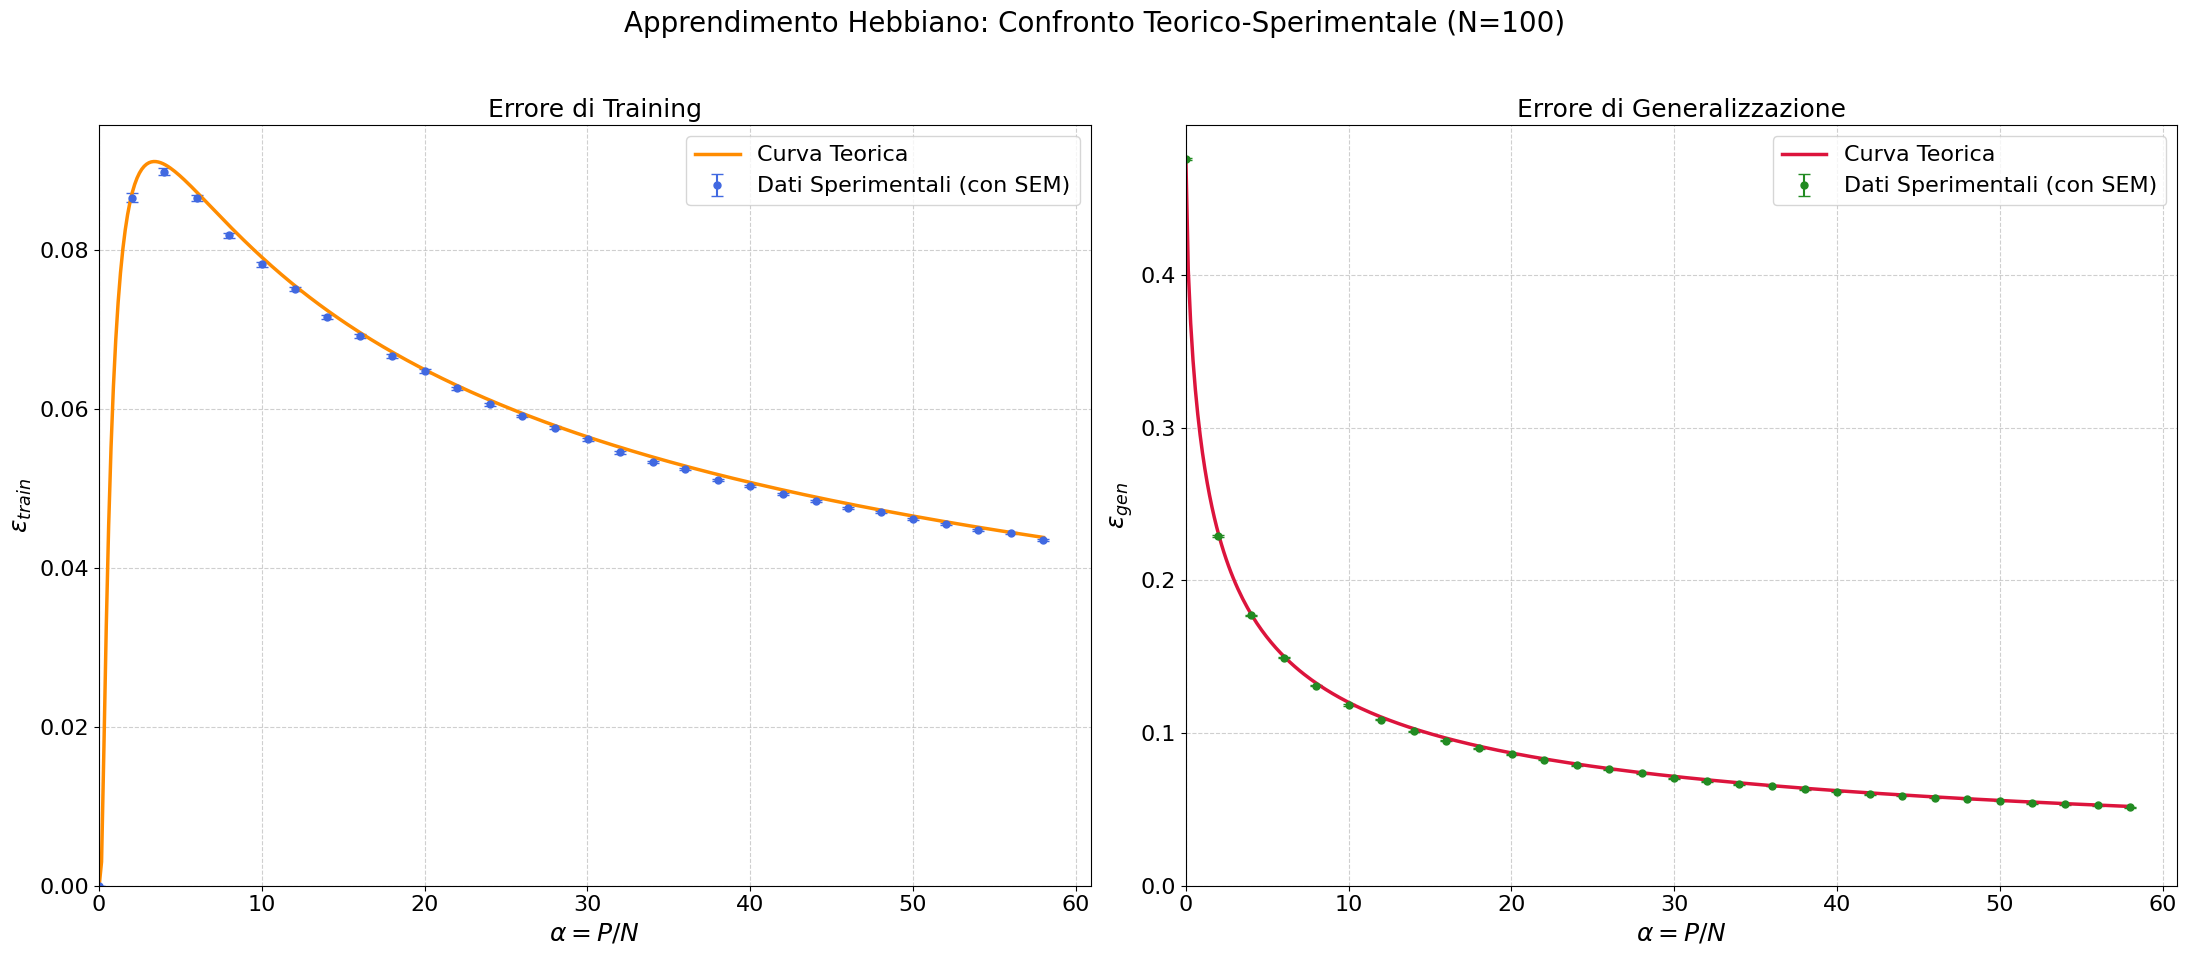

Grafico 2 salvato come 'hebb_error_analysis_N100.png'


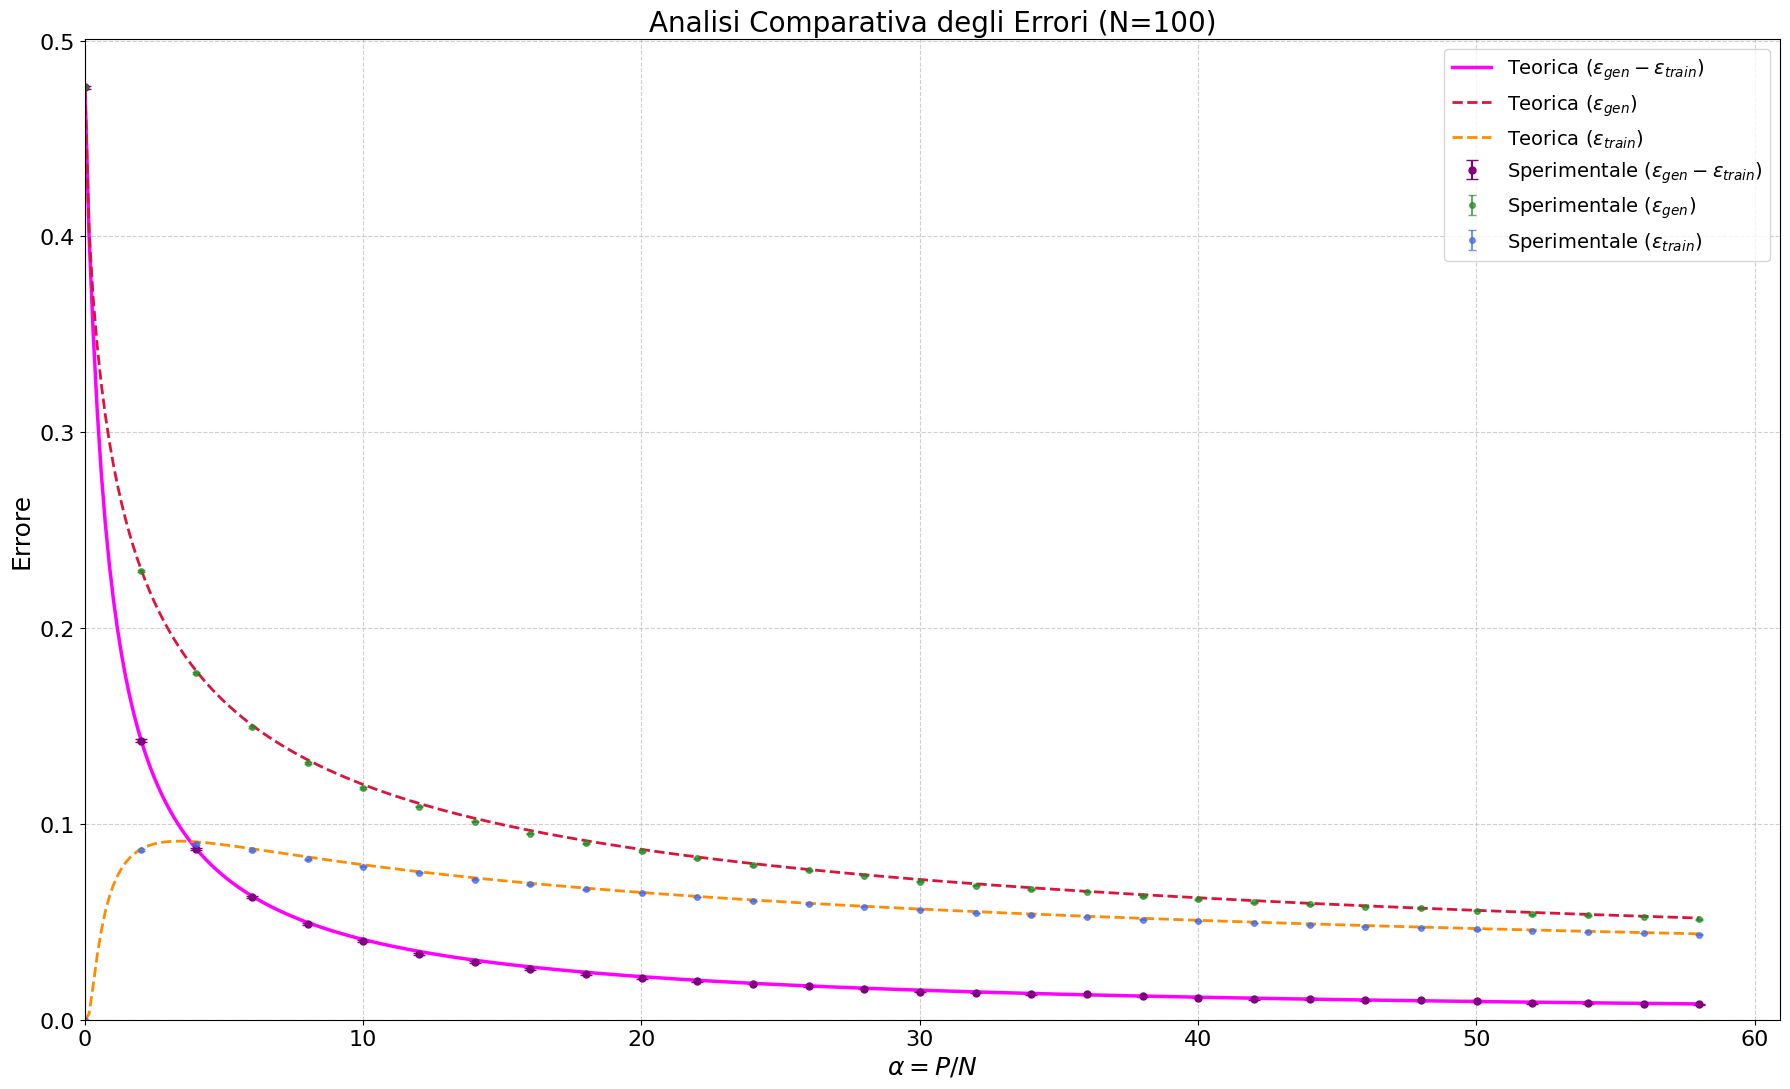

In [89]:
Experiment.plot_hebb_results(experiment_runner, results=final_results)


--- Esecuzione Plot di Confronto Completo ---
✓ Tutti gli esperimenti richiesti sono presenti nel dataset.
Calcolo teorie Annealed, Quenched, Hebb e Bayes...
--- Calcoli Teorici Completati. Inizio Plotting. ---

Salvataggio figura in: master_comparison_train_vs_gen.png


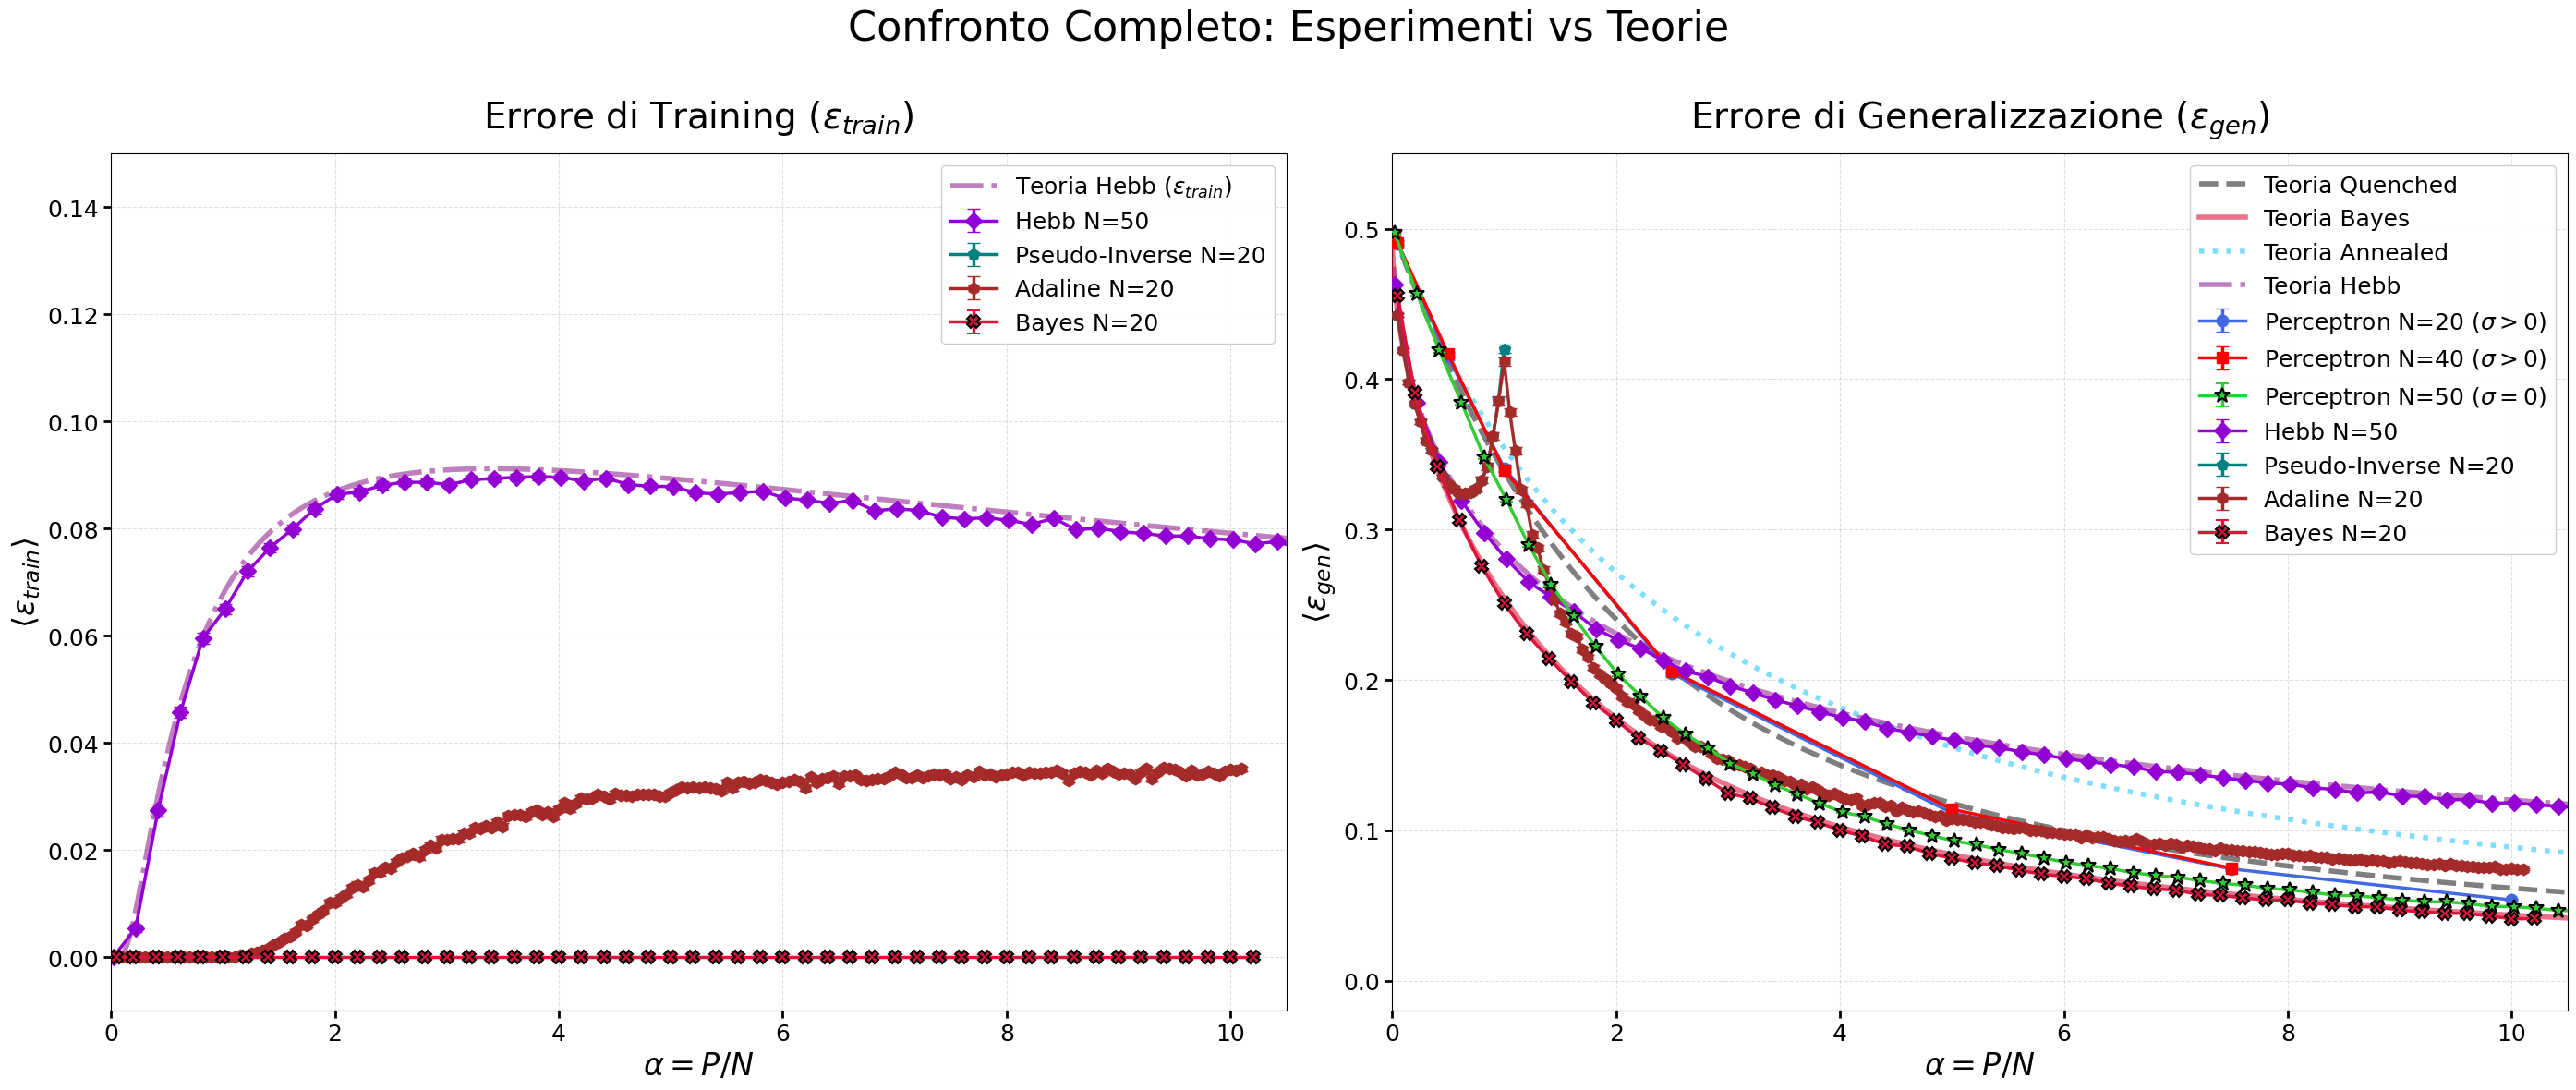

In [32]:
Experiment.plot_advanced_comparison(experiment_runner, results=all_results, save_figure=True)